In [3]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
from pprint import pprint

In [4]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [5]:
! ls data/

1952852_CPJ7P.csv	       colegiosJul15.csv       Happiness.csv
1952852_NY3EE.csv	       Dating.csv	       HDI1.csv
accidentes.csv		       fb_ad.csv	       HDI.csv
ad_car.csv		       fb_adMayAug.csv	       info_fotos.csv
adcar.csv		       fb_page_data14.csv      Lista Staff.csv
ad_click.csv		       fb_page_data15.csv      mobile14.csv
adclick.csv		       fb_post_data14.csv      mobile15.csv
ad_delivery.csv		       fb_post_data15.csv      ninas2016.csv
addelivery.csv		       fb_post_may_jun15.csv   page_data15.csv
ad_engage.csv		       fb_post_may_jun15s.csv  papas2015.csv
adengage.csv		       fb_video_data14.csv     posts_flips.csv
ad_general.csv		       fb_video_data15.csv     RAV2.csv
ad_video.csv		       fb_video_may_jun15.csv  RAV3.csv
advideo.csv		       flipsvid_click.csv      RAVFinal.csv
allads.csv		       flipsvid_delivery.csv   staff.csv
clp_copp.csv		       flipsvid_engage.csv     users_site14.csv
colegios2014.csv	       flipsvid_general.csv    video_ad.csv
colegios2015.csv	 

In [6]:
%pylab inline
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Populating the interactive namespace from numpy and matplotlib


In [7]:
output_notebook()

Loading BokehJS ...

In [8]:
import argparse
import ConfigParser

In [9]:
config = ConfigParser.ConfigParser()
config.read('.ttapis.cfg')

['.ttapis.cfg']

In [10]:
config.sections()

['Eventbrite', 'Youtube', 'Twitter']

In [11]:
eventbrite_config = dict(config.items('Eventbrite'))

In [12]:
eventbrite_config

{'client_secret': 'BXIMVZ5OXTZY6A5CCAKQOHA2LRMYUCFLRWJX5SYGU5B7VCGBUW',
 'oauth_token': 'VGEVVCFJHQ4K4SP6KBQC'}

In [13]:
auth = 'Bearer %s'%eventbrite_config['oauth_token']

In [14]:
auth

'Bearer VGEVVCFJHQ4K4SP6KBQC'

In [60]:
! cat '.ttapis.cfg'

# Copy file to ~/.ttapis.cfg and replace with values

[Eventbrite]

client_secret=BXIMVZ5OXTZY6A5CCAKQOHA2LRMYUCFLRWJX5SYGU5B7VCGBUW
oauth_token = VGEVVCFJHQ4K4SP6KBQC

[Youtube]

client_id=459024911473-caseell6k22f0e6a8igl43f47v2emfj6.apps.googleusercontent.com
project_id=trixandtrax-analytics
auth_uri=https://accounts.google.com/o/oauth2/auth
token_uri=https://accounts.google.com/o/oauth2/token
auth_provider_x509_cert_url=https://www.googleapis.com/oauth2/v1/certs
client_secret=g9D42Jyvw63AbY9YN-4qPRKj
javascript_origins=["http://www.trixandtrax.com"]



[Twitter]
consumer_key=KbmjejZo9cJar4MRx8xIza38R
consumer_secret=c9qObAiN0RrZ9kFMFIAg5sK6GX1dWGHWqGnby2la6VwUAyLVaD
access_token=7545822-bnGlDN8QbfOiUsBMAaRa0BPpGXExeoTlkaf2xbgtf2
access_token_secret=o1WL6A7milb2j8KvzoMWJJxMfxtmF1wEXNGEQJqt3Ds1h
track=surf,ski,board


## Connect to API and get list of all registered users

In [15]:
url_registrados = "https://www.eventbriteapi.com/v3/users/me/owned_event_attendees/"

In [16]:
attendees_response = requests.get(
    url_registrados,
    headers = {
        "Authorization": auth,
    },
    verify = True,  # Verify SSL certificate
)


In [17]:
page_count = attendees_response.json()['pagination']['page_count']

In [18]:
urls_attendees = ["https://www.eventbriteapi.com/v3/users/me/owned_event_attendees/?page=%s" % (i+1) for i in range(page_count)]

In [19]:
attendees_responses = [requests.get(
    url,
    headers = {
        "Authorization": auth,
    },
    verify = True,  # Verify SSL certificate
) for url in urls_attendees]


In [20]:
len(attendees_responses)

83

In [277]:
import dill
with open('registrados.dill', 'w') as filename:
    dill.dump(attendees_responses,filename)

In [21]:
events_response = requests.get(
    "https://www.eventbriteapi.com/v3/users/me/owned_events/?expand=ticket_classes,venue",
    headers = {
        "Authorization": auth,
    },
    verify = True,  # Verify SSL certificate
)


In [22]:
len(events_response.json()['events'])

8

In [32]:
import dill
with open('eventos.dill', 'w') as filename:
    dill.dump(events_response,filename)

# Create Dataframe

In [23]:
class ColumnSelectTransformer():
    """
    Returns the columns  of a panda table
    """
    def __init__(self, cols):
        self.cols = cols
        pass

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        if type(X) == dict:
            X = [X[c] for c in self.cols]
        else:
            X = X[self.cols]
            ##X = X.as_matrix(columns=self.cols)
        return X

### Users

In [24]:
df_users = pd.DataFrame(np.nan, index=[0], columns=['empty'])
from pandas.io.json import json_normalize
for response in attendees_responses:
    frame = json_normalize(response.json()['attendees'])
    df_users = pd.concat([df_users,frame], axis=0)


In [25]:
df_users.columns

Index([                       u'affiliate',
                                u'answers',
                               u'barcodes',
                              u'cancelled',
                                u'changed',
                             u'checked_in',
              u'costs.base_price.currency',
               u'costs.base_price.display',
           u'costs.base_price.major_value',
                 u'costs.base_price.value',
          u'costs.eventbrite_fee.currency',
           u'costs.eventbrite_fee.display',
       u'costs.eventbrite_fee.major_value',
             u'costs.eventbrite_fee.value',
                   u'costs.gross.currency',
                    u'costs.gross.display',
                u'costs.gross.major_value',
                      u'costs.gross.value',
             u'costs.payment_fee.currency',
              u'costs.payment_fee.display',
          u'costs.payment_fee.major_value',
                u'costs.payment_fee.value',
                     u'costs.tax

In [26]:
cols = [                
                                     u'id',                            
                               u'event_id',                                    
                               u'order_id',
                                u'created',
                            u'profile.age',
                     u'profile.cell_phone',
                          u'profile.email',
                     u'profile.first_name',
                         u'profile.gender',
                      u'profile.last_name',
                           u'profile.name',
                               u'quantity',
                               u'refunded',
                        u'ticket_class_id',
                                u'answers']
trans = ColumnSelectTransformer(cols)
df_users = trans.transform(df_users)
df_users= df_users[1:]

In [27]:
df_users

,id,event_id,order_id,created,profile.age,profile.cell_phone,profile.email,profile.first_name,profile.gender,profile.last_name,profile.name,quantity,refunded,ticket_class_id,answers
0,428813537,13018373305,339032529,2014-09-09T04:11:50Z,NaN,NaN,alejandro.rojas@sloan.mit.edu,Alejandro,NaN,Rojas,Alejandro Rojas,1,False,28540565,"[{u'question': u'Colegio', u'type': u'text', u..."
1,428816541,13018373305,339034821,2014-09-09T04:21:09Z,NaN,NaN,carlos@trixandtrax.com,Carlos,NaN,Perez,Carlos Perez,1,False,28540565,"[{u'question': u'Colegio', u'type': u'text', u..."
2,430663949,13018373305,340449763,2014-09-11T11:58:37Z,24,NaN,Raca104@gmail.com,Rholdan,NaN,Contreras,Rholdan Contreras,1,False,28554507,"[{u'answer': u'La salle y Humboldt', u'questio..."
3,430663951,13018373305,340449763,2014-09-11T11:58:37Z,24,NaN,Raca104@gmail.com,Rholdan,NaN,Contreras,Rholdan Contreras,1,False,28554509,"[{u'answer': u'La salle y Humboldt', u'questio..."
4,430663953,13018373305,340449763,2014-09-11T11:58:37Z,24,NaN,Raca104@gmail.com,Rholdan,NaN,Contreras,Rholdan Contreras,1,False,28540565,"[{u'answer': u'La salle y Humboldt', u'questio..."
5,430668583,13018373305,340453107,2014-09-11T12:08:36Z,17,NaN,andres29h@hotmail.com,Andrés,NaN,Hernández,Andrés Hernández,1,False,28554509,"[{u'answer': u'Humboldt', u'question': u'Coleg..."
6,430677579,13018373305,340460317,2014-09-11T12:28:15Z,17,NaN,ivanasimonovis97@hotmail.com,Ivana,NaN,Simonovis,Ivana Simonovis,1,False,28540565,"[{u'answer': u'Colegio Humboldt Caracas', u'qu..."
7,430677581,13018373305,340460317,2014-09-11T12:28:15Z,17,NaN,ivanasimonovis97@hotmail.com,Ivana,NaN,Simonovis,Ivana Simonovis,1,False,28554507,"[{u'answer': u'Colegio Humboldt Caracas', u'qu..."
8,430677583,13018373305,340460317,2014-09-11T12:28:15Z,17,NaN,ivanasimonovis97@hotmail.com,Ivana,NaN,Simonovis,Ivana Simonovis,1,False,28554509,"[{u'answer': u'Colegio Humboldt Caracas', u'qu..."
9,430677023,13018373305,340459891,2014-09-11T12:27:13Z,17,NaN,maferca3110@gmail.com,María Fernanda,NaN,Camperos Hernandez,María Fernanda Camperos Hernandez,1,False,28540565,"[{u'answer': u'Colegio Humboldt', u'question':..."


### Events

In [28]:
df_events = json_normalize(events_response.json()['events'])

In [29]:
df_events.columns

Index([                 u'capacity',               u'category_id',
                         u'changed',                   u'created',
                        u'currency',          u'description.html',
                u'description.text',                 u'end.local',
                    u'end.timezone',                   u'end.utc',
                       u'format_id',             u'hide_end_date',
                 u'hide_start_date',                        u'id',
                     u'invite_only',                 u'is_locked',
             u'is_reserved_seating',                 u'is_series',
                u'is_series_parent',                    u'listed',
                          u'locale',                      u'logo',
               u'logo.aspect_ratio',           u'logo.edge_color',
             u'logo.edge_color_set',                   u'logo.id',
                        u'logo.url',                   u'logo_id',
                       u'name.html',                 u'name.te

In [30]:
cols = [                
                                     u'id',  
                                u'name.text',
                          u'ticket_classes',
                           u'start.local',
                          u'end.local',
            ]
trans = ColumnSelectTransformer(cols)
df_events = trans.transform(df_events)

In [31]:
df_events.columns = ['event_id','event_name','ticket_classes','start', 'end']

In [32]:
df_events[df_events['event_name']=='Festival TRIXANDTRAX Flips Fest']['ticket_classes'].values

array([ [{u'quantity_total': 10000, u'maximum_quantity': 1, u'id': u'29123795', u'maximum_quantity_per_order': 1, u'split_fee': False, u'event_id': u'13334051507', u'hidden': False, u'sales_start': u'2014-10-16T22:30:00Z', u'description': None, u'free': True, u'donation': False, u'sales_end': u'2014-11-18T12:30:00Z', u'sales_channels': [u'online', u'atd'], u'variants': [], u'include_fee': False, u'name': u'Asiste al evento TrixandTrax de tu colegio', u'has_pdf_ticket': True, u'quantity_sold': 545, u'auto_hide': False, u'on_sale_status': u'UNAVAILABLE', u'minimum_quantity': 1, u'hide_description': True, u'resource_uri': u'https://www.eventbriteapi.com/v3/events/13334051507/ticket_classes/29123795/'}]], dtype=object)

### Answers

In [348]:
answers_dict = {}
row_iterator = df_users.iterrows()
for i, row in row_iterator:
    answers_dict[row['id']]= row['answers']


order_ids = []
frames = []

for order_id, answers in answers_dict.iteritems():
    order_ids.append(order_id)
    frames.append(json_normalize(answers))

df_answers = pd.concat(frames, keys=order_ids)
df_answers.reset_index(inplace=True) 
df_answers['id']=df_answers['level_0']

In [349]:
df_answers

,level_0,level_1,answer,question,question_id,type,id
0,542433863,0,NaN,Usuario de Instagram:,9950929,text,542433863
1,542433863,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542433863
2,542433863,2,NaN,Colegio donde estudias:,9950957,text,542433863
3,542433863,3,NaN,Año que cursas:,10046693,multiple_choice,542433863
4,542433863,4,Zona Trax,Zona en donde quieres participar,9951123,multiple_choice,542433863
5,542433863,5,No tengo,¿Tienes algún video publicado en Youtube en do...,9951249,multiple_choice,542433863
6,542433863,6,"No, porque me da pena",¿Quieres grabarte mostrando tu talento en Inst...,9953522,multiple_choice,542433863
7,542433863,7,28013255,Tu Número de Cédula de Identidad:,9954651,text,542433863
8,542433863,8,Si,¿Eres menor de edad?,9953444,multiple_choice,542433863
9,542433863,9,NaN,Fechas disponibles para trabajar como staff:,9953573,multiple_choice,542433863


In [350]:
df_answers['question'].unique()

array([u'Usuario de Instagram:',
       u'Colegio donde estudias y fecha del evento:',
       u'Colegio donde estudias:', u'A\xf1o que cursas:',
       u'Zona en donde quieres participar',
       u'\xbfTienes alg\xfan video publicado en Youtube en donde muestres tu talento? ',
       u'\xbfQuieres grabarte mostrando tu talento en Instagram?',
       u'Tu N\xfamero de C\xe9dula de Identidad:',
       u'\xbfEres menor de edad?',
       u'Fechas disponibles para trabajar como staff:',
       u'Nombre y Apellido del representado:',
       u'N\xfamero de C\xe9dula del Representado:',
       u'Aceptaci\xf3n de t\xe9rminos y condiciones de participaci\xf3n:',
       u'Secci\xf3n',
       u'Comparte el enlace con nosotros (Ej: https://youtu.be/wRX8dB0FZAA)',
       u'Email de representante legal:', u'Secci\xf3n:',
       u'Actividades Trax (de track de m\xfasica):',
       u'Acepta los t\xe9rminos y condiciones de participaci\xf3n:',
       u'Actividades Trix (de trick de truco)',
       u'\xb

### Niñas

In [536]:
df_coles2015 = pd.read_csv('data/colegios2.csv')

In [537]:
df_coles2015

,id,date,name,lastname,email,qty,ticket_type,id_person,order_type,Currency,...,link,ig_video,cedula,menor,email_representante,acepta,ninas,Cel,red_celular,year
0,428488625,5/31/15,Ver�nica,Aguiar Alarc�n,aguiarveronica@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541572504,Free Order,USD,...,NaN,"No, porque me da pena",28.472.636,Si,sandraalarcon@gmail.com,NaN,1,414,Movistar,2015
1,428490101,5/31/15,Ver�nica,Aguiar Alarc�n,aguiarveronica0810@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541574350,Free Order,USD,...,NaN,"No, porque me da pena",28.472.636,Si,sandraalarcon@gmail.com,NaN,1,414,Movistar,2015
2,428807914,6/1/15,Luis Miguel,Capri Barandiaran,Irunebg@hotmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541972817,Free Order,USD,...,NaN,"No, porque me da pena",29621117,Si,irunebg@hotmail.com,NaN,0,414,Movistar,2015
3,428903343,6/2/15,Maria Camila,Carnevali Amarillo,camicarnevali@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,542090784,Free Order,USD,...,NaN,"No, porque me da pena",29947837,Si,tuliocarnevalip@hotmail.com,NaN,1,58,NaN,2015
4,428904252,6/2/15,Maria Camila,Carnevali Amarillo,camicarnevali@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,542091886,Free Order,USD,...,NaN,"No, porque me da pena",29947837,Si,tcarnevalip@hotmail.com,NaN,1,NaN,NaN,2015
5,428453349,5/31/15,Ana Sof�a,Fern�ndez Salazar,anitaf68@hotmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541526250,Free Order,USD,...,NaN,"No, porque me da pena",28472355,Si,Tepuy@yahoo.com,NaN,1,412,Digitel,2015
6,427055247,5/26/15,Luis,Level,luis.level@yahoo.com,1,Paso 1. Alumno quien participa (solo para alum...,539756212,Free Order,USD,...,NaN,"No, porque me da pena",27769775,Si,NaN,NaN,0,NaN,NaN,2015
7,428304150,5/30/15,�ngel,Nahy,angelnahy@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541333745,Free Order,USD,...,NaN,"Si, dale! ... Voy a utilizar el hashtag #Flips...",28492431,Si,Carlosnahy@gmail.com,NaN,0,414,Movistar,2015
8,428815170,6/1/15,valentina,regalado,meylynfernandez@hotmail.com,1,Paso 1. Alumno quien participa (solo para alum...,541982091,Free Order,USD,...,NaN,"No, porque me da pena",28.458.003,Si,meylynfernandez@hotmail.com,NaN,1,414,Movistar,2015
9,428039167,5/29/15,Johan,Vallenilla,gustavo.silva63@gmail.com,1,Paso 1. Alumno quien participa (solo para alum...,540994666,Free Order,USD,...,NaN,"No, porque me da pena",28317766,Si,gustavo.silva@gmail.com,NaN,0,2610,NaN,2015


In [538]:
df_events

,event_id,event_name,ticket_classes,start,end
0,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00
1,13334051507,Festival TRIXANDTRAX Flips Fest,"[{u'quantity_total': 10000, u'maximum_quantity...",2014-11-03T09:00:00,2014-11-18T13:30:00
2,16845126226,TrixandTrax Flips Fest 2015,"[{u'quantity_total': 1000, u'maximum_quantity'...",2015-06-01T07:00:00,2015-06-30T07:00:00
3,16860463099,Concurso TrixandTrax Flipstyle,"[{u'quantity_total': 5000, u'maximum_quantity'...",2015-06-01T19:00:00,2015-07-31T22:00:00
4,17025369338,Tests,"[{u'tax': {u'currency': u'USD', u'display': u'...",2015-06-26T19:00:00,2015-06-26T22:00:00
5,17810662170,Anótate para que visitemos tu colegio,"[{u'quantity_total': 500, u'maximum_quantity':...",2015-07-17T12:30:00,2016-08-31T15:30:00
6,20946326025,Anótate para que visitemos tu colegio,"[{u'quantity_total': 500, u'maximum_quantity':...",2016-03-01T13:00:00,2016-08-31T16:00:00
7,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00


In [33]:
df_ovo = df_users[df_users['event_id']=='25790656548']

In [34]:
df_ovo['profile.gender'].unique()

array([nan, u'hombre', u'mujer', u'male', u'female', u'otro', u'other'], dtype=object)

In [35]:
df_coles2016 = pd.read_csv('data/Colegios2016 - Sheet1 (1).csv')

In [36]:
df_coles2016.columns = ['order_num', 'date', 'first_name', 'lastname', 'ninas']

In [37]:
df_coles2016['profile.name']=(df_coles2016['first_name']+' '+df_coles2016['lastname'])

In [38]:
df_ovo['order_num'] = df_ovo['order_id'].astype(int)

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
df_ovo.index = df_ovo['id']

In [40]:
df_ovo.count()

id                    1130
event_id              1130
order_id              1130
created               1130
profile.age            920
profile.cell_phone     916
profile.email         1063
profile.first_name    1130
profile.gender         667
profile.last_name     1130
profile.name          1130
quantity              1130
refunded              1130
ticket_class_id       1130
answers               1130
order_num             1130
dtype: int64

In [41]:
df_ninas = pd.merge(df_ovo, df_coles2016, on ='order_num', how='left')

In [42]:
df_ninas = df_ninas.drop_duplicates('id')


In [43]:
df_ninas.loc[ df_ninas['profile.gender'] == 'female', 'female']= 1 

In [44]:
df_ninas.loc[ df_ninas['profile.gender'] == 'mujer', 'female']= 1 

In [45]:
df_ninas.loc[ df_ninas['profile.gender'] == 'male', 'female']= 0
df_ninas.loc[ df_ninas['profile.gender'] == 'hombre', 'female']= 0

In [46]:
df_ninas.loc[ df_ninas['female'] == 1, 'hembras' ]= 1
df_ninas.loc[ df_ninas['female'] == 0, 'hembras' ]= 0
df_ninas.loc[ df_ninas['ninas'] == 1, 'hembras' ]= 1
df_ninas.loc[df_ninas['ninas'] == 0, 'hembras' ]= 0


In [47]:
df_ninas.count()

id                    1130
event_id              1130
order_id              1130
created               1130
profile.age            920
profile.cell_phone     916
profile.email         1063
profile.first_name    1130
profile.gender         667
profile.last_name     1130
profile.name_x        1130
quantity              1130
refunded              1130
ticket_class_id       1130
answers               1130
order_num             1130
date                   463
first_name             463
lastname               463
ninas                  463
profile.name_y         463
female                 662
hembras               1125
dtype: int64

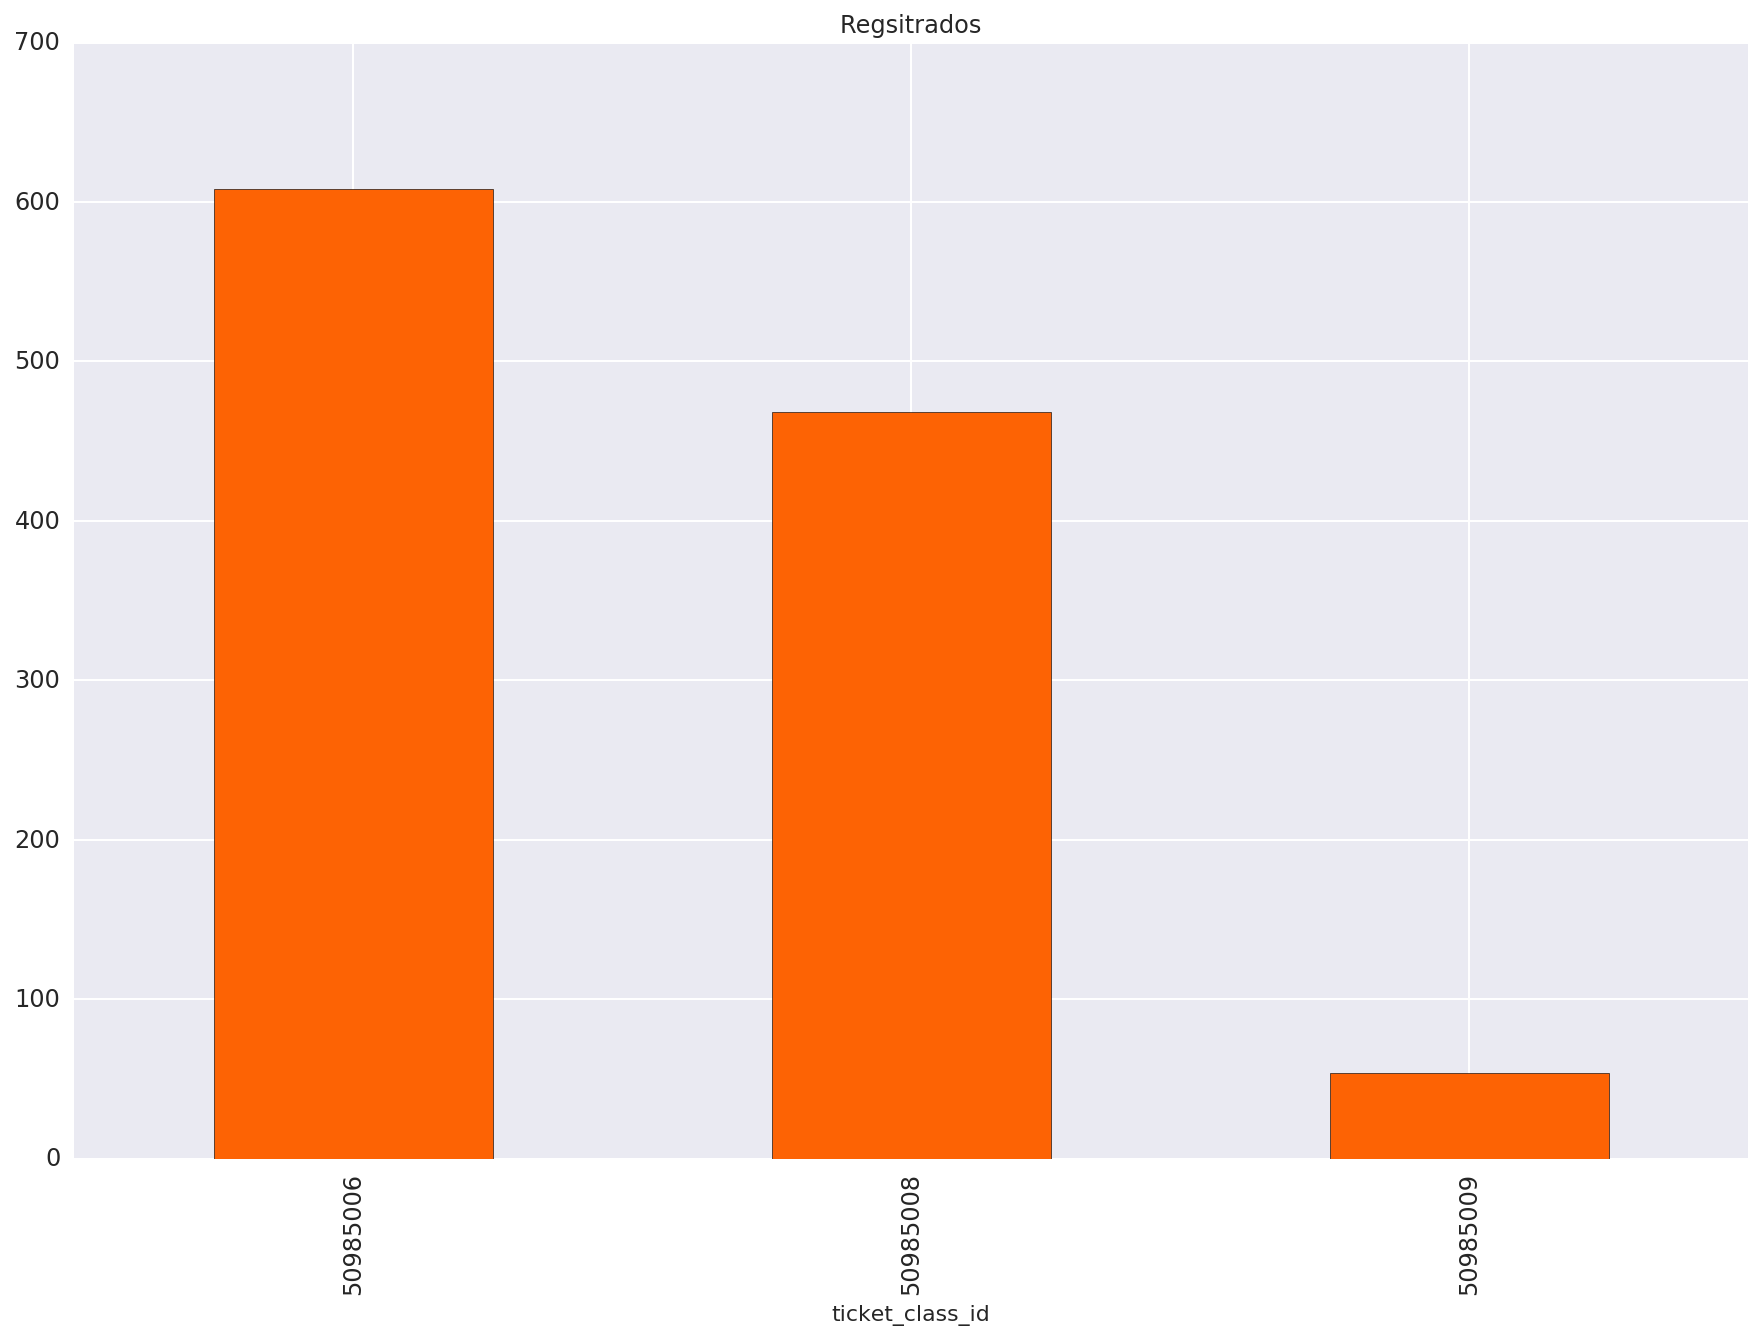

In [48]:
df_ninas.groupby('ticket_class_id')['id'].count()\
.plot(kind='bar', title ="Regsitrados",figsize=(15,10),legend=False, fontsize=12, color='#FD6304')


In [49]:
df_ninas.groupby('ticket_class_id')['id'].count()

ticket_class_id
50985006    608
50985008    468
50985009     54
Name: id, dtype: int64

In [50]:
df_ninas.groupby('ticket_class_id')['id'].count()

ticket_class_id
50985006    608
50985008    468
50985009     54
Name: id, dtype: int64

In [51]:
df_ninas['date']=pd.to_datetime(df_ninas['created'])

In [52]:
df_ninas['date']

0      2016-05-31 16:13:23
1      2016-05-31 16:16:15
2      2016-05-31 16:29:08
3      2016-05-31 16:48:52
4      2016-05-31 16:52:37
5      2016-05-31 17:09:39
6      2016-05-31 18:34:16
7      2016-05-31 18:36:32
8      2016-05-31 18:56:01
9      2016-05-31 19:00:01
10     2016-05-31 20:15:46
11     2016-05-31 20:43:15
12     2016-05-31 23:02:18
13     2016-06-01 00:13:48
14     2016-06-01 01:59:15
15     2016-06-01 14:32:37
16     2016-06-01 18:26:51
17     2016-06-02 02:29:24
18     2016-06-02 10:57:16
19     2016-06-02 14:02:35
20     2016-06-02 15:52:28
21     2016-06-02 18:49:55
23     2016-06-02 18:49:55
25     2016-06-02 19:06:17
27     2016-06-02 19:06:17
29     2016-06-02 19:46:26
31     2016-06-02 19:46:26
33     2016-06-02 19:57:58
35     2016-06-02 19:57:58
37     2016-06-03 00:06:30
               ...        
1470   2016-06-17 16:49:13
1471   2016-06-17 16:49:13
1472   2016-06-17 16:49:13
1473   2016-06-17 16:49:13
1474   2016-06-17 16:49:13
1475   2016-06-17 16:55:27
1

In [53]:
df_students = df_ninas[df_ninas['ticket_class_id']=='50985006']

In [54]:
df_parents = df_ninas[df_ninas['ticket_class_id']=='50985008']

In [55]:
df_staff = df_ninas[df_ninas['ticket_class_id']=='50985009']

In [56]:
sorted(df_staff.drop_duplicates('id')[['profile.name_x','profile.email']].values)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [59]:
df_staff[['profile.name_x','profile.email']]

,profile.name_x,profile.email
0,ANAISABEL DANIELA CONTRERAS HERNANDEZ,Anaisabel3894@Gmail.com
1,Dayana López Vallejos,Dmlv25@gmail.com
2,Nyrka Arvelo,nyrka_arvelo@hotmail.com
3,Johanny Rojas waracao,Johanny-rojas@hotmail.com
4,efren vargas,efr3nv@gmail.com
5,Manuela Luna Alonso,luna_loca98@hotmail.com
6,Steffany Carvajal,Desireecarvajal.v@gmail.con
7,Williams Alviarez,Wilian5mx@hotmail.com
8,Gabriel Braschi,victorbraschi9@hotmail.com
9,Gabriela Rodriguez Laguado,gabylrodriguezl@hotmail.com


In [766]:
df_students[df_students['hembras']==1]['id'].count()

281

In [764]:
df_students[df_students['hembras']==0]['id'].count()

322

In [799]:
df_students[df_students['hembras']==1]['id'].count()*1.0/(df_students[df_students['hembras']==0]['id'].count()+df_students[df_students['hembras']==1]['id'].count())

0.46600331674958539

In [780]:
df_students.loc[df_students['profile.age']>20,'profile.age']=np.NaN

/root/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [995]:
(df_students_colegio.groupby('colegio')['hembras'].sum()/df_students_colegio.groupby('colegio')['hembras'].count())\
##.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#FD6304')
##savefig('fig0.png')

colegio
CHAMPAGNAT      0.547945
IEA EL PEÑÓN    0.439825
Name: hembras, dtype: float64

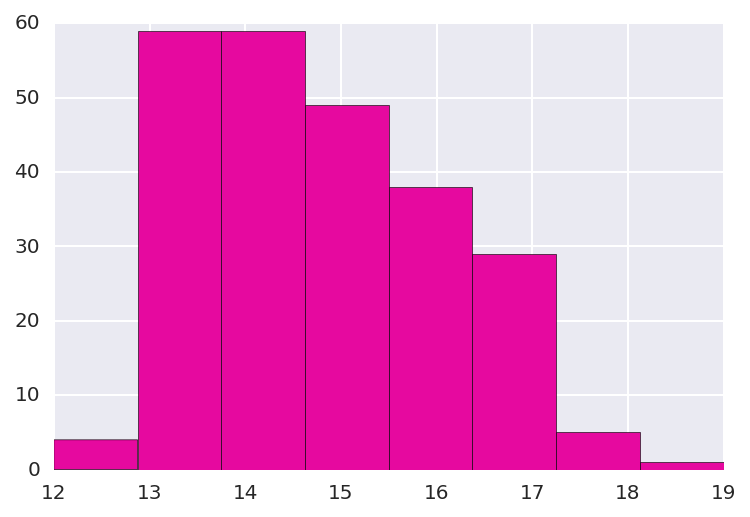

In [933]:
fig1 = df_students[df_students['hembras']==1]['profile.age'].hist(bins=8, color='#E6099F')
savefig('fig1.png')

In [934]:
!ls

co			  eventos.dill	lista_champagnat.csv
data			  fig1.png	lista_iea.csv
EventBrite Metrics.ipynb  ig_iea.csv	registrados.dill


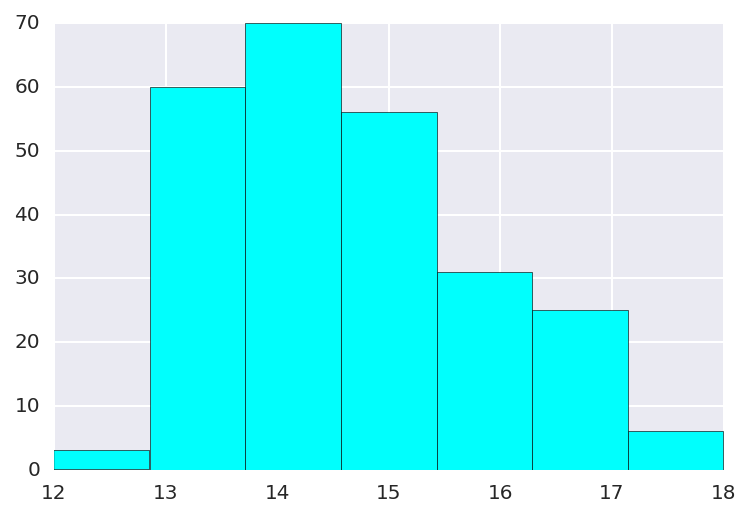

In [935]:
fig2 = df_students[df_students['hembras']==0]['profile.age'].hist(bins=7, color='#00fffd')
savefig('fig2.png')

In [814]:
df_students_colegio = pd.merge(df_students,df_colegios, on='id')

In [818]:
df_students_colegio = df_students_colegio.drop_duplicates('id')

In [1161]:
df_lista = pd.merge(df_students_colegio, df_curso, on='id', how='left')

In [1162]:
df_lista

,id,event_id,order_id,created,profile.age,profile.cell_phone,profile.email,profile.first_name,profile.gender,profile.last_name,...,hembras,level_0,level_1,answer,question,question_id,type,colegio,curso,seccion
0,660038061,25790656548,523638841,2016-06-02T18:49:55Z,14,04120108005,danlandaeta110901@gmail.com,daniel,NaN,Landaeta,...,0,660038061,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,8vo,NaN
1,660047732,25790656548,523645655,2016-06-02T19:06:17Z,14,04120108005,danlandaeta110901@gmail.com,Daniel,NaN,Landaeta,...,0,660047732,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,8vo,NaN
2,660067501,25790656548,523660639,2016-06-02T19:46:26Z,14,04165170467,andreasuso57@gmail.com,Andrea,NaN,Suso,...,1,660067501,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,7mo,C
3,660072597,25790656548,523664799,2016-06-02T19:57:58Z,14,04149041994,adrian.lopezo@gmail.com,adrian,NaN,lopez,...,0,660072597,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,8vo,NaN
4,660158036,25790656548,523733549,2016-06-03T00:06:30Z,17,04242099021,lauraalejandraiovane@gmail.com,laura,NaN,iovane,...,1,660158036,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,I diversificada,NaN
5,660160896,25790656548,523735848,2016-06-03T00:18:21Z,17,0414990218,lauraalejandraiovane@gmail.com,Laura,NaN,iovane,...,1,660160896,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,I diversificada,NaN
6,660174919,25790656548,523747177,2016-06-03T01:13:50Z,18,04141868371,yncv1305@gmail.com,Yamila,NaN,Vilera,...,1,660174919,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,II diversificada,NaN
7,660178416,25790656548,523750013,2016-06-03T01:28:05Z,17,04242542425,annylp11@gmail.com,Anny,NaN,Lopez,...,1,660178416,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,II diversificada,NaN
8,660180901,25790656548,523752026,2016-06-03T01:37:45Z,17,04149340476,mafe.tovar.vazquez@gmail.com,Maria Fernanda,NaN,Tovar,...,1,660180901,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,II diversificada,NaN
9,660182369,25790656548,523753241,2016-06-03T01:43:44Z,17,04126390982,barbi.pereira@hotmail.com,Barbara,NaN,Pereira,...,1,660182369,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,CHAMPAGNAT,II diversificada,NaN


In [1163]:
df_lista = pd.merge(df_lista, df_igusername, on='id', how='left')

In [1164]:
df_lista = pd.merge(df_lista, df_schusername, on='id', how='left')

In [1165]:
df_lista = df_lista.drop_duplicates('id')

In [1166]:
df_lista.columns

Index([                u'id',           u'event_id',           u'order_id',
                  u'created',        u'profile.age', u'profile.cell_phone',
            u'profile.email', u'profile.first_name',     u'profile.gender',
        u'profile.last_name',     u'profile.name_x',           u'quantity',
                 u'refunded',    u'ticket_class_id',            u'answers',
                u'order_num',               u'date',         u'first_name',
                 u'lastname',              u'ninas',     u'profile.name_y',
                   u'female',            u'hembras',          u'level_0_x',
                u'level_1_x',           u'answer_x',         u'question_x',
            u'question_id_x',             u'type_x',            u'colegio',
                    u'curso',            u'seccion',          u'level_0_y',
                u'level_1_y',           u'answer_y',         u'question_y',
            u'question_id_y',             u'type_y',            u'ig_name',
            

In [1167]:
df_lista = df_lista[['colegio', 'curso', 'seccion','profile.name_x',  'profile.email','ig_name', 'sch_name' ]]

In [1172]:
df_lista.columns=['colegio', 'curso', 'seccion','nombre', 'email', 'ig','snap']

In [1175]:
df_lista

,colegio,curso,seccion,nombre,email,ig,snap
0,CHAMPAGNAT,8vo,NaN,daniel Landaeta,danlandaeta110901@gmail.com,danielandaetaprior,danilandix
1,CHAMPAGNAT,8vo,NaN,Daniel Landaeta,danlandaeta110901@gmail.com,danielandaetaprior,danilandaeta
2,CHAMPAGNAT,7mo,C,Andrea Suso,andreasuso57@gmail.com,andrea1a3,andrea1a3
3,CHAMPAGNAT,8vo,NaN,adrian lopez,adrian.lopezo@gmail.com,chichilopez19,NaN
4,CHAMPAGNAT,I diversificada,NaN,laura iovane,lauraalejandraiovane@gmail.com,NaN,NaN
5,CHAMPAGNAT,I diversificada,NaN,Laura iovane,lauraalejandraiovane@gmail.com,liss_ve,NaN
6,CHAMPAGNAT,II diversificada,NaN,Yamila Vilera,yncv1305@gmail.com,yamincv,yncvv
7,CHAMPAGNAT,II diversificada,NaN,Anny Lopez,annylp11@gmail.com,annylopezp,annylopezp
8,CHAMPAGNAT,II diversificada,NaN,Maria Fernanda Tovar,mafe.tovar.vazquez@gmail.com,mafetovarv,NaN
9,CHAMPAGNAT,II diversificada,NaN,Barbara Pereira,barbi.pereira@hotmail.com,barbara_pl,NaN


In [1176]:
df_lista.to_csv('lista_jun16.csv', encoding='utf-8')

In [822]:
pd.crosstab(df_students_colegio.colegio,df_students_colegio['profile.age'])



profile.age,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
colegio,,,,,,,,
CHAMPAGNAT,2,27,18,19,6,24,7,1
IEA EL PEÑÓN,5,94,112,86,63,31,4,0


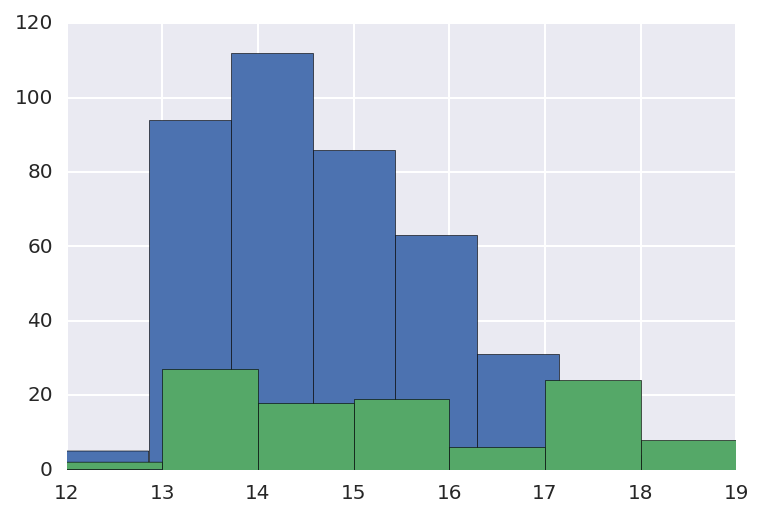

In [939]:
df_students_colegio[df_students_colegio['colegio']=='IEA EL PEÑÓN']['profile.age'].hist(bins=7)
df_students_colegio[df_students_colegio['colegio']=='CHAMPAGNAT']['profile.age'].hist(bins=7)
savefig('fig3.png')

In [827]:
df_students_colegio[df_students_colegio['colegio']=='IEA EL PEÑÓN']['id'].count()

462

In [828]:
df_students_colegio[df_students_colegio['colegio']=='CHAMPAGNAT']['id'].count()

146

In [ ]:
colegios = ['CHAMPAGNAT','SAN JOSÉ DE CALASANZ','COLEGIO SAN VICENTE DE PAÚL','IEA EL PEÑÓN']

In [1001]:
4*40*5

800

### Teléfonos

In [1034]:
phones = df_students_colegio['profile.cell_phone'].dropna().values

In [1042]:
carriers=[]
for ph in phones:
    try:
        if '414'in ph or '424'in ph:
            carriers.append('Movistar')
        elif '412'in ph:
            carriers.append('Digitel')
        elif '416'in ph or '426'in ph:
            carriers.append('Movilnet')
        else:
            carriers.append(np.NaN)
    except ValueError:
        carriers.append(np.NaN)


In [1081]:
df_telf = df_students_colegio[['id','profile.cell_phone', 'colegio']].dropna()

In [1082]:
df_telf.count()

id                    485
profile.cell_phone    485
colegio               485
dtype: int64

In [1083]:
len(carriers)

485

In [1084]:
df_telf['carriers']=carriers

In [1085]:
table_telf = pd.crosstab(df_telf.colegio, df_telf.carriers)

In [1087]:
table_telf =table_telf.reset_index(drop=False)

In [1088]:
table_telf

carriers,colegio,Digitel,Movilnet,Movistar
0,CHAMPAGNAT,29,22,79
1,IEA EL PEÑÓN,71,33,247


In [1104]:
Movistar = table_telf.groupby('colegio')['Movistar'].sum()\
/(table_telf.groupby('colegio')['Movistar'].sum()+\
  table_telf.groupby('colegio')['Digitel'].sum()+\
  table_telf.groupby('colegio')['Movilnet'].sum())
Digitel = table_telf.groupby('colegio')['Digitel'].sum()\
/(table_telf.groupby('colegio')['Movistar'].sum()+\
  table_telf.groupby('colegio')['Digitel'].sum()+\
  table_telf.groupby('colegio')['Movilnet'].sum())
Movilnet = table_telf.groupby('colegio')['Movilnet'].sum()\
/(table_telf.groupby('colegio')['Movistar'].sum()+\
  table_telf.groupby('colegio')['Digitel'].sum()+\
  table_telf.groupby('colegio')['Movilnet'].sum())

In [1113]:
table_telf['movistar']=Movistar.values
table_telf['digitel']=Digitel.values
table_telf['movilnet']=Movilnet.values

In [1114]:
table_telf

carriers,colegio,Digitel,Movilnet,Movistar,movistar,digitel,movilnet
0,CHAMPAGNAT,29,22,79,0.607692,0.223077,0.169231
1,IEA EL PEÑÓN,71,33,247,0.703704,0.202279,0.094017


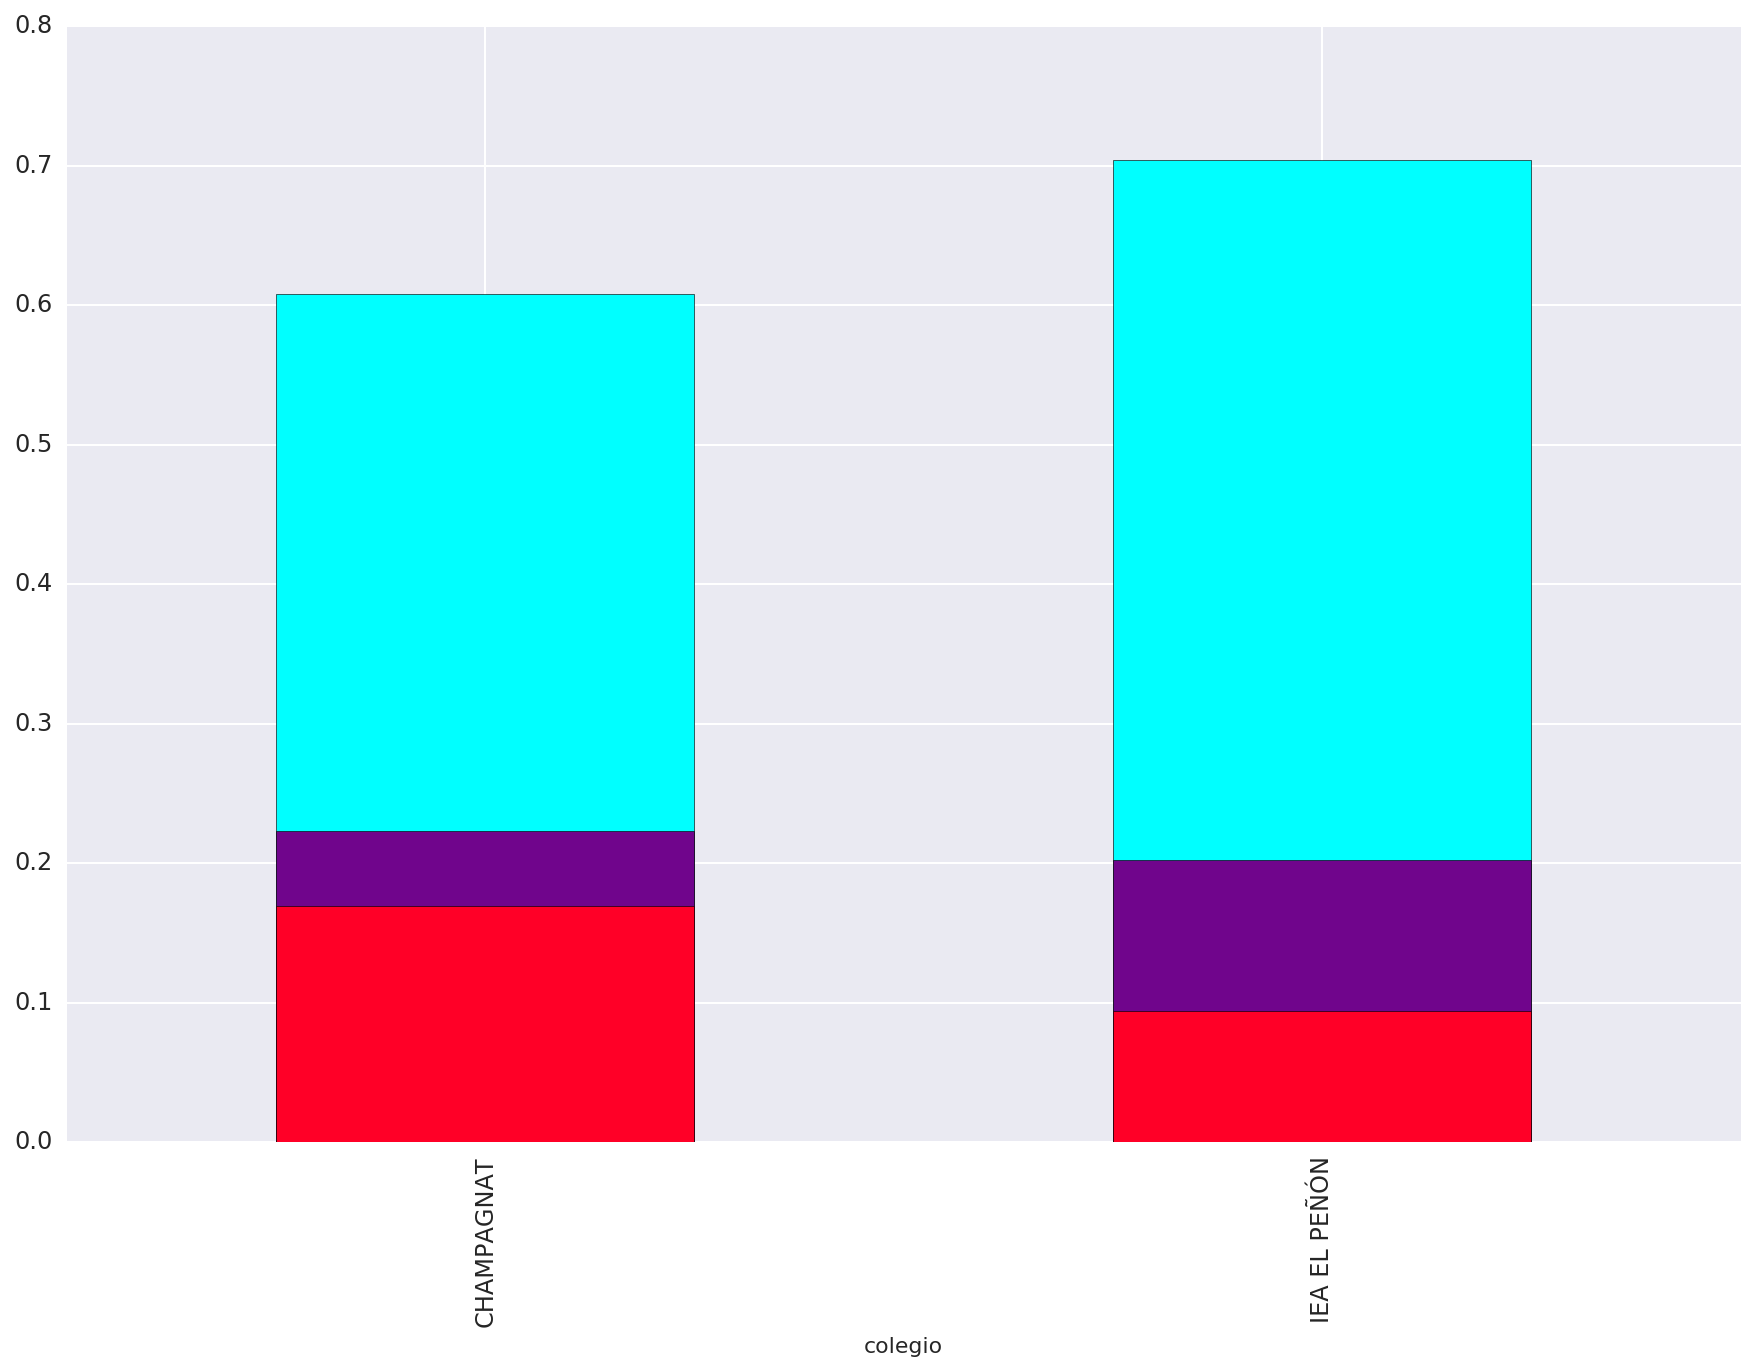

In [1106]:
Movistar.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#00FFFF')
Digitel.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#70058C')
Movilnet.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#ff0027')

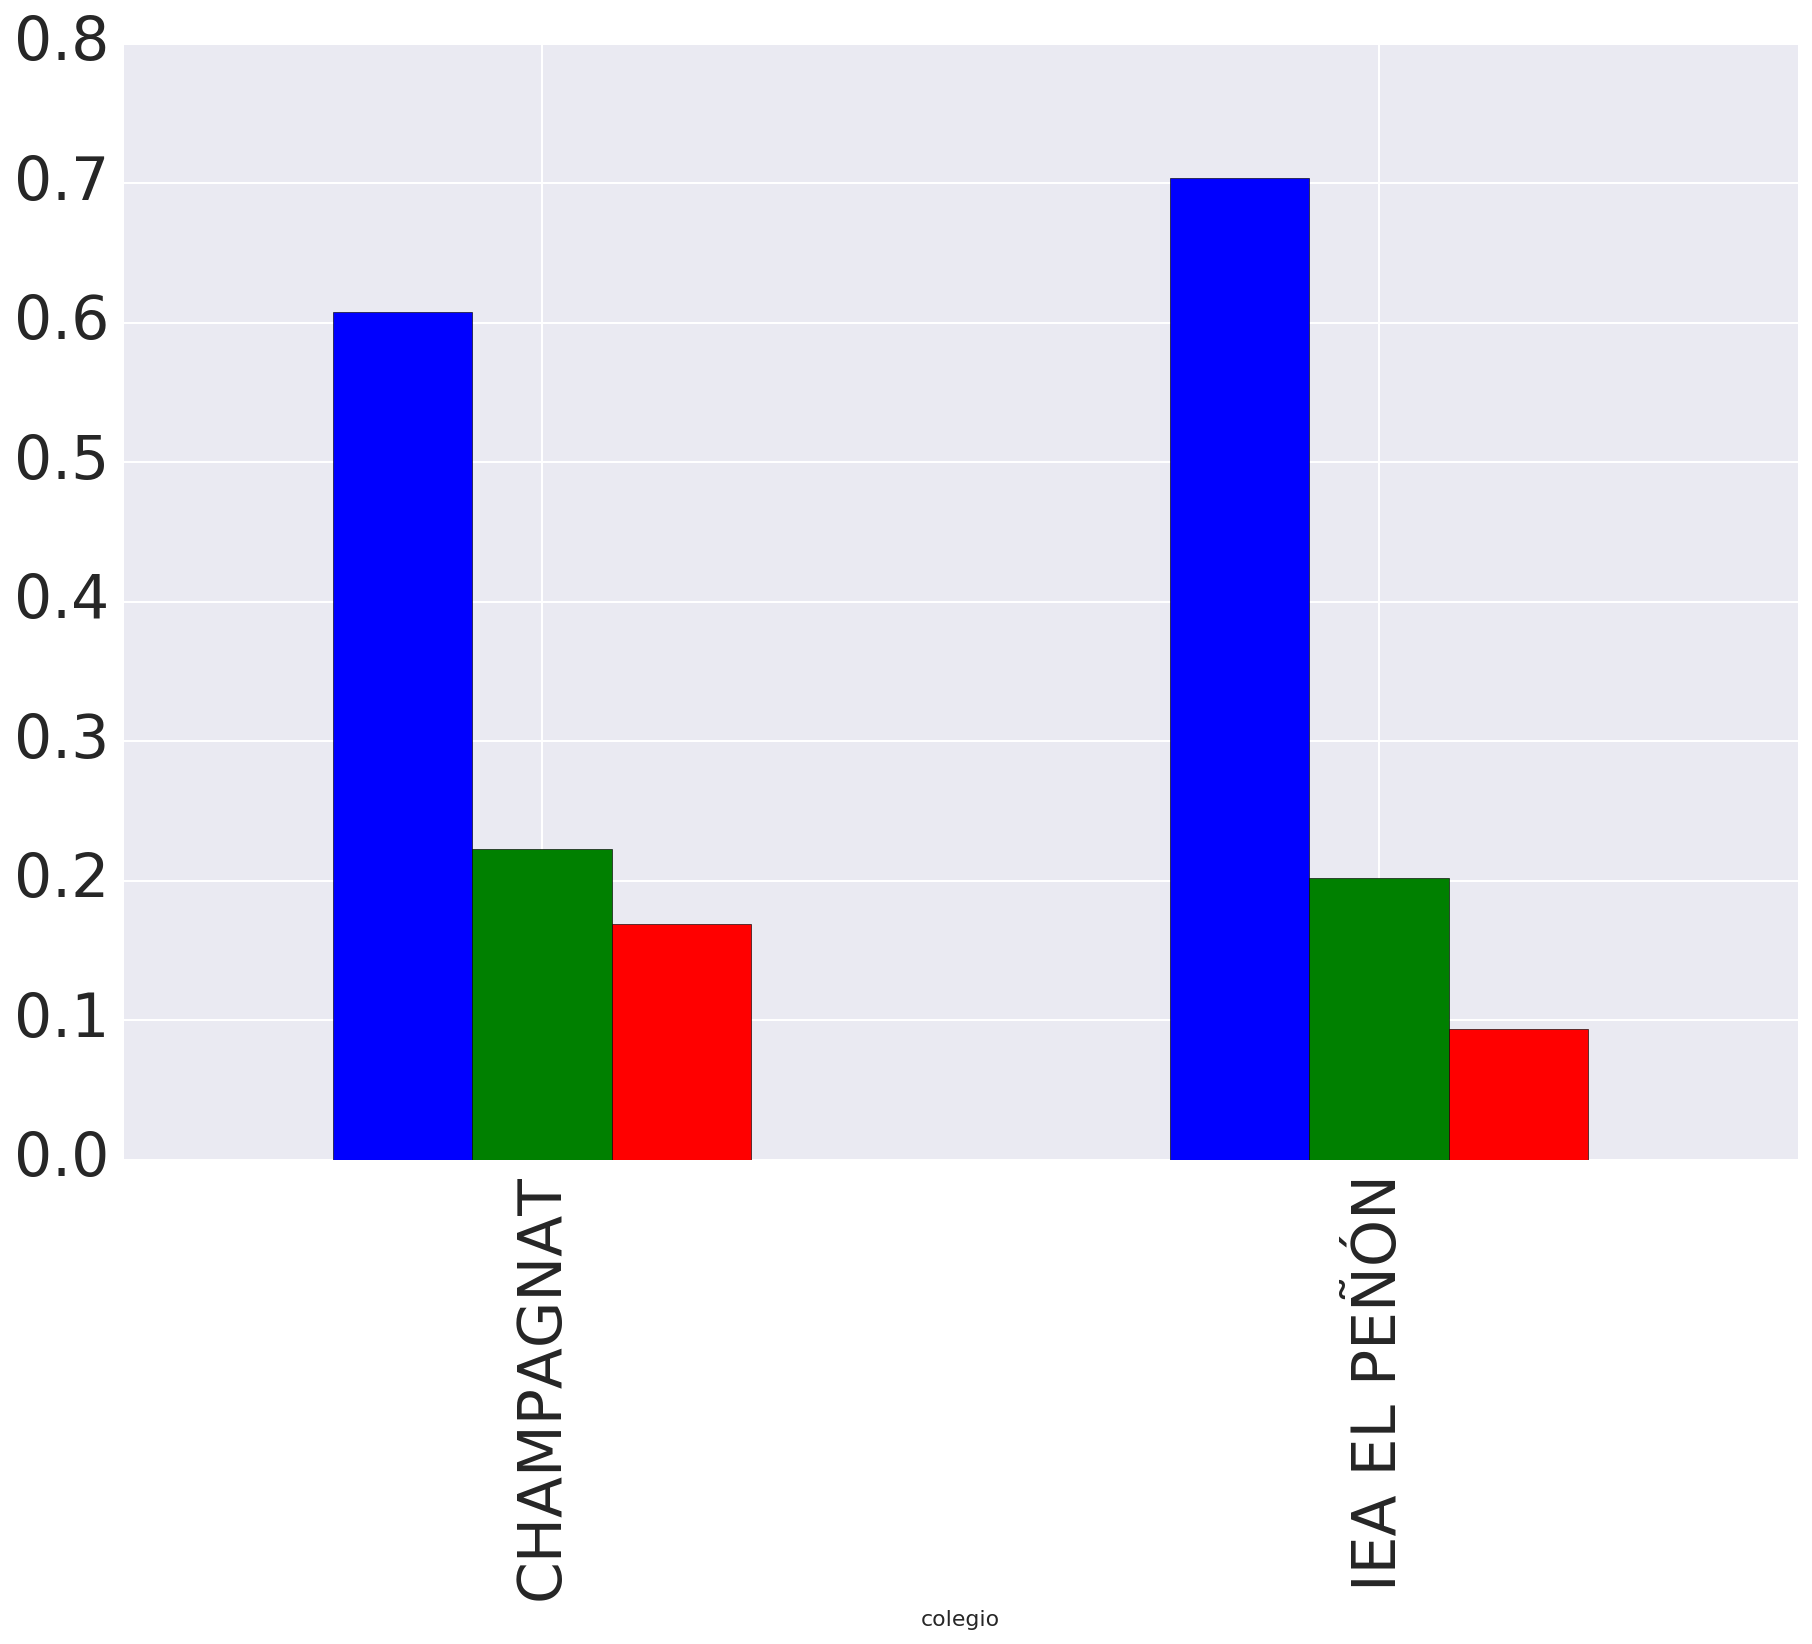

In [1117]:
(table_telf.groupby('colegio')[['movistar','digitel','movilnet']].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=30)
savefig('fig20.png')

ValueError: to_rgba: Invalid rgba arg "#"
to_rgb: Invalid rgb arg "#"
invalid hex color string "#"

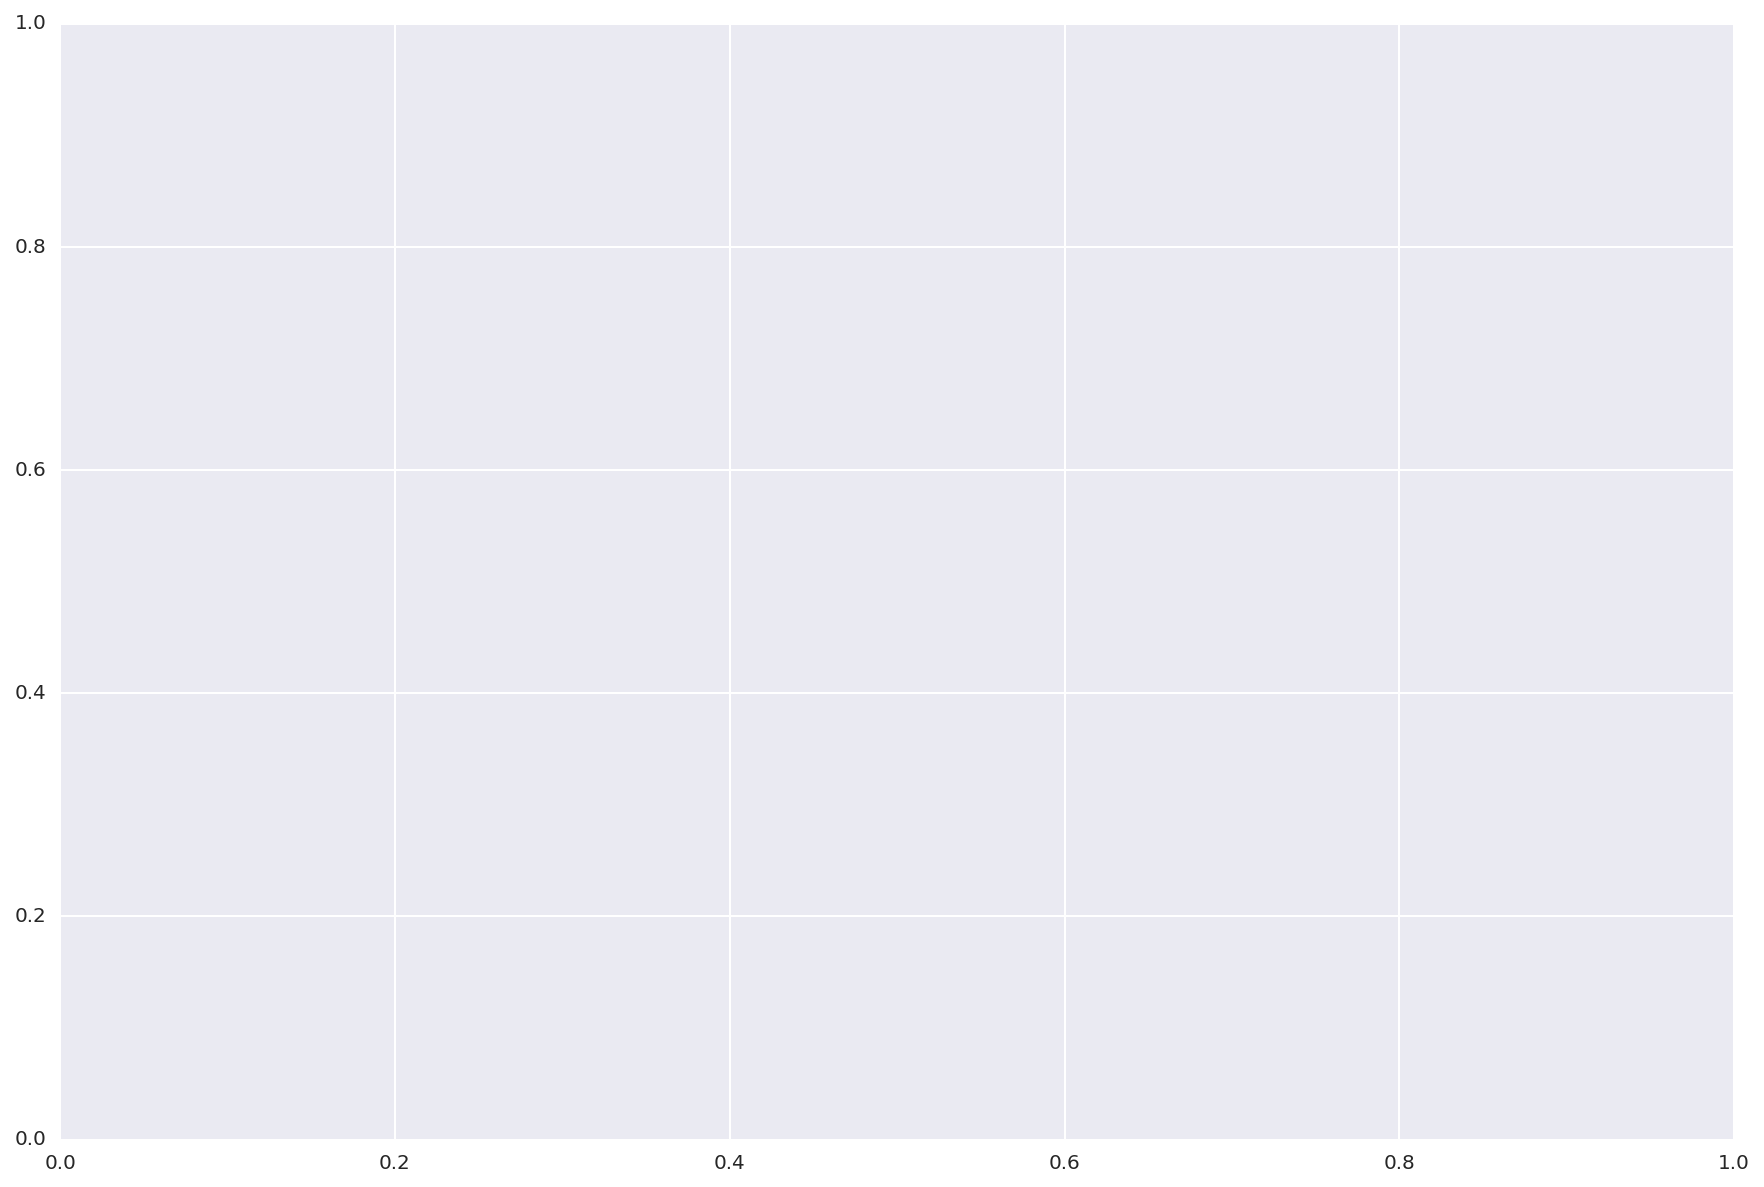

In [1064]:
pd.crosstab(df_telf.colegio, df_telf.carriers).plot(kind='bar', title ="",figsize=(15,10),legend=True, fontsize=12, color='#ffff00')

### Snapchat

In [484]:
preguntas_sch = [u'\xbfQu\xe9 prefieres entre Snapchat e Instagram?',
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_sch]

In [485]:
df_sch = pd.concat(frames).dropna()

In [829]:
df_sch = df_sch.drop_duplicates('id')

In [830]:
df_sch['answer'].count()

662

In [486]:
sch_answers = df_sch['answer']

In [508]:
sch_vs_ig = []
sch = []

for answer in sch_answers:
    if 'No tengo' in answer:
        sch.append(0)
        sch_vs_ig.append(0)
    elif 'Instagram' in answer:
        sch_vs_ig.append(0)
        sch.append(1)
    else:
        sch_vs_ig.append(1)
        sch.append(1)

In [509]:
df_sch['sch_vs_ig']=sch_vs_ig
df_sch['sch']=sch

###### Penetración Snapchat

In [510]:
df_sch['sch'].sum()*1.0/df_sch['sch'].count()

0.5755287009063444

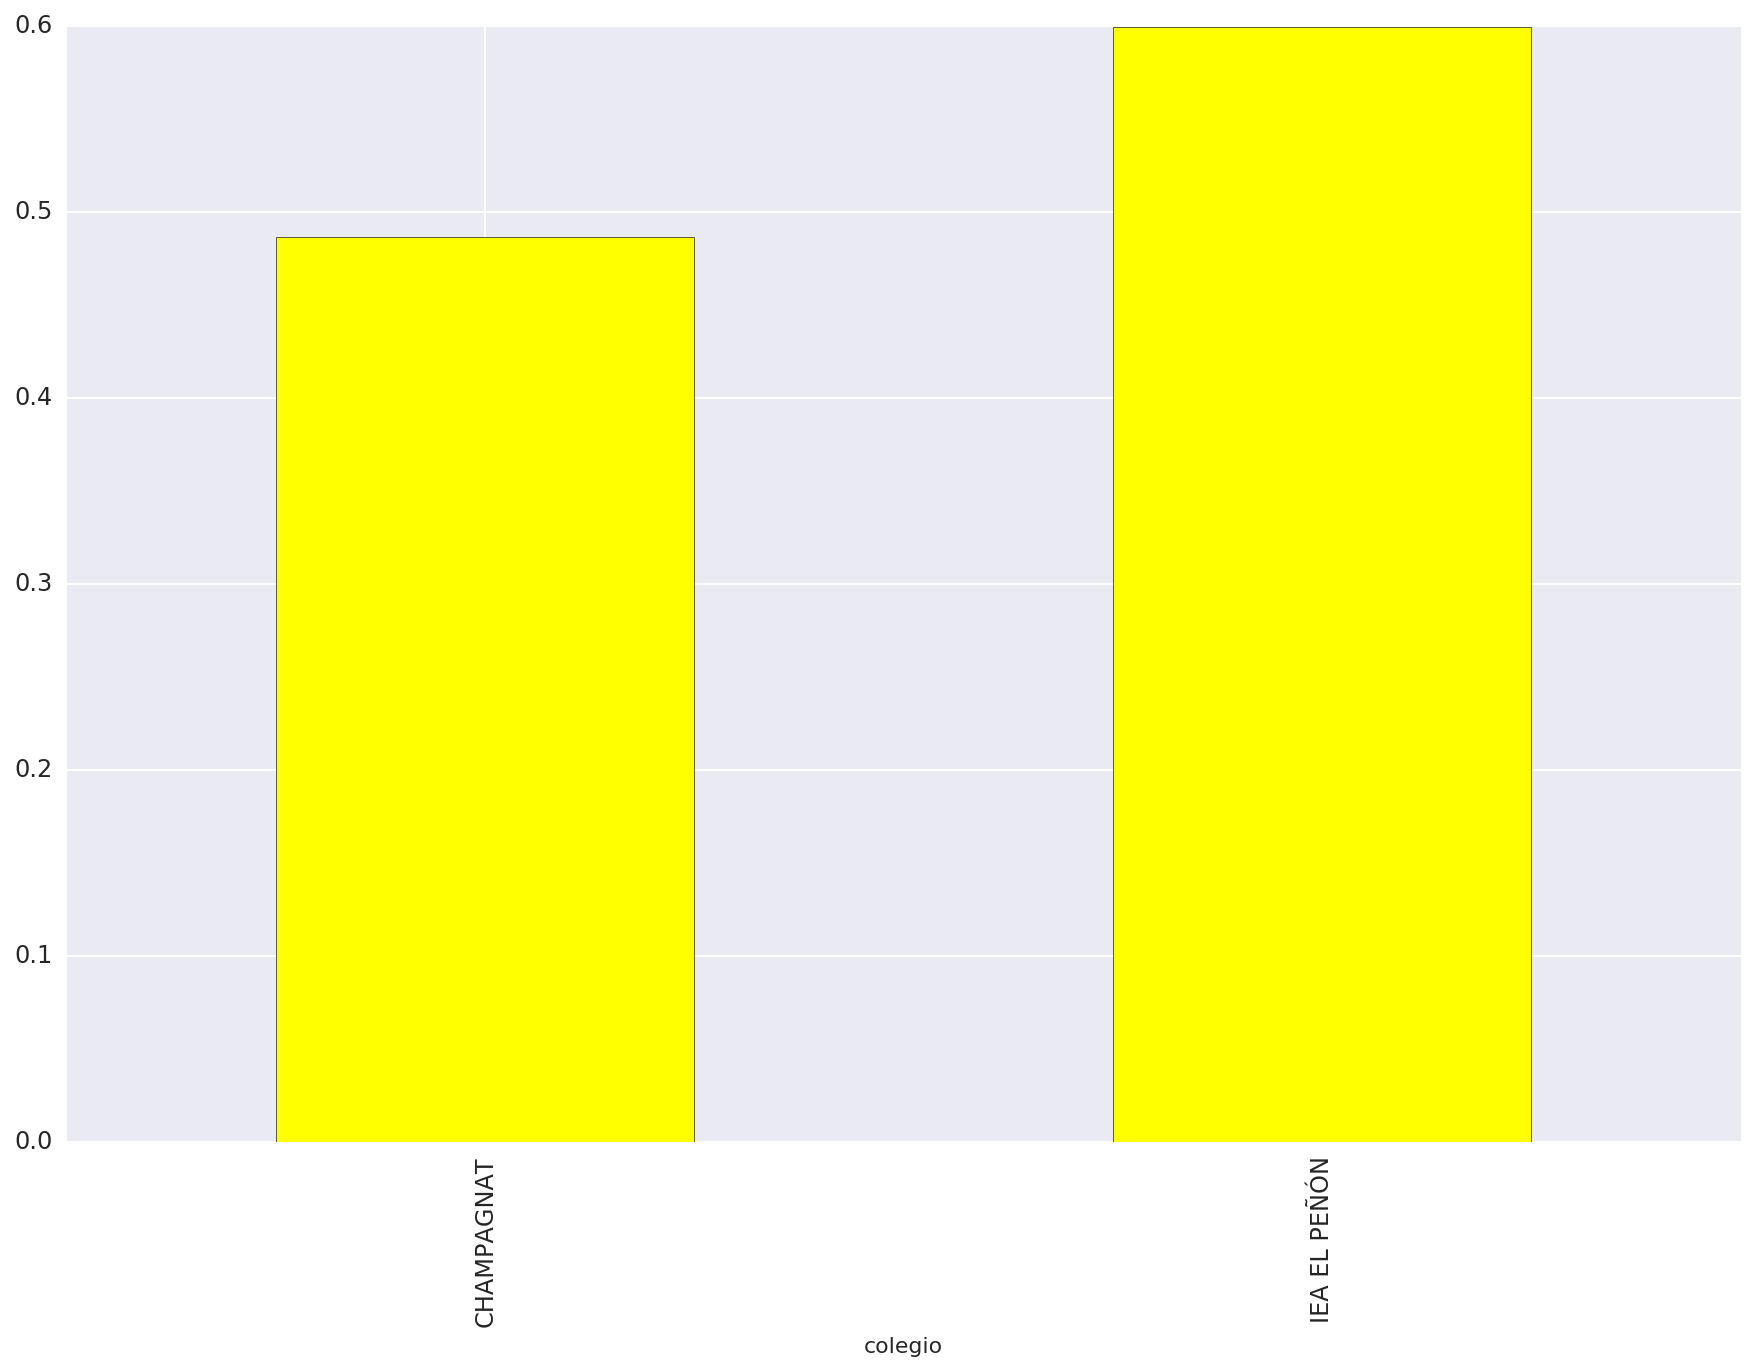

In [945]:
fig4 = (df_sch_colegios.groupby('colegio')['sch'].sum()*1.0\
/df_sch_colegios.groupby('colegio')['sch'].count()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#ffff00')
savefig('fig4.png')

In [835]:
df_sch_colegios[df_sch_colegios['colegio']=='CHAMPAGNAT']['sch'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['colegio']=='CHAMPAGNAT']['sch'].count()


0.4863013698630137

In [836]:
df_sch_colegios[df_sch_colegios['colegio']=='IEA EL PEÑÓN']['sch'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['colegio']=='IEA EL PEÑÓN']['sch'].count()


0.5995670995670995

In [841]:
df_sch_colegios[df_sch_colegios['hembras']== 1]['sch'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['hembras']==1]['sch'].count()

0.7224199288256228

In [842]:
df_sch_colegios[df_sch_colegios['hembras']== 0]['sch'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['hembras']==0]['sch'].count()

0.4440993788819876

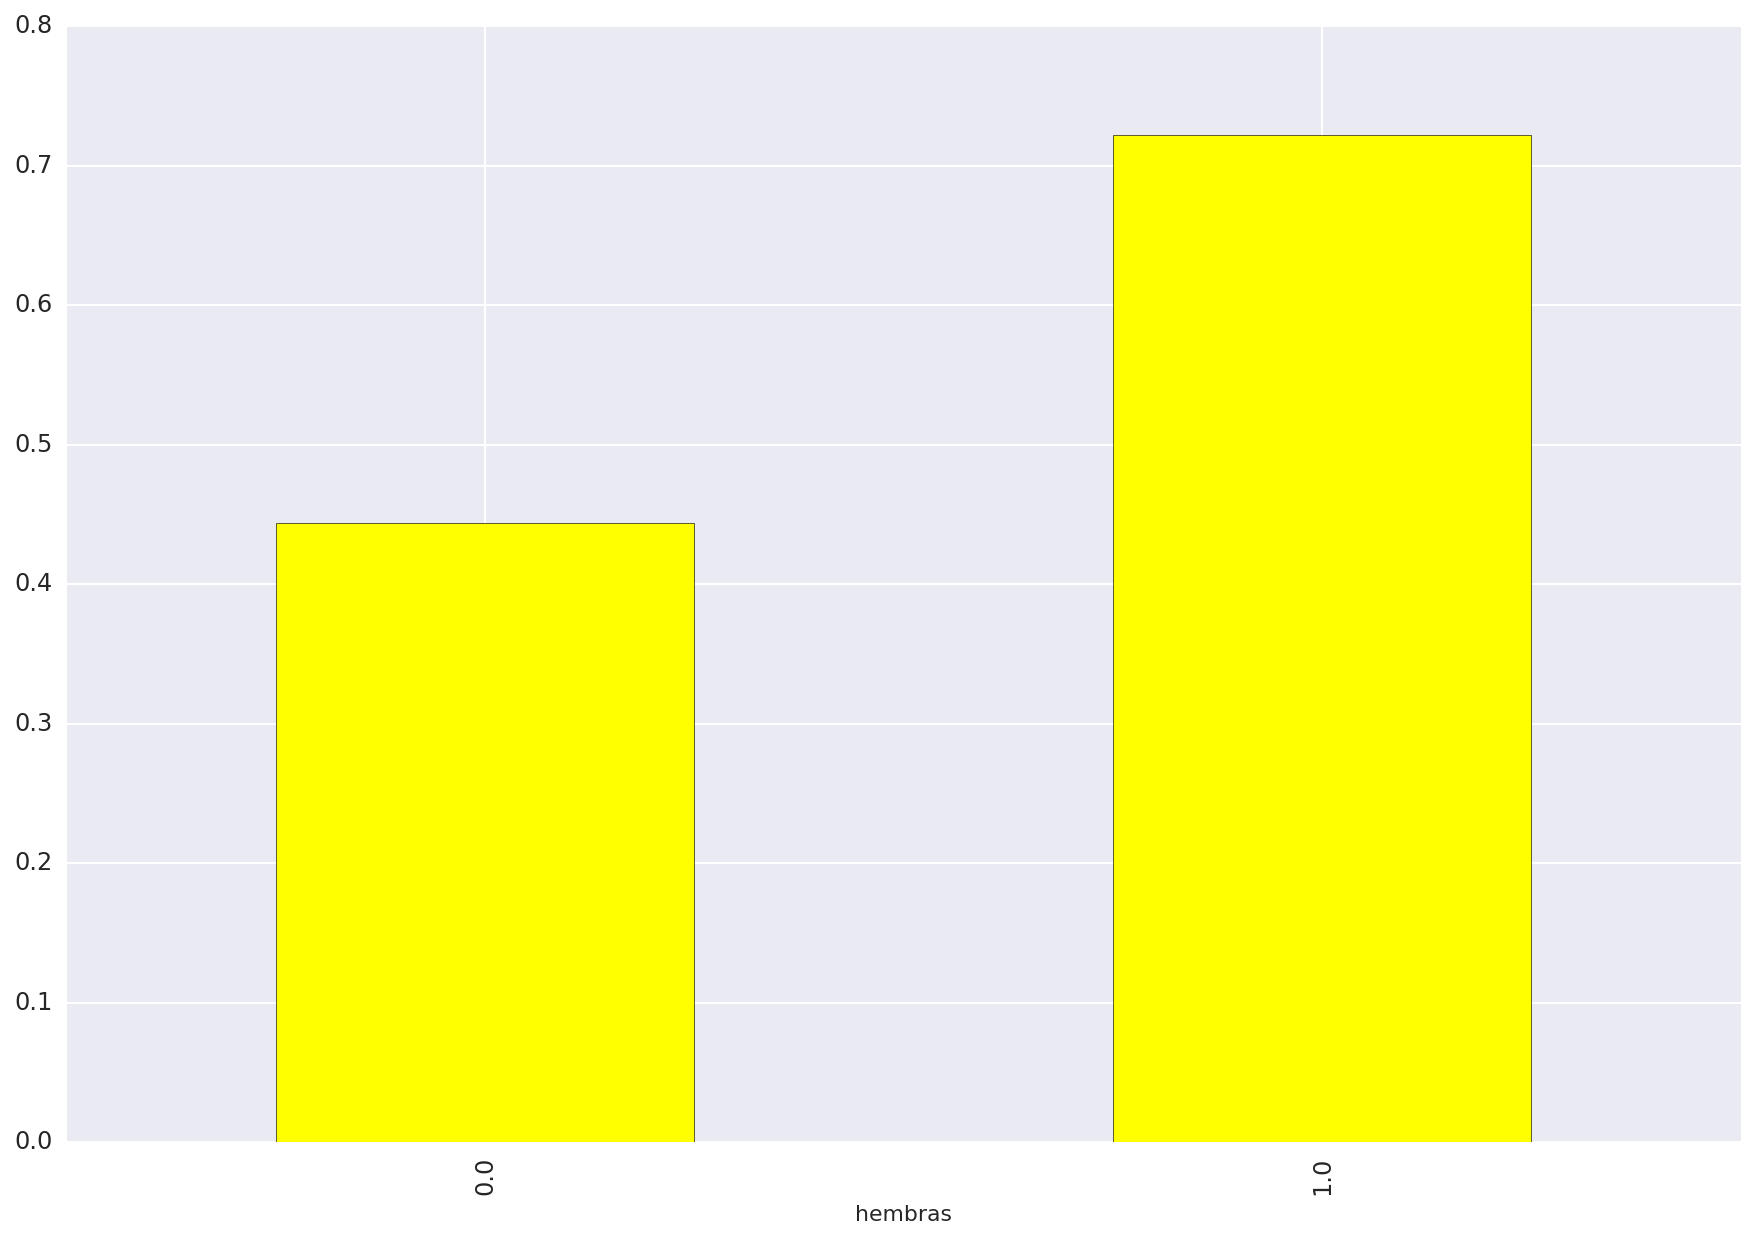

In [946]:
fig5 = (df_sch_colegios.groupby('hembras')['sch'].sum()*1.0\
/df_sch_colegios.groupby('hembras')['sch'].count()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#ffff00')
savefig('fig5.png')

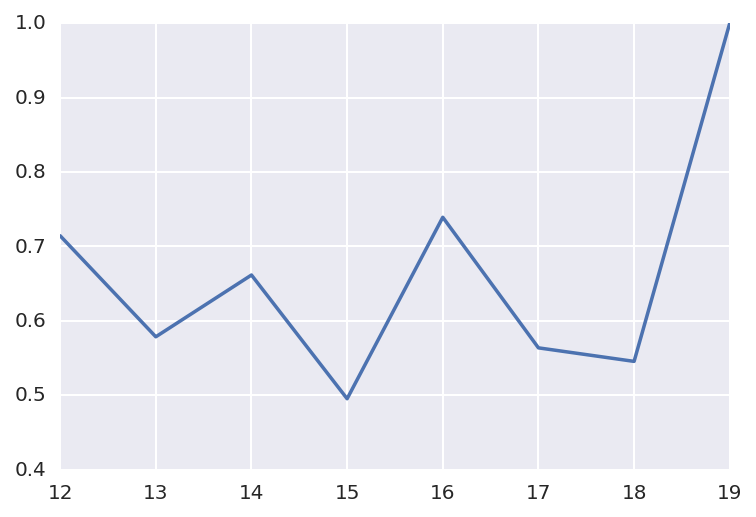

In [947]:
plot(df_sch_colegios.groupby('profile.age')['sch'].sum()*1.0\
/df_sch_colegios.groupby('profile.age')['sch'].count())
savefig('fig6.png')

In [1126]:
df_sch_colegios.count()

level_0_x             608
level_1_x             608
answer_x              608
question_x            608
question_id_x         608
type_x                608
id                    608
sch_vs_ig             608
sch                   608
event_id              608
order_id              608
created               608
profile.age           499
profile.cell_phone    485
profile.email         587
profile.first_name    608
profile.gender        371
profile.last_name     608
profile.name_x        608
quantity              608
refunded              608
ticket_class_id       608
answers               608
order_num             608
date                  237
first_name            237
lastname              237
ninas                 237
profile.name_y        237
female                366
hembras               603
level_0_y             608
level_1_y             608
answer_y              608
question_y            608
question_id_y         608
type_y                608
colegio               608
dtype: int64

###### Preferencia Snapchat

In [840]:
df_sch['sch_vs_ig'].sum()*1.0/df_sch['sch'].sum()

0.4068241469816273

In [837]:
df_sch_colegios[df_sch_colegios['colegio']=='CHAMPAGNAT']['sch_vs_ig'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['colegio']=='CHAMPAGNAT']['sch'].sum()


0.28169014084507044

In [838]:
df_sch_colegios[df_sch_colegios['colegio']=='IEA EL PEÑÓN']['sch_vs_ig'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['colegio']=='IEA EL PEÑÓN']['sch'].sum()


0.45126353790613716

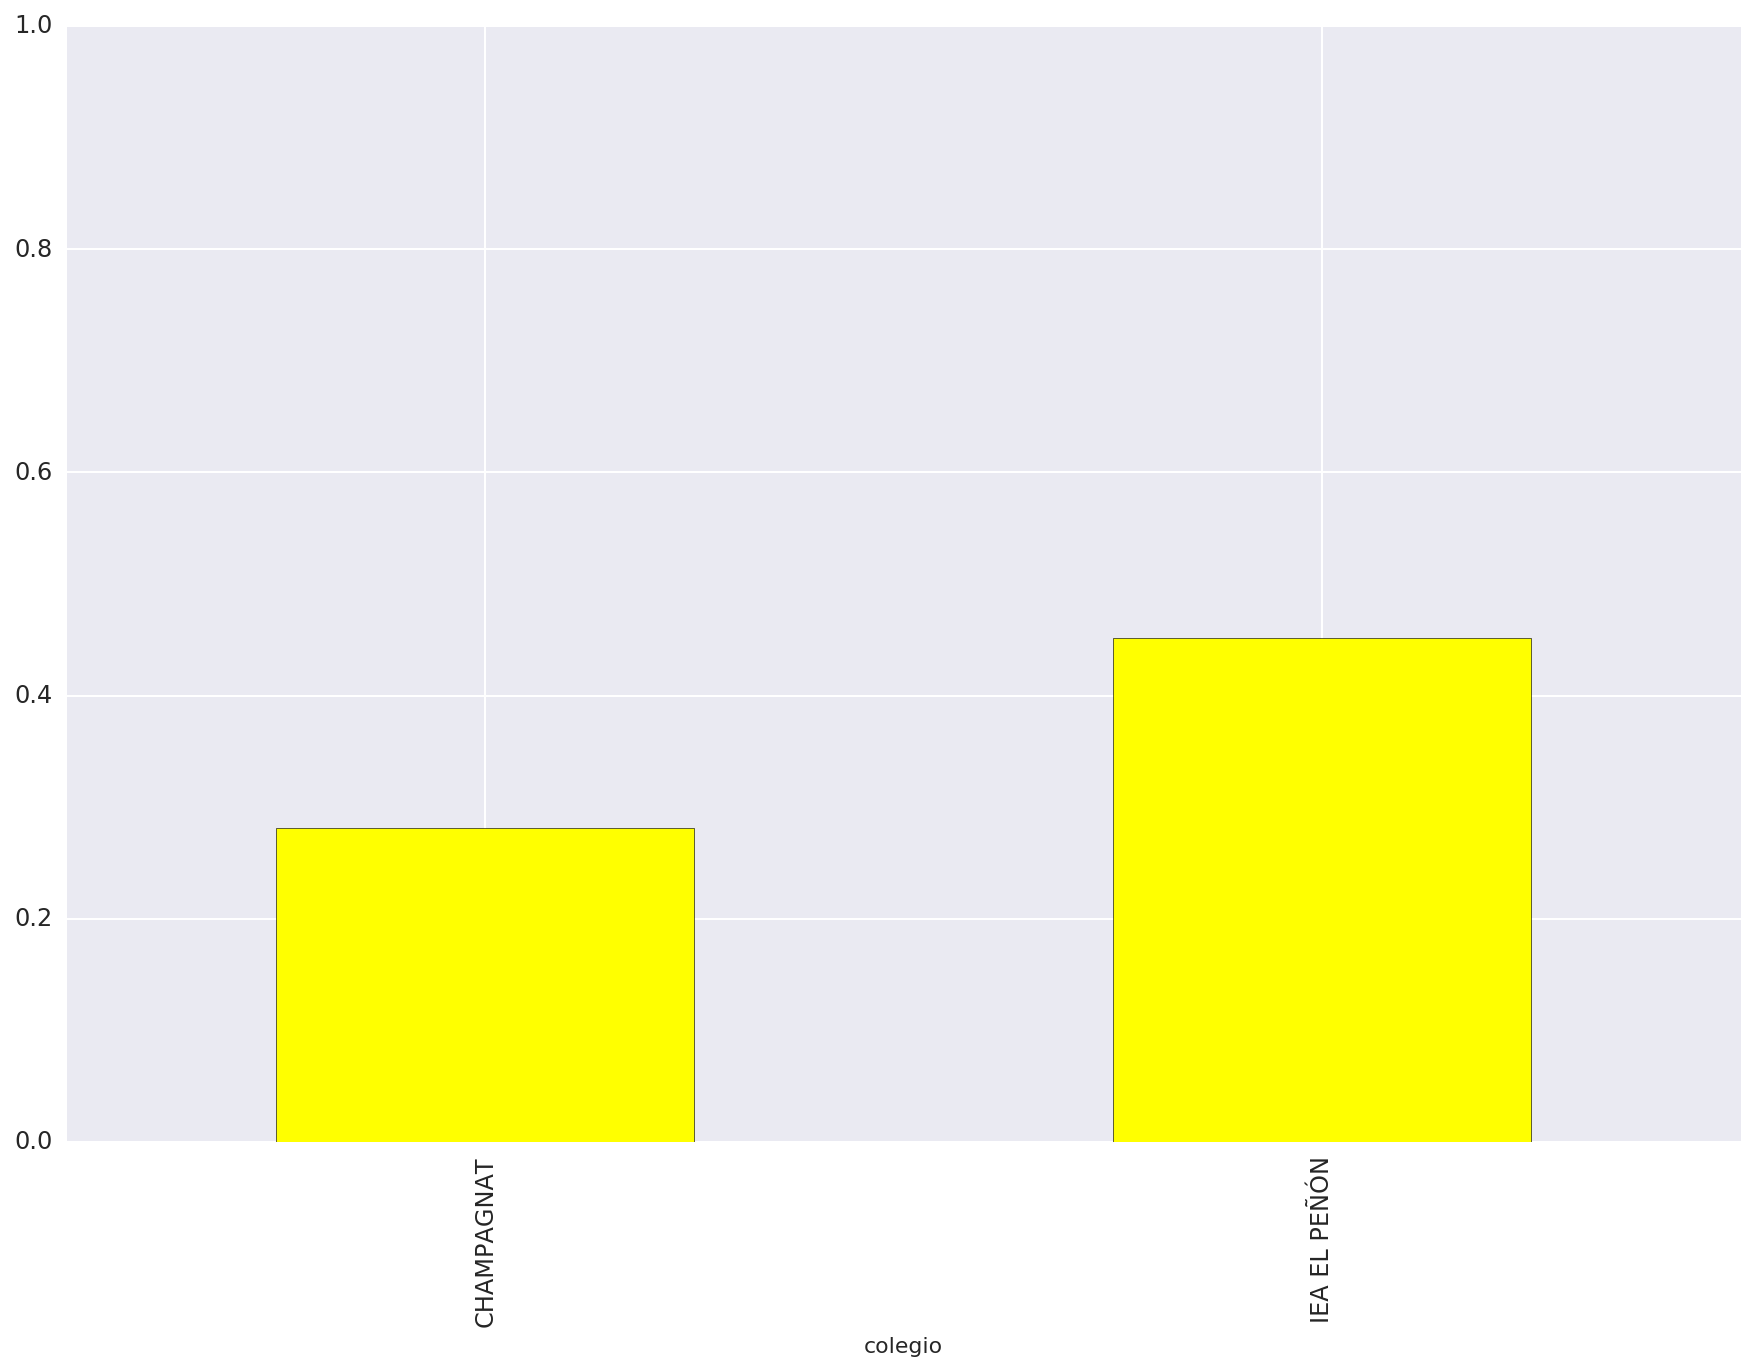

In [1006]:
fig7 = (df_sch_colegios.groupby('colegio')['sch_vs_ig'].sum()*1.0\
/df_sch_colegios.groupby('colegio')['sch'].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#ffff00')
plt.ylim((0,1))
savefig('fig7.png')

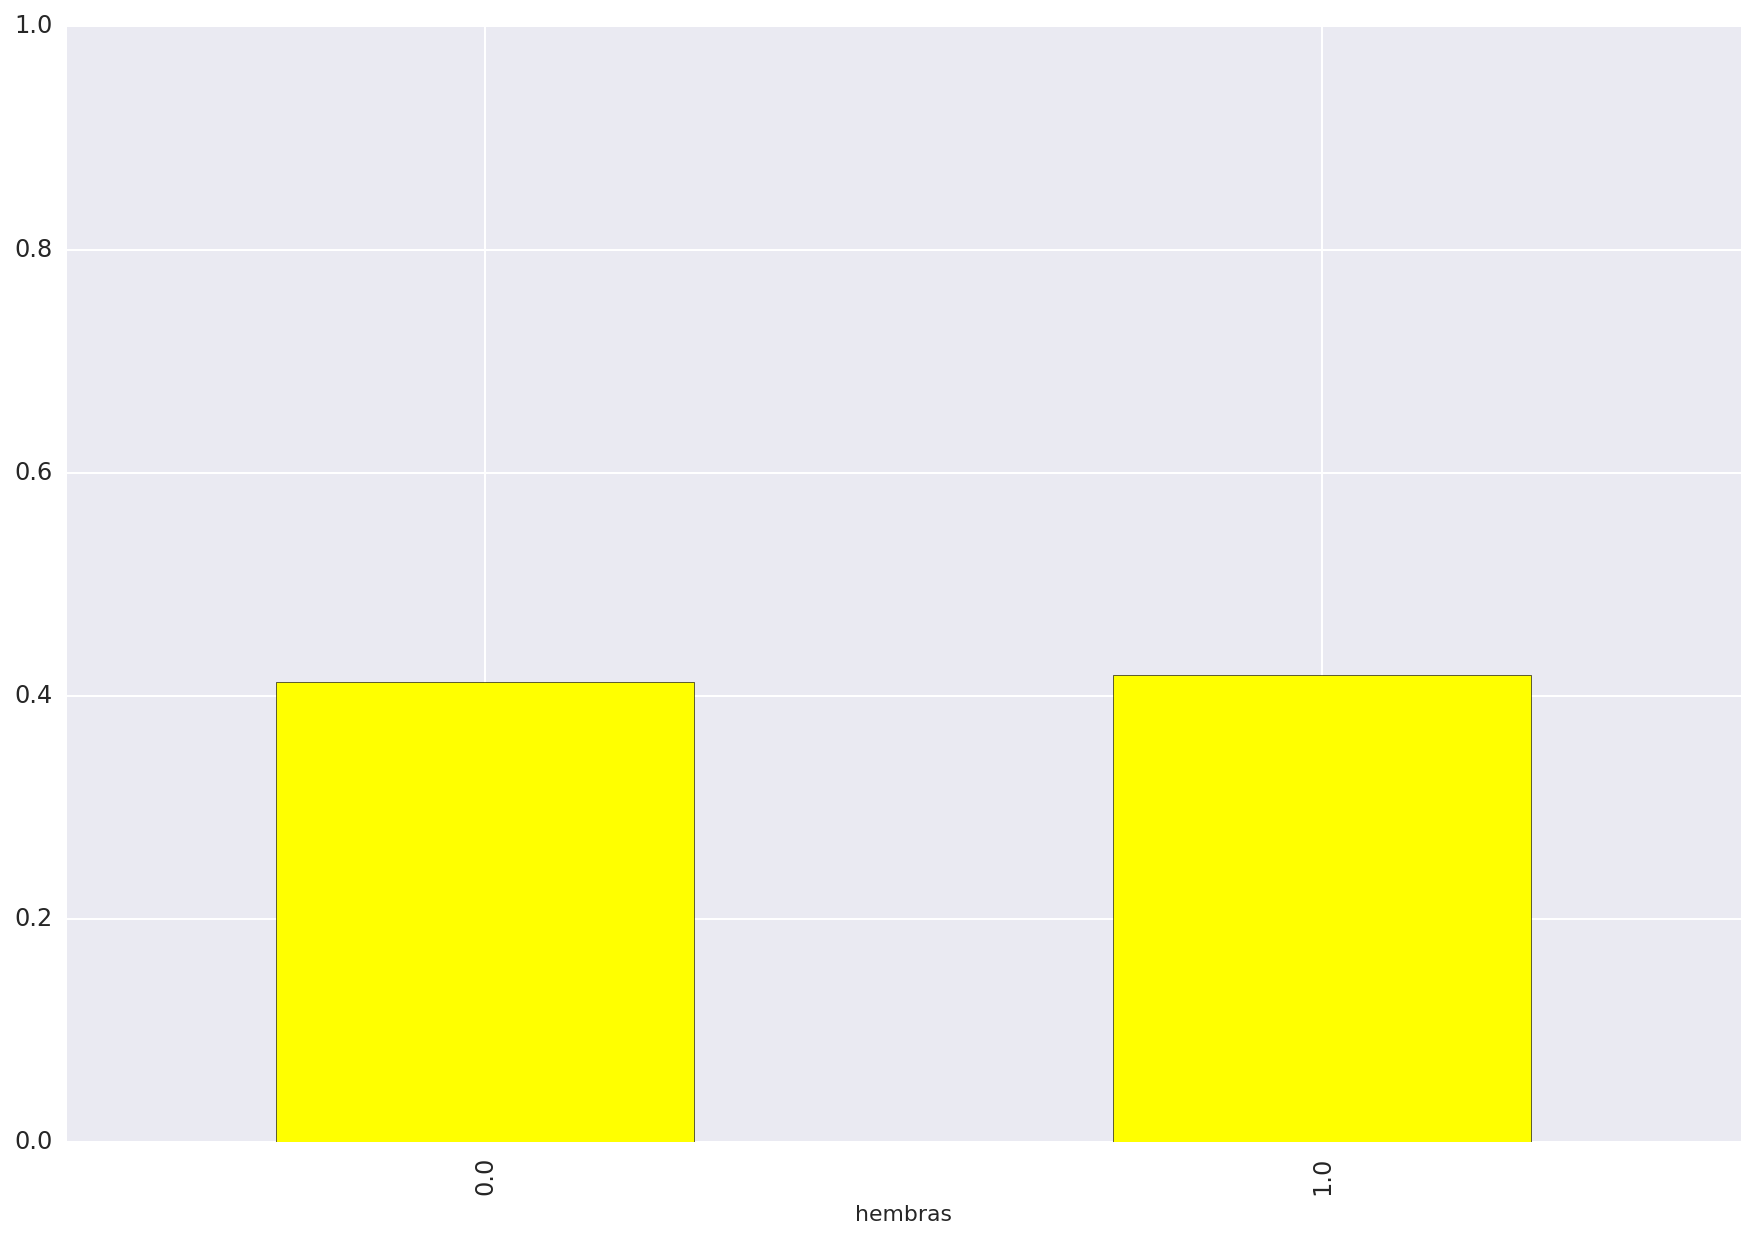

In [1007]:
fig8 = (df_sch_colegios.groupby('hembras')['sch_vs_ig'].sum()*1.0\
/df_sch_colegios.groupby('hembras')['sch'].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#ffff00')
plt.ylim((0,1))
savefig('fig8.png')

In [843]:
df_sch_colegios[df_sch_colegios['hembras']==1]['sch_vs_ig'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['hembras']==1]['sch'].sum()

0.4187192118226601

In [844]:
df_sch_colegios[df_sch_colegios['hembras']==0]['sch_vs_ig'].sum()*1.0\
/df_sch_colegios[df_sch_colegios['hembras']==0]['sch'].sum()

0.4125874125874126

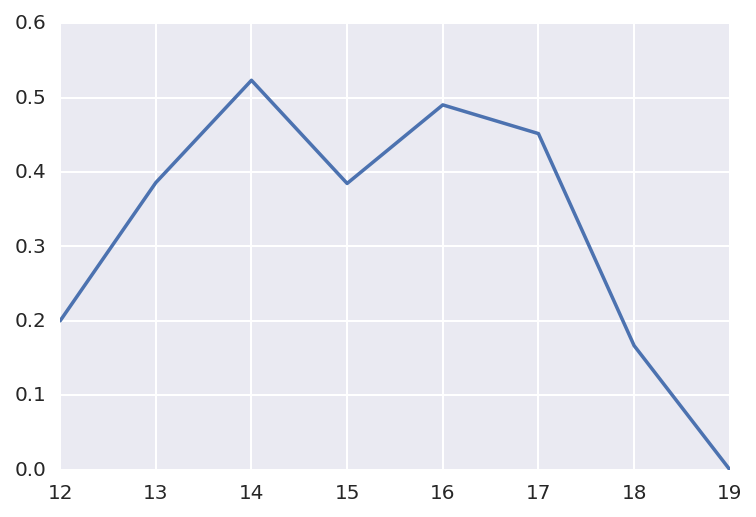

In [950]:
plot(df_sch_colegios.groupby('profile.age')['sch_vs_ig'].sum()*1.0\
/df_sch_colegios.groupby('profile.age')['sch'].sum())
savefig('fig9.png')

In [530]:
df_sch['sch_vs_ig'].sum()

155

In [531]:
df_sch['sch'].sum()

381

In [833]:
df_sch_colegios = pd.merge(df_sch,df_students_colegio, on=['id'])

### Instagram

In [888]:
preguntas_ig = [u'\xbfQuieres grabarte mostrando tu talento en Instagram?',
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_ig]

In [889]:
df_ig = pd.concat(frames).dropna()

In [890]:
ig_answers = df_ig['answer']

In [891]:
pena = []
ig = []

for answer in ig_answers:
    if 'pena' in answer:
        pena.append(1)
    else:
        pena.append(0)
    if 'no tengo' in answer:
        ig.append(0)
    else:
        ig.append(1)

In [892]:
df_ig['pena']=pena
df_ig['ig']=ig
df_ig = pd.merge(df_students_colegio,df_ig, on='id', how='inner')

In [893]:
df_ig = df_ig.drop_duplicates('id')

In [894]:
df_ig['ig'].sum()*1.0

351.0

#### Instagram Penetration

In [895]:
df_ig['ig'].sum()*1.0/df_ig['ig'].count()

0.8931297709923665

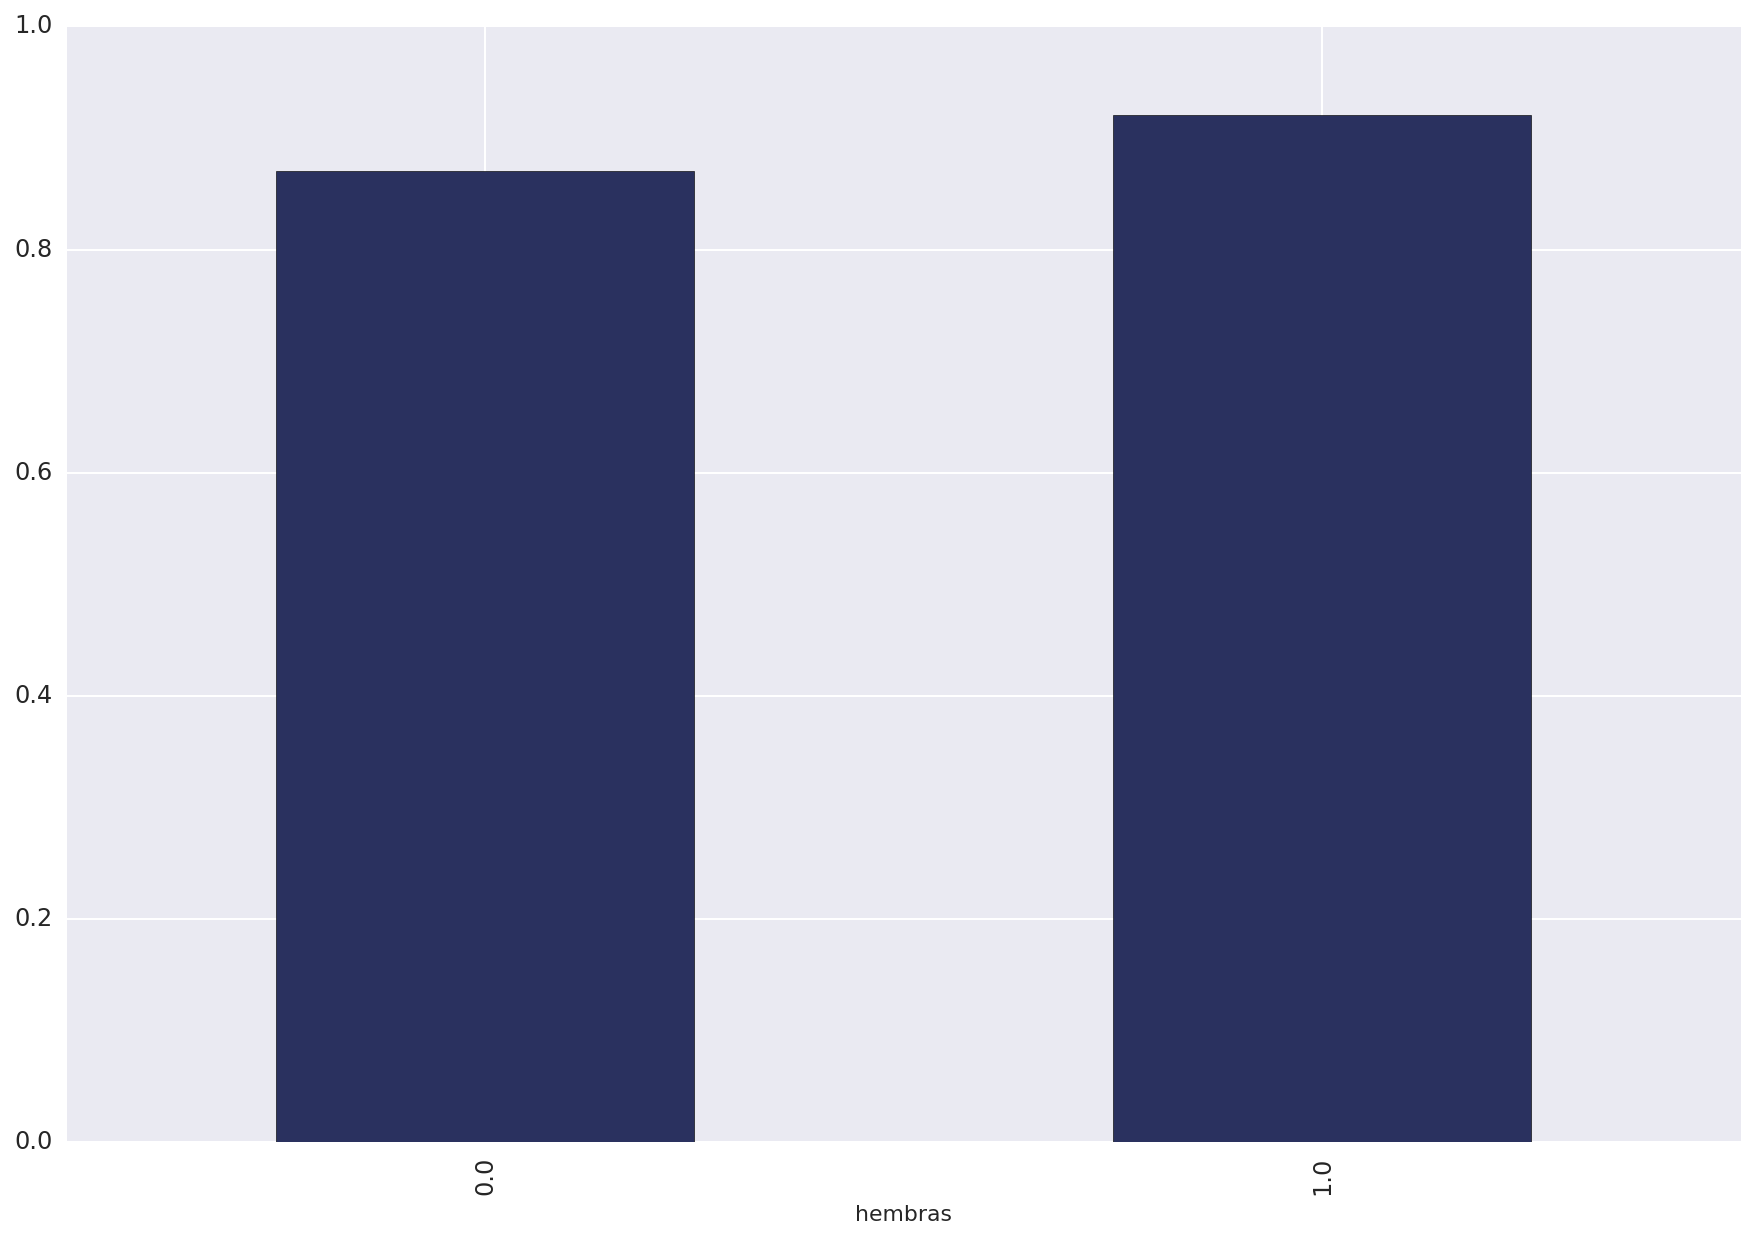

In [952]:
fig10=(df_ig.groupby('hembras')['ig'].sum()*1.0/df_ig.groupby('hembras')['ig'].count())\
.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#2A315F')
savefig('fig10.png')

In [897]:
df_ig[df_ig['hembras']==1]['ig'].sum()*1.0/df_ig[df_ig['hembras']==1]['ig'].count()

0.9206349206349206

In [898]:
df_ig[df_ig['hembras']==0]['ig'].sum()*1.0/df_ig[df_ig['hembras']==0]['ig'].count()

0.87

In [899]:
df_ig[df_ig['colegio']=='CHAMPAGNAT']['ig'].sum()*1.0/df_ig[df_ig['colegio']=='CHAMPAGNAT']['ig'].count()

0.8804347826086957

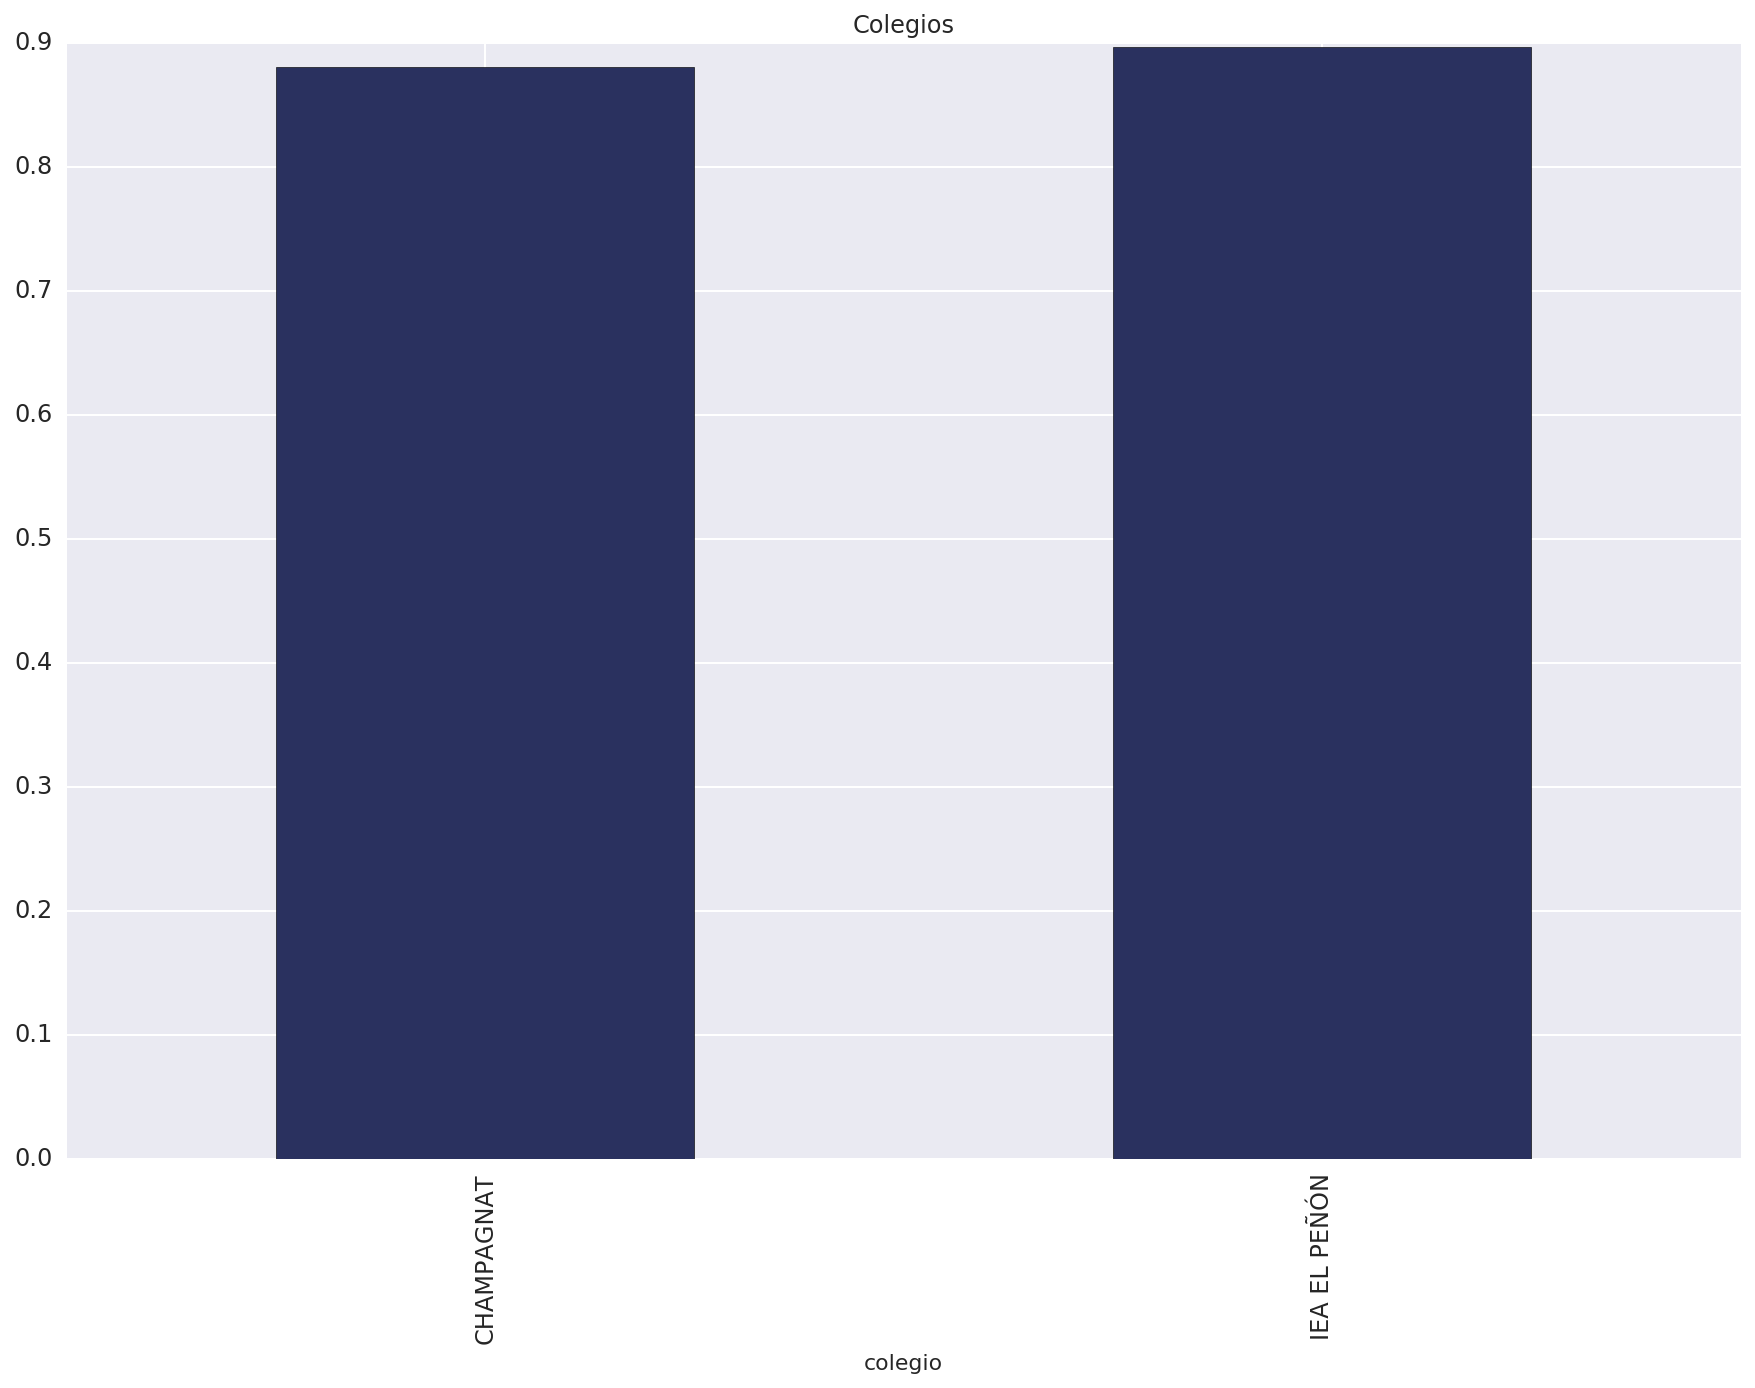

In [953]:
fig11= (df_ig.groupby('colegio')['ig'].sum()*1.0/df_ig.groupby('colegio')['ig'].count())\
.plot(kind='bar', title ="Colegios",figsize=(15,10),legend=False, fontsize=12, color='#2A315F')
savefig('fig11.png')

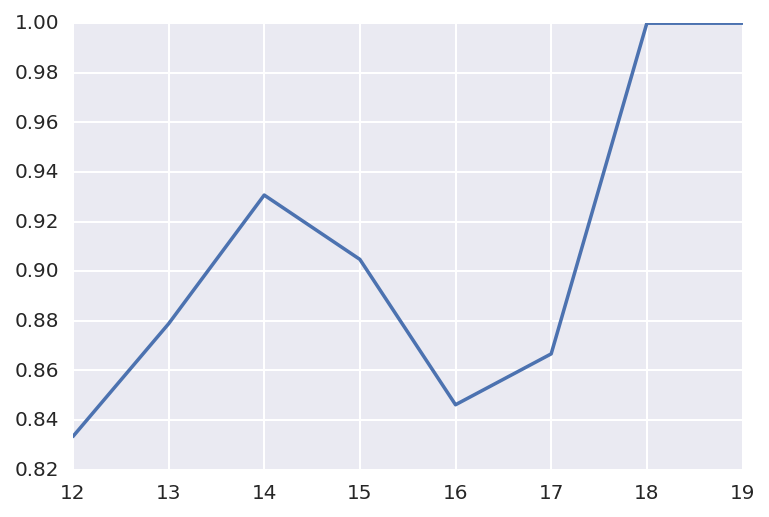

In [954]:
plot(df_ig.groupby('profile.age')['ig'].sum()*1.0/df_ig.groupby('profile.age')['ig'].count())
savefig('fig12.png')

##### Pena al postear

In [896]:
df_ig['pena'].sum()*1.0/df_ig['ig'].sum()

0.7094017094017094

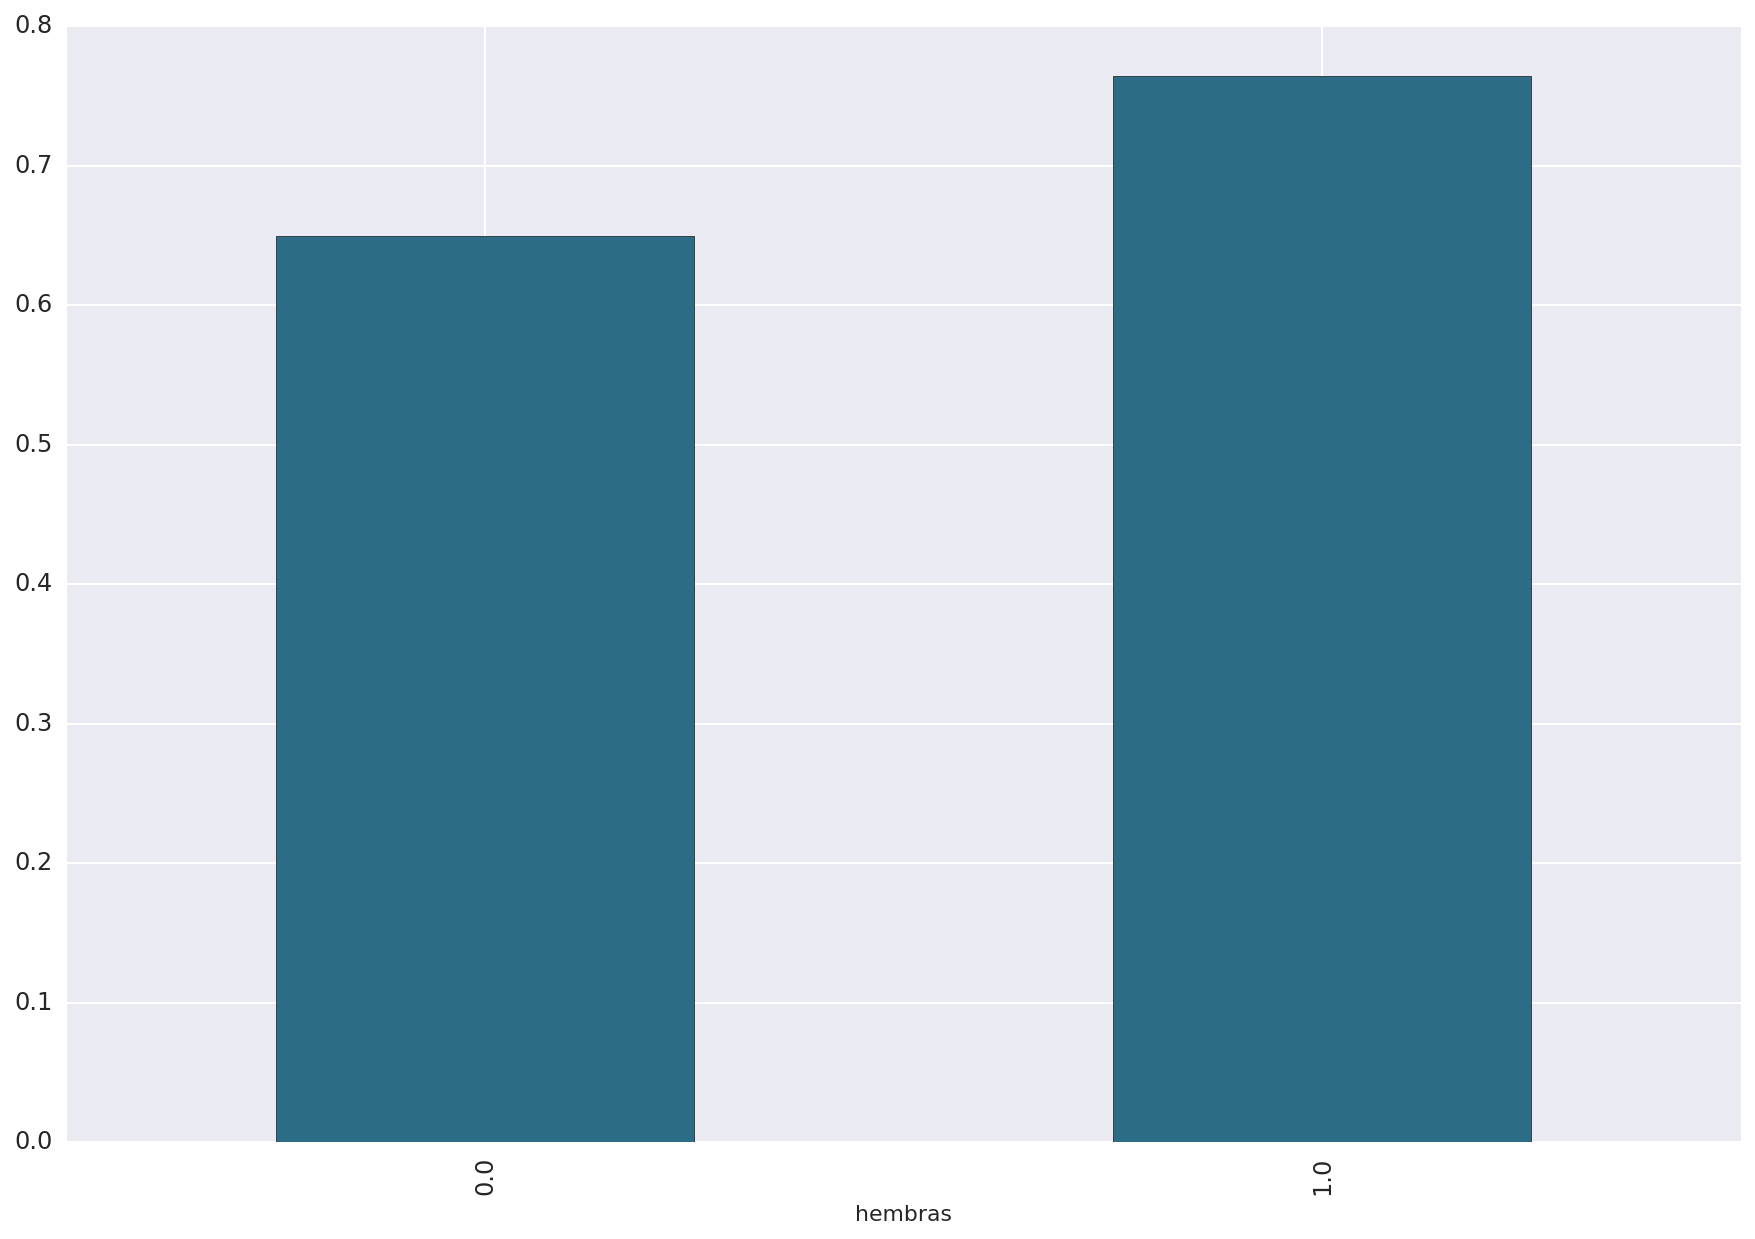

In [955]:
(df_ig.groupby('hembras')['pena'].sum()*1.0/df_ig.groupby('hembras')['ig'].sum())\
.plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=12, color='#2C6C87')
savefig('fig13.png')

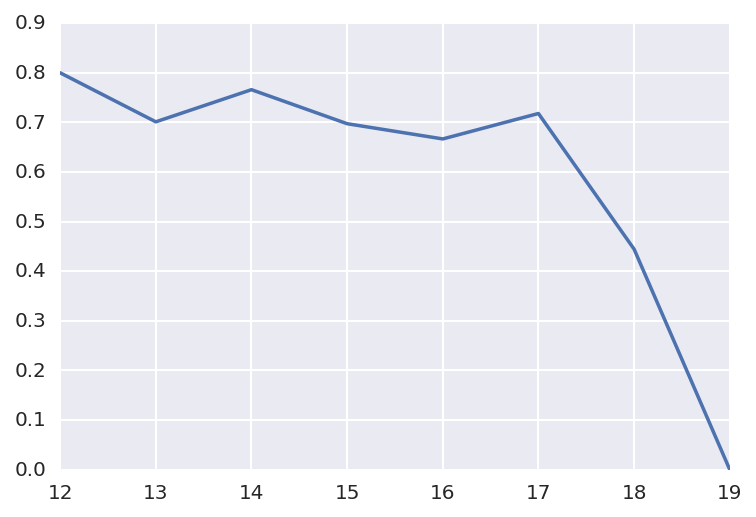

In [957]:
plot(df_ig.groupby('profile.age')['pena'].sum()*1.0/df_ig.groupby('profile.age')['ig'].sum())
savefig('fig15.png')

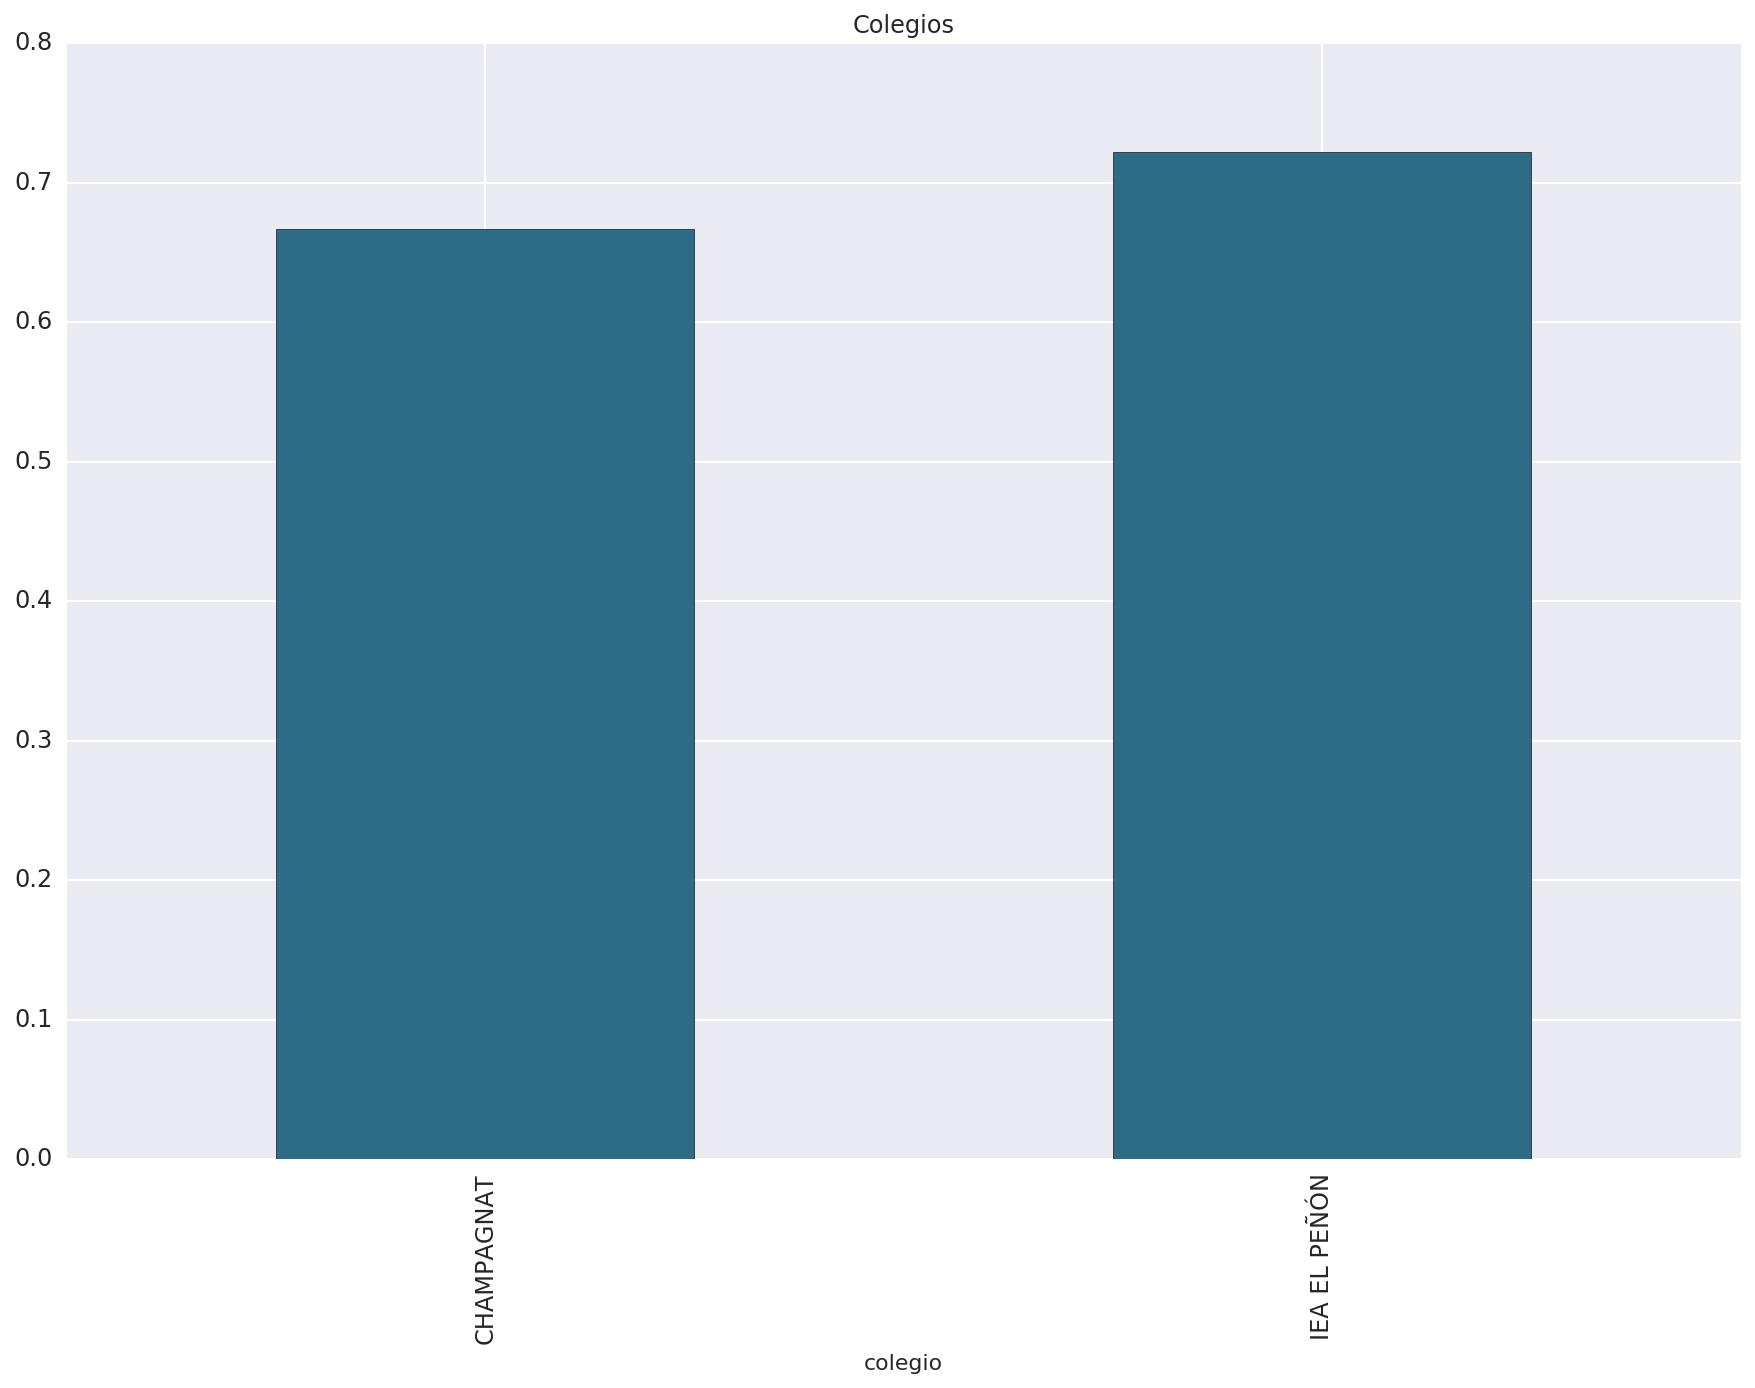

In [956]:
(df_ig.groupby('colegio')['pena'].sum()*1.0/df_ig.groupby('colegio')['ig'].sum())\
.plot(kind='bar', title ="Colegios",figsize=(15,10),legend=False, fontsize=12, color='#2C6C87')
savefig('fig14.png')

In [1129]:
preguntas_igusername = [u'Usuario de Instagram:',
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_igusername]

In [1131]:
preguntas_schusername = [u'Nombre de usuario en Snapchat:',
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_schusername]

In [1130]:
df_igusername = pd.concat(frames).dropna()
df_igusername['ig_name']= df_igusername['answer']

In [1132]:
df_schusername = pd.concat(frames).dropna()
df_schusername['sch_name']= df_schusername['answer']

In [1133]:
df_igusername

,level_0,level_1,answer,question,question_id,type,id,ig_name
186,539398176,0,@pacxus,Usuario de Instagram:,9950929,text,539398176,@pacxus
232,540266244,0,charlyr_9,Usuario de Instagram:,9950929,text,540266244,charlyr_9
281,542095703,0,saulsr1710,Usuario de Instagram:,9950929,text,542095703,saulsr1710
307,540266243,0,charlyr_9,Usuario de Instagram:,9950929,text,540266243,charlyr_9
389,546049767,0,Liusprin,Usuario de Instagram:,9950929,text,546049767,Liusprin
458,542368451,0,Greicap,Usuario de Instagram:,9950929,text,542368451,Greicap
506,558343518,2,@paolavalentina19,Usuario de Instagram:,10353562,text,558343518,@paolavalentina19
651,539867847,0,osmeoxoxo,Usuario de Instagram:,9950929,text,539867847,osmeoxoxo
674,540675201,0,andres140700,Usuario de Instagram:,9950929,text,540675201,andres140700
697,540675202,0,andres140700,Usuario de Instagram:,9950929,text,540675202,andres140700


In [1134]:
df_schusername

,level_0,level_1,answer,question,question_id,type,id,sch_name
121,661849694,19,Alehaveswag,Nombre de usuario en Snapchat:,12536830,text,661849694,Alehaveswag
149,663537226,19,Franktapia2002,Nombre de usuario en Snapchat:,12536830,text,663537226,Franktapia2002
1040,664857952,23,isa.so,Nombre de usuario en Snapchat:,12536831,text,664857952,isa.so
1170,661816807,23,Maggysagar,Nombre de usuario en Snapchat:,12536831,text,661816807,Maggysagar
1550,663535349,23,Moriitaa,Nombre de usuario en Snapchat:,12536831,text,663535349,Moriitaa
1578,663161066,23,ChrisParra99,Nombre de usuario en Snapchat:,12536831,text,663161066,ChrisParra99
1634,663161064,23,ChrisParra99,Nombre de usuario en Snapchat:,12536831,text,663161064,ChrisParra99
1845,663633367,19,valeriagon0612,Nombre de usuario en Snapchat:,12536830,text,663633367,valeriagon0612
2060,661089105,23,mc2902,Nombre de usuario en Snapchat:,12536831,text,661089105,mc2902
2107,661309344,19,Andrecova,Nombre de usuario en Snapchat:,12536830,text,661309344,Andrecova


In [393]:
df_ig = pd.merge(df_ig,df_igusername, on='id', how='outer')

In [398]:
df_ig['ig_name'].dropna().nunique()

962

In [519]:
df_usersig = df_ig_colegios[['colegio','ig_name']].dropna()

In [528]:
df_usersig[df_usersig['colegio']== 'IEA EL PEÑÓN'].to_csv('lista_iea.csv')
df_usersig[df_usersig['colegio']== 'CHAMPAGNAT'].to_csv('lista_champagnat.csv')

In [529]:
!ls

data			  eventos.dill	lista_champagnat.csv  registrados.dill
EventBrite Metrics.ipynb  ig_iea.csv	lista_iea.csv


In [443]:
df_ig_colegios = pd.merge(df_ig, df_colegios, on='id')

In [444]:
ig_table = df_ig_colegios.groupby('colegio')['ig'].sum()/df_ig_colegios.groupby('colegio')['ig'].count().dropna()

In [445]:
ig_table.mean()

0.6703235089967038

In [446]:
colegios = ['CHAMPAGNAT','SAN JOSÉ DE CALASANZ','COLEGIO SAN VICENTE DE PAÚL','IEA EL PEÑÓN']

frames = [df_ig_colegios[df_ig_colegios['colegio'] == colegio] for colegio in colegios]

df_igdata = pd.concat(frames)

In [452]:
df_ig_profile = pd.merge(df_ig, df_users, on='id')

In [455]:
df_ig_event = df_ig_profile.groupby('event_id')['ig'].sum()/df_ig_profile.groupby('event_id')['ig'].count()

In [457]:
df_ig_event = pd.merge(df_ig_profile, df_events, on='event_id')

In [458]:
pd.crosstab(df_ig_event.event_name,df_ig_event.ig)[1.0]/(pd.crosstab(df_ig_event.event_name,df_ig_event.ig)[0.0]+pd.crosstab(df_ig_event.event_name,df_ig_event.ig)[1.0])

event_name
Anótate para que visitemos tu colegio    0.678756
TrixandTrax Flips Fest 2015              0.781910
TrixandTrax Ovomaltina 2016              0.898383
dtype: float64

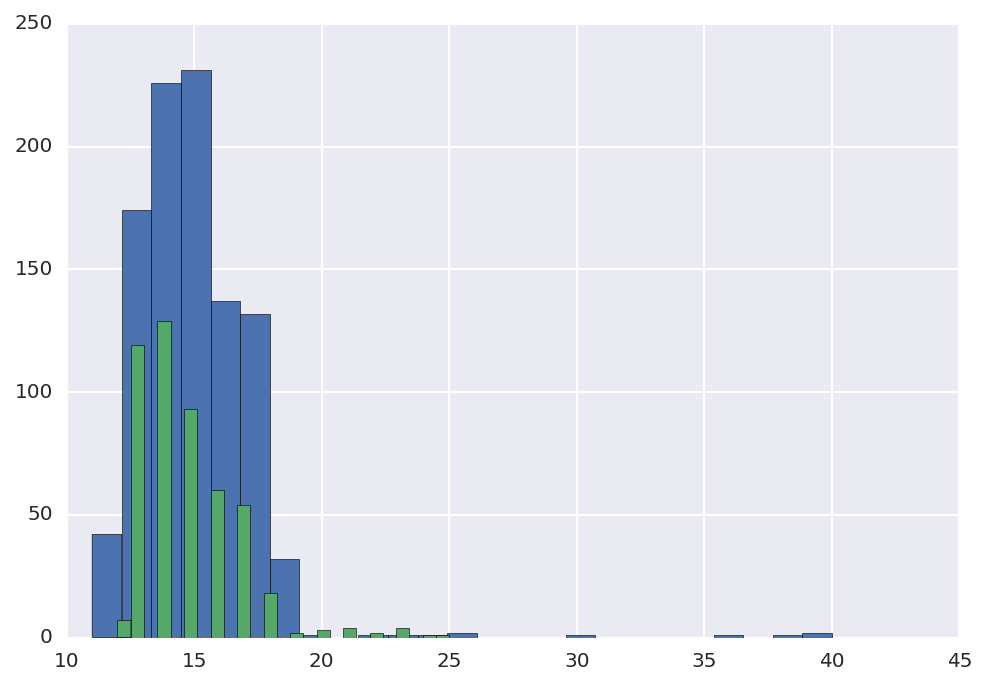

In [483]:

df_ig_event[df_ig_event['event_name']=='TrixandTrax Flips Fest 2015']['profile.age'].hist(bins=25)
df_ig_event[df_ig_event['event_name']=='TrixandTrax Ovomaltina 2016']['profile.age'].hist(bins=25)

In [481]:
df_ovo = df_ig_event[df_ig_event['event_name']=='TrixandTrax Ovomaltina 2016']

In [ ]:
df_ovo[df_ovo['profile.gender']==]

In [468]:
pd.crosstab(df_ig_event.event_name,df_ig_event['profile.age'])

profile.age,6.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,...,24.0,25.0,26.0,27.0,30.0,31.0,36.0,38.0,40.0,47.0
event_name,,,,,,,,,,,,,,,,,,,,,
Anótate para que visitemos tu colegio,2,2,1,2,6,12,26,27,41,28,...,3,0,0,1,0,1,0,0,1,1
Concurso TrixandTrax Flipstyle,0,0,0,0,0,0,3,0,5,3,...,0,0,0,0,0,0,0,0,0,0
TrixandTrax Flips Fest 2015,0,0,0,0,2,40,174,226,231,137,...,1,0,2,0,1,0,1,1,2,0
TrixandTrax Ovomaltina 2016,0,0,0,0,0,7,119,129,93,60,...,1,1,0,0,0,0,0,0,0,0


In [451]:
pd.crosstab(df_igdata.colegio,df_igdata.pena)[1.0]/(pd.crosstab(df_igdata.colegio,df_igdata.pena)[0.0]+pd.crosstab(df_igdata.colegio,df_igdata.pena)[1.0])

colegio
CHAMPAGNAT                     0.608696
COLEGIO SAN VICENTE DE PAÚL    0.649518
IEA EL PEÑÓN                   0.646104
SAN JOSÉ DE CALASANZ           0.555882
dtype: float64

### Curso y Sección

In [351]:
preguntas_curso = [u'A\xf1o que cursas:'
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_curso]

In [352]:
df_curso = pd.concat(frames).dropna()

In [353]:
df_curso['curso']=df_curso['answer']

In [354]:
preguntas_seccion = [u'Secci\xf3n'
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_seccion]

In [355]:
df_seccion = pd.concat(frames).dropna()
df_seccion['seccion']=df_seccion['answer']

In [356]:
df_curso = pd.merge(df_curso, df_seccion, on='id', how='outer')

In [357]:
df_curso.columns

Index([    u'level_0_x',     u'level_1_x',      u'answer_x',    u'question_x',
       u'question_id_x',        u'type_x',            u'id',         u'curso',
           u'level_0_y',     u'level_1_y',      u'answer_y',    u'question_y',
       u'question_id_y',        u'type_y',       u'seccion'],
      dtype='object')

In [359]:
cols = [                
                                     u'id',  
                                u'curso',
                          u'seccion',
            ]
trans = ColumnSelectTransformer(cols)
df_curso = trans.transform(df_curso)

In [989]:
df_curso[df_curso['seccion'] == 'D']

,id,curso,seccion
41,663534628,7mo,D
51,663516790,7mo,D
122,662360297,7mo,D
255,662096027,7mo,D
319,661921052,7mo,D
474,661586002,7mo,D
494,662096539,7mo,D
529,662085679,7mo,D
571,662298419,7mo,D
574,664890217,7mo,D


In [1135]:
df_curso

,id,curso,seccion
0,661849694,8vo,NaN
1,663537226,8vo,NaN
2,539398176,9no,NaN
3,540266243,9no,NaN
4,546049767,8vo,NaN
5,542324167,7mo,A
6,542368451,I diversificada,NaN
7,543429348,I diversificada,NaN
8,540731801,9no,NaN
9,539867847,9no,NaN


### Zonas

In [960]:
preguntas_zonas = [u'Zona en donde quieres participar',         
                    u'Talento que te llama la atenci\xf3n:',
                   u'Zona donde quieres participar:'
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_zonas]

In [966]:
df_zonas = pd.concat(frames).dropna()

In [965]:
zonas = df_zonas['answer'].dropna()

In [364]:
set(sorted(zonas))

{u'Talentos Baile',
 u'Talentos Trax (desde Djs hasta solistas)',
 u'Talentos Trax (desde Djs hasta solistas) | Talentos Baile',
 u'Talentos Trix (desde dominio de bal\xf3n hasta skate, roller y slackline)',
 u'Talentos Trix (desde dominio de bal\xf3n hasta skate, roller y slackline) | Talentos Baile',
 u'Talentos Trix (desde dominio de bal\xf3n hasta skate, roller y slackline) | Talentos Trax (desde Djs hasta solistas)',
 u'Talentos Trix (desde dominio de bal\xf3n hasta skate, roller y slackline) | Talentos Trax (desde Djs hasta solistas) | Talentos Baile',
 u'Zona Artes Visuales',
 u'Zona Baile',
 u'Zona Baile | Zona Artes Visuales',
 u'Zona Trax',
 u'Zona Trax (m\xfasica)',
 u'Zona Trax (m\xfasica) | Zona Artes Visuales',
 u'Zona Trax (m\xfasica) | Zona Baile',
 u'Zona Trax (m\xfasica) | Zona Baile | Zona Artes Visuales',
 u'Zona Trax | Zona Baile',
 u'Zona Trix',
 u'Zona Trix (deporte)',
 u'Zona Trix (deporte) | Zona Artes Visuales',
 u'Zona Trix (deporte) | Zona Baile',
 u'Zona Tr

In [967]:
trix = []
trax = []
baile = []
arte = []
for zona in zonas:
    if 'Trix' in zona:
        trix.append(1)
    else:
        trix.append(0)
    if 'Trax' in zona:
        trax.append(1)
    else:
        trax.append(0)
    if 'Baile' in zona:
        baile.append(1)
    else:
        baile.append(0)
    if 'Artes Visuales' in zona:
        arte.append(1)
    else:
        arte.append(0)
  

In [968]:
df_zonas['trix'] = trix
df_zonas['trax'] = trax
df_zonas['baile'] = baile
df_zonas['arte'] = arte

In [969]:
df_zonas['total']= df_zonas['trix']+df_zonas['trax']+df_zonas['baile']+df_zonas['arte']

In [970]:
df_zonas = pd.merge(df_zonas, df_students_colegio, on='id',how='inner')

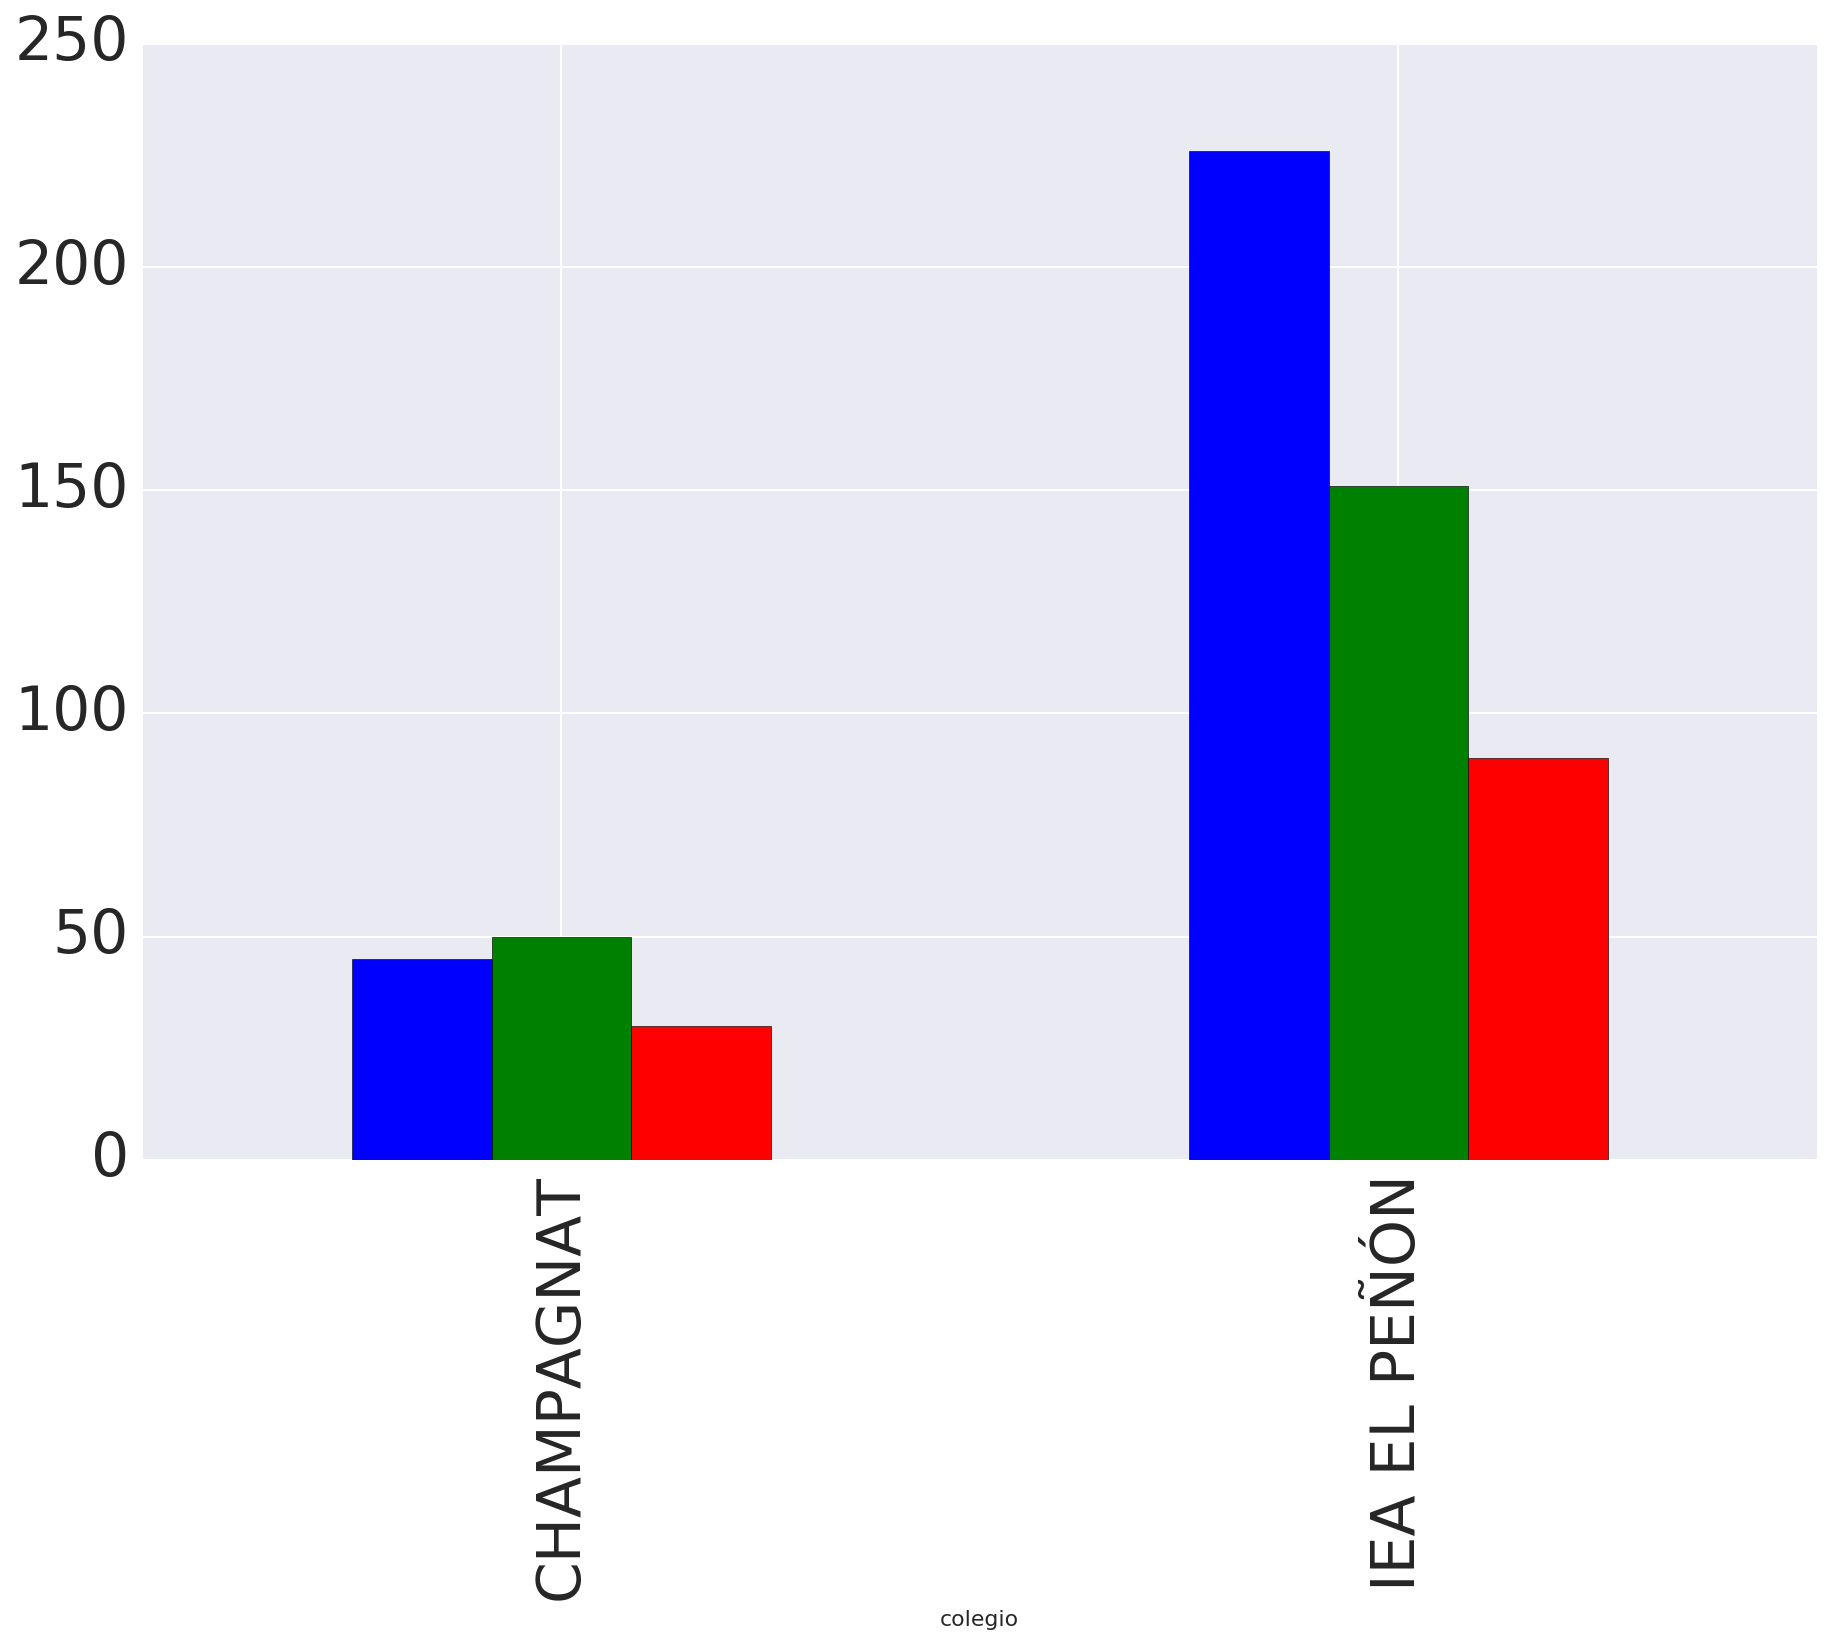

In [998]:
(df_zonas.groupby('colegio')[['trix','trax','baile']].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=30)
savefig('fig16.png')

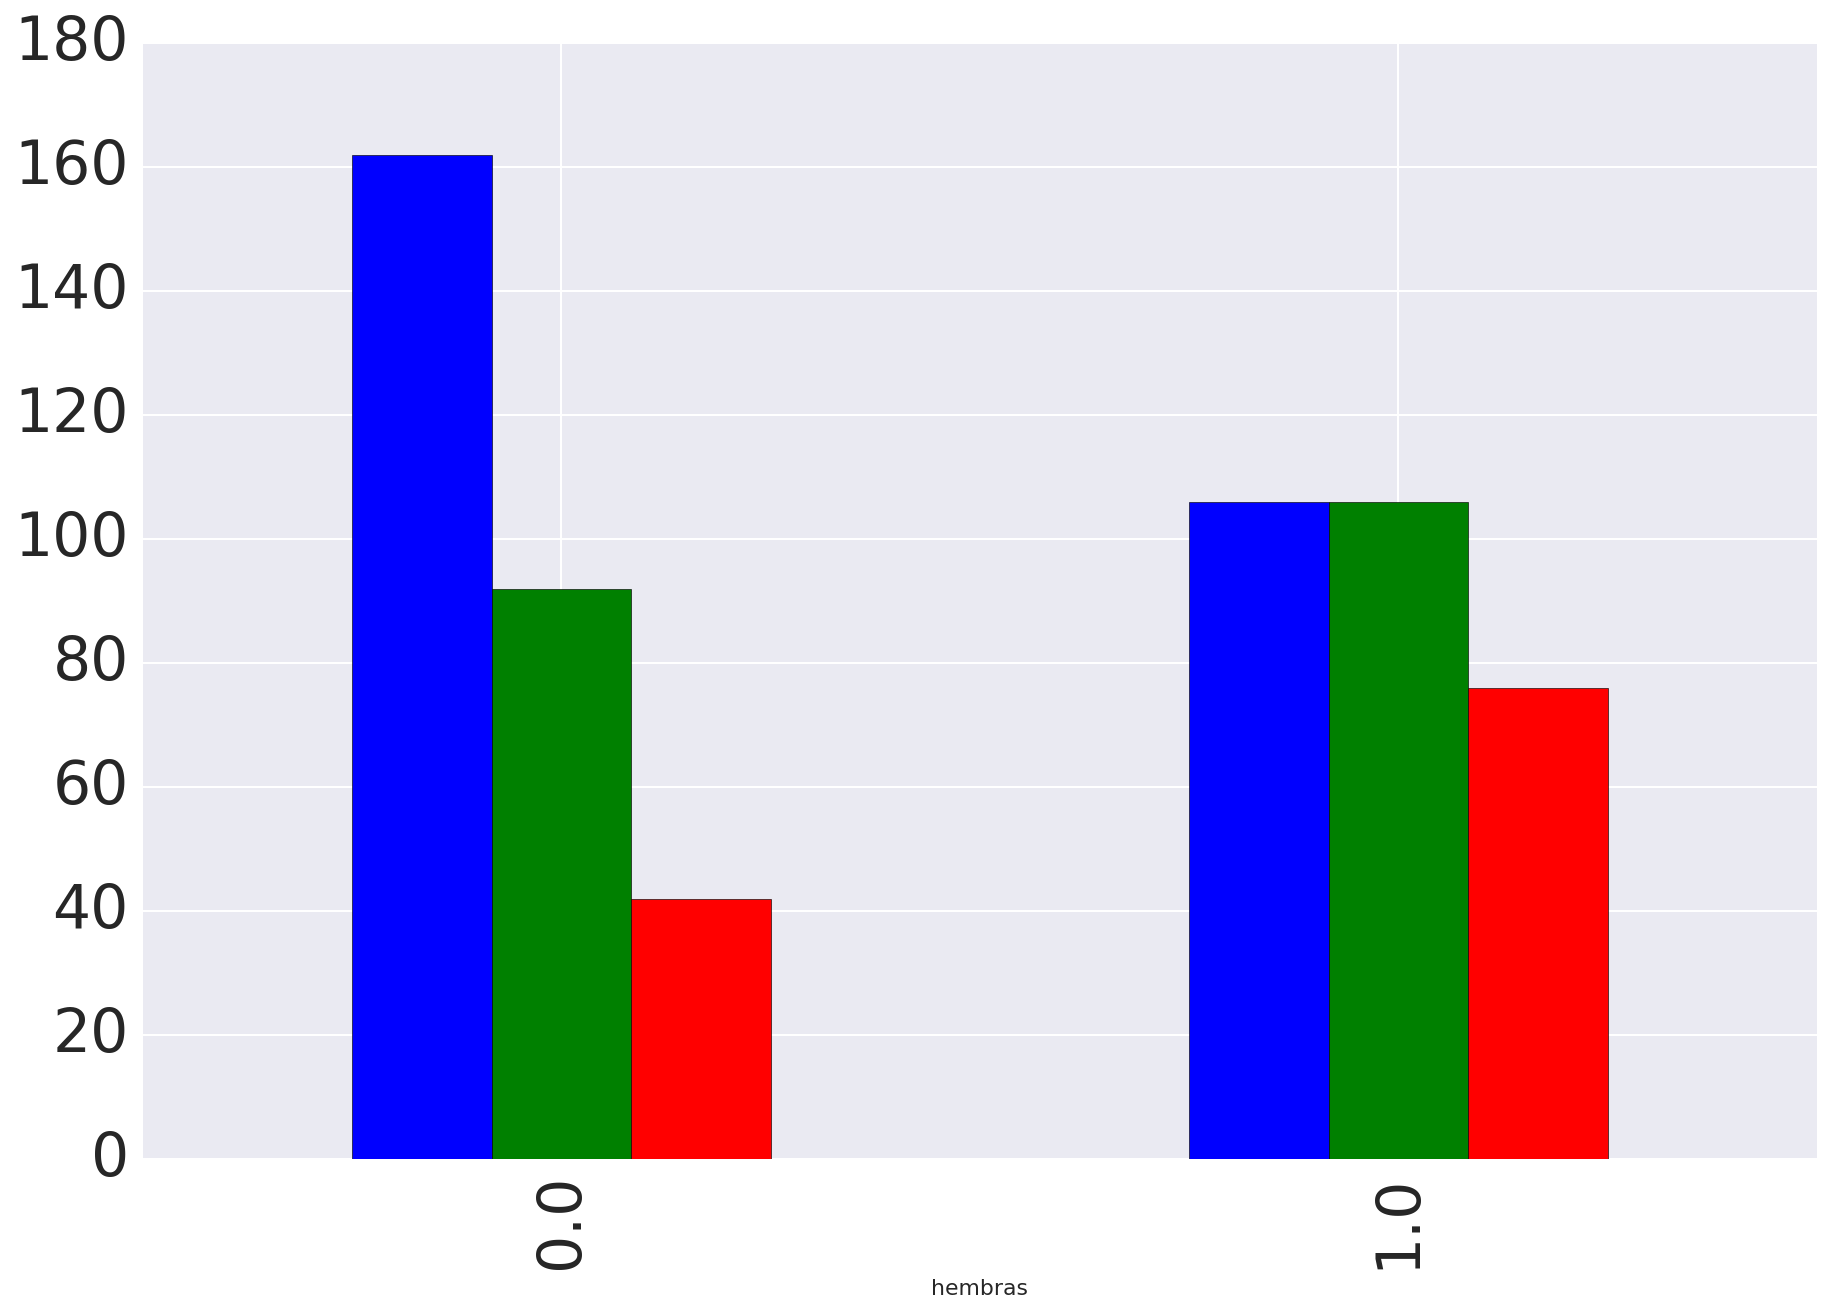

In [999]:
(df_zonas.groupby('hembras')[['trix','trax','baile']].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=False, fontsize=30)
savefig('fig17.png')

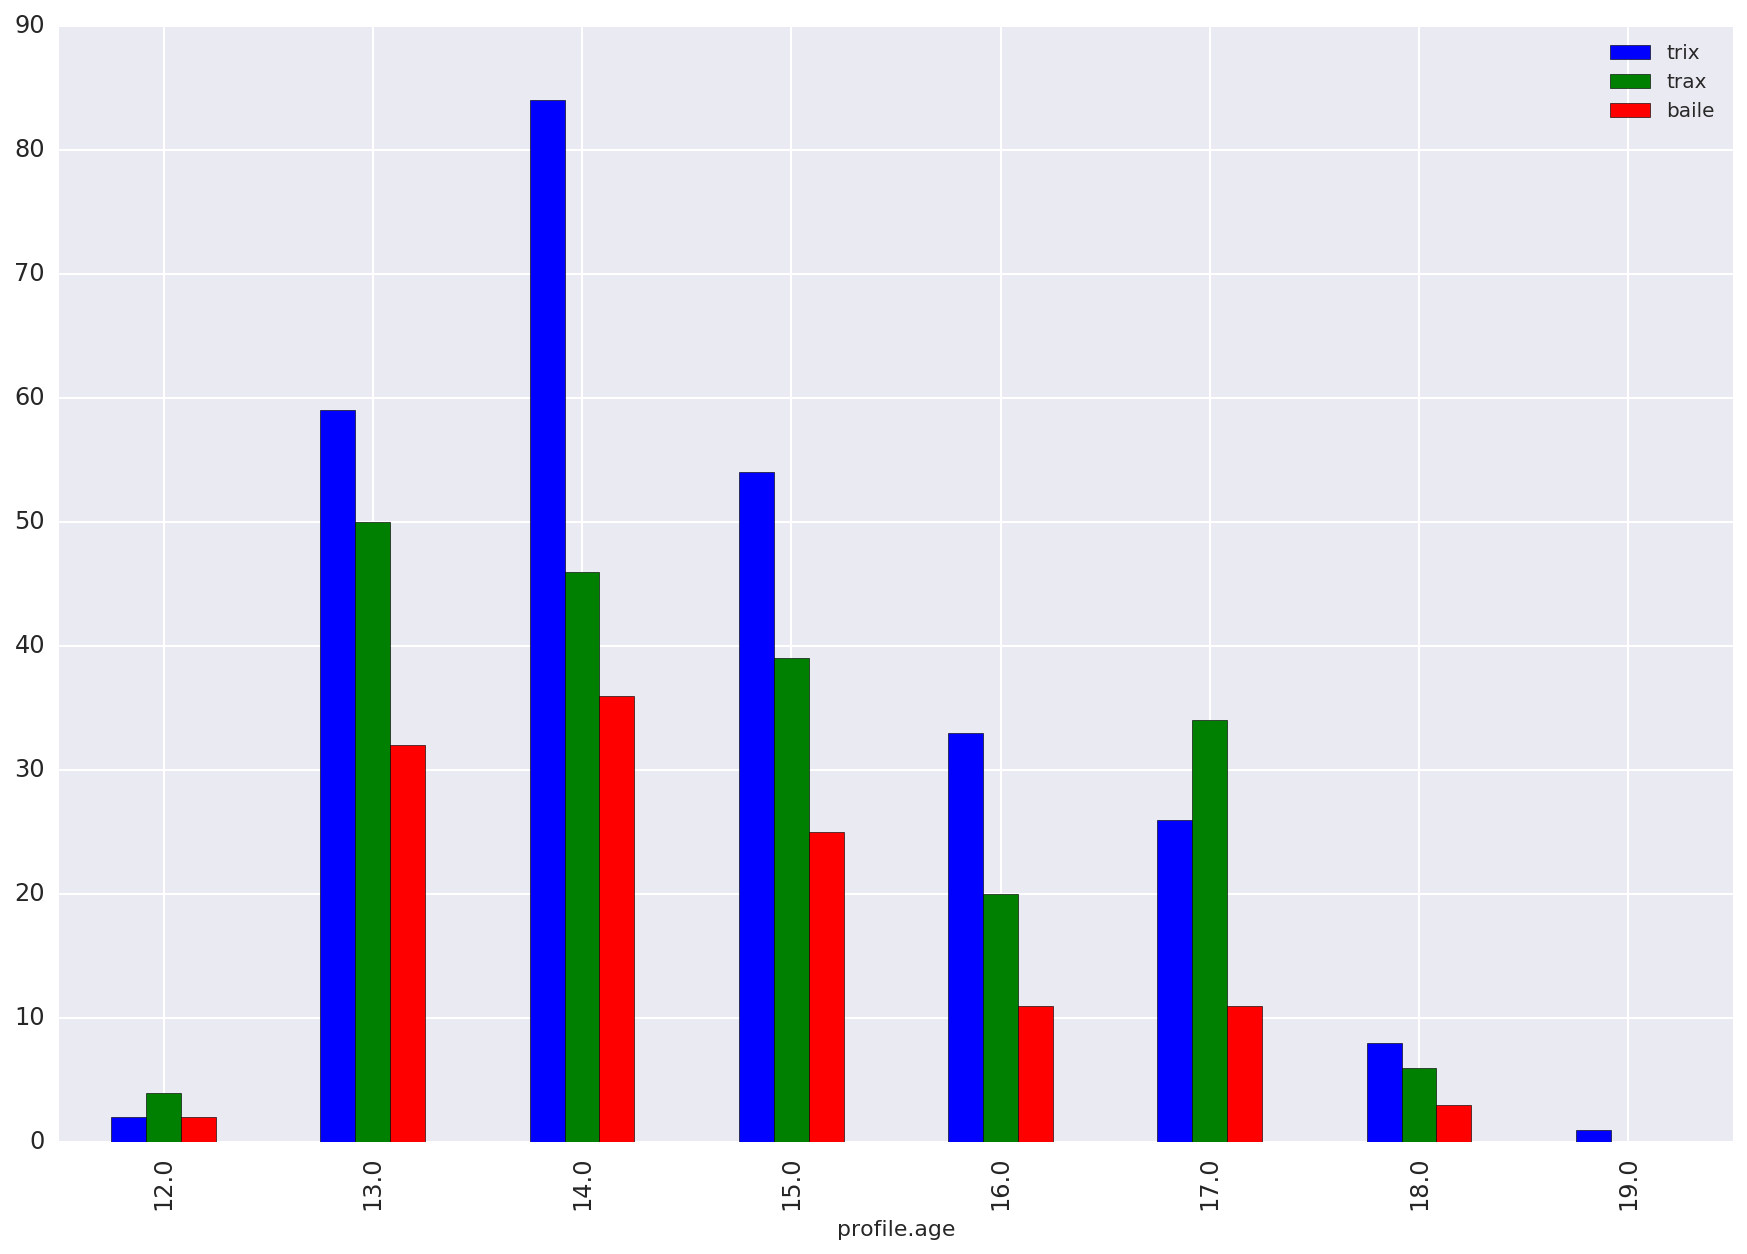

In [978]:
(df_zonas.groupby('profile.age')[['trix','trax','baile']].sum()).plot(kind='bar', title ="",figsize=(15,10),legend=True, fontsize=12)
savefig('fig18.png')

### Colegios

In [369]:
preguntas_colegios = [u'Colegio donde estudias y fecha del evento:',          
                    u'Colegio donde estudias:',
                      u'Colegio o Universidad donde estudias:',
                      u'Colegio:', u'Colegio'
    
]


frames = [df_answers[df_answers['question'] == pregunta] for pregunta in preguntas_colegios]

In [370]:
df_colegios = pd.concat(frames)

In [371]:
colegios_orig = df_colegios['answer'].dropna().unique()

In [372]:
colegios_new = []
import unicodedata
for colegio in colegios_orig:
    nombre = unicodedata.normalize('NFKC', colegio).encode("utf-8").upper()
    if ',' in nombre:
        nombre = nombre.split(',')[0]
    if 'UNIDAD EDUCATIVA' in nombre:
        nombre=nombre.replace('UNIDAD EDUCATIVA',' ')
    nombre=" ".join(nombre.split())
    colegios_new.append(nombre)

In [373]:
set(sorted(colegios_new))

{'"24 DE JULIO DE 1783"NATALICIO DEL LIBERTADOR"',
 '"HILDA NU\xc3\xb1EZ DE HENRIQUEZ',
 '"U.E" ANDR\xc3\xa9S ELOY BLANCO',
 'AGUST\xc3\xadN AVELEDO',
 'ALIRIO GUIATIA ARAUJO',
 'ALTAGRACIA',
 'ANA MAYO TORREALBA',
 'ANTONIO ESTEVEZ',
 'APAMATES',
 'BARRIO NUEVO',
 'C.E.A.P.C.V',
 'C.E.A.P.U.C.V',
 'C.E.A.P.U.C.V.',
 'CARACCIOLO PARRA LEON',
 'CEAPUCV',
 'CEI LOS TULIPANES',
 'CENTRO EDUCATIVO APUCV',
 'CHAMPAGNAT',
 'CIRILO ALBERTO',
 'CNEL.JOSE MARIA CAMACARO',
 'COLEGIO',
 'COLEGIO AMBROSIO PLAZA',
 'COLEGIO ARCOIRIS',
 'COLEGIO CHAMPAGNAT',
 'COLEGIO CONSUELOS NAVAS TOVAR',
 'COLEGIO EL CLERET EL HATILLO',
 'COLEGIO EL PE\xc3\xb1\xc3\xb3N',
 'COLEGIO EL PE\xc3\xb1\xc3\xb3N (SOLO PARA ALUMNOS - VIERNES NOV 7)',
 'COLEGIO EMMANUEL',
 'COLEGIO FRANCIA',
 'COLEGIO GENERAL PIAR',
 'COLEGIO HUMBOLDT',
 'COLEGIO HUMBOLDT CARACAS',
 'COLEGIO JOSE VICENTE DE UNDA',
 'COLEGIO LUISA CACERES DE ARISMENDI',
 'COLEGIO MADRE MATILDE',
 'COLEGIO MAESTRO SANTIAGO JOSE SANCHES CARUCI',
 'COLEGIO MAE

In [437]:
colegios_clean = []
import unicodedata
iea = ['COLEGIO EL PE\xc3\xb1\xc3\xb3N',
 'COLEGIO EL PE\xc3\xb1\xc3\xb3N (SOLO PARA ALUMNOS - VIERNES NOV 7)',
       'EL PE\xc3\xb1ON',
 'EL PE\xc3\xb1\xc3\xb3N',
       'PE\xc3\xb1ON' ,
       'IEA',
 'IEA EL PE\xc3\xb1ON',
 'IEA PE\xc3\xb1ON',
       'INSTITUTOS EDUCACIONALES ASOCIADOS'
      ]
ceapucv = ['C.E.A.P.C.V',
 'C.E.A.P.U.C.V',
 'C.E.A.P.U.C.V.',
 'CEAPUCV',
 'CENTRO EDUCATIVO APUCV'
          ]

ie = [ 'INATITUTO ESCUELA',
 'INSTITUTO ESCUELA',
 'INSTITUTO ESCUELA (SOLO PARA ALUMNOS - VIERNES NOV 14)',
 'INSTITUTO ESCUELQ'
     ]

sbii = ['COLEGIO SIM\xc3\xb3N BOL\xc3\xadVAR (SOLO PARA ALUMNOS - LUNES NOV 10)','SIMON BOLIVAR II','SIM\xc3\x93N BOL\xc3\x8dVAR II']

champagnat = ['COLEGIO CHAMPAGNAT','CHAMPAGNAT']

svicentep = ['COLEGIO SAN VICENTE DE PAUL',
 'COLEGIO SAN VICENTE DE PA\xc3\x9aL', 'COLEGIO SAN VICENTE DE PAÚL','COLEGIO SAN VICENTE DE PAúL']

calasanz = ['SAN JOSE DE CALASANZ',
 'SAN JOS\xc3\x89 DE CALASANZ',
           'COLEGIO SAN JOS\xc3\xa9 DE CALASANZ']

for nombre in colegios_new:
    if nombre in ie:
        nombre = 'INSTITUTO ESCUELA'
    if nombre in ceapucv:
        nombre = 'CEAPUCV'
    if nombre in iea:
        nombre = 'IEA EL PEÑÓN'
    if nombre in sbii:
        nombre = 'SIMÓN BOLÍVAR II'
    if nombre in champagnat:
        nombre = 'CHAMPAGNAT'
    if nombre in svicentep:
        nombre = 'COLEGIO SAN VICENTE DE PAÚL'
    if nombre in calasanz:
        nombre = 'SAN JOSÉ DE CALASANZ'
    colegios_clean.append(nombre)

In [375]:
set(sorted(colegios_clean))

{'"24 DE JULIO DE 1783"NATALICIO DEL LIBERTADOR"',
 '"HILDA NU\xc3\xb1EZ DE HENRIQUEZ',
 '"U.E" ANDR\xc3\xa9S ELOY BLANCO',
 'AGUST\xc3\xadN AVELEDO',
 'ALIRIO GUIATIA ARAUJO',
 'ALTAGRACIA',
 'ANA MAYO TORREALBA',
 'ANTONIO ESTEVEZ',
 'APAMATES',
 'BARRIO NUEVO',
 'CARACCIOLO PARRA LEON',
 'CEAPUCV',
 'CEI LOS TULIPANES',
 'CHAMPAGNAT',
 'CIRILO ALBERTO',
 'CNEL.JOSE MARIA CAMACARO',
 'COLEGIO',
 'COLEGIO AMBROSIO PLAZA',
 'COLEGIO ARCOIRIS',
 'COLEGIO CONSUELOS NAVAS TOVAR',
 'COLEGIO EL CLERET EL HATILLO',
 'COLEGIO EMMANUEL',
 'COLEGIO FRANCIA',
 'COLEGIO GENERAL PIAR',
 'COLEGIO HUMBOLDT',
 'COLEGIO HUMBOLDT CARACAS',
 'COLEGIO JOSE VICENTE DE UNDA',
 'COLEGIO LUISA CACERES DE ARISMENDI',
 'COLEGIO MADRE MATILDE',
 'COLEGIO MAESTRO SANTIAGO JOSE SANCHES CARUCI',
 'COLEGIO MAESTRO SANTIOGO JOSE SANCHEZ CARUCI',
 'COLEGIO MERCEDES DE ARAGUA',
 'COLEGIO NUESTRA SE\xc3\xb1ORA DEL ROSARIO',
 'COLEGIO RAFAEL RANGEL',
 'COLEGIO RODRIGUEZ PAZ',
 'COLEGIO SAGRADA AMILIA',
 'COLEGIO SAN JOS

In [438]:
colegios_dict={}
for k,v in zip(colegios_orig, colegios_clean):
    colegios_dict[k]=v

In [439]:
df_colegios['colegio']=df_colegios['answer']

In [440]:
orig_colegios = df_colegios['answer']
new_colegios=[]
for colegio in orig_colegios:
    if colegio in colegios_dict.keys():
        colegio = colegios_dict[colegio]
    new_colegios.append(colegio)
df_colegios['colegio'] = new_colegios    

In [441]:
df_colegios

,level_0,level_1,answer,question,question_id,type,id,colegio
1,542433863,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542433863,COLEGIO SAN VICENTE DE PAÚL
24,663504954,1,NaN,Colegio donde estudias y fecha del evento:,12536248,multiple_choice,663504954,NaN
52,663528387,1,NaN,Colegio donde estudias y fecha del evento:,12536248,multiple_choice,663528387,NaN
80,542433864,1,NaN,Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542433864,NaN
103,661849694,1,"Colegio Champagnat, Miércoles 8 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,661849694,CHAMPAGNAT
131,663537226,1,"Colegio El Peñón, Martes 14 de Junio",Colegio donde estudias y fecha del evento:,12536248,multiple_choice,663537226,IEA EL PEÑÓN
159,663555012,1,NaN,Colegio donde estudias y fecha del evento:,12536248,multiple_choice,663555012,NaN
187,539398176,1,"Colegio Champagnat, Martes 2 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,539398176,CHAMPAGNAT
210,541933656,1,"Colegio Champagnat, Martes 2 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,541933656,CHAMPAGNAT
233,540266244,1,NaN,Colegio donde estudias y fecha del evento:,9950939,multiple_choice,540266244,NaN


In [442]:
df_colegios[df_colegios['colegio']=='COLEGIO SAN VICENTE DE PAÚL']

,level_0,level_1,answer,question,question_id,type,id,colegio
1,542433863,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542433863,COLEGIO SAN VICENTE DE PAÚL
308,540266243,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,540266243,COLEGIO SAN VICENTE DE PAÚL
436,542324167,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542324167,COLEGIO SAN VICENTE DE PAÚL
459,542368451,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542368451,COLEGIO SAN VICENTE DE PAÚL
482,543429348,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,543429348,COLEGIO SAN VICENTE DE PAÚL
724,543162255,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,543162255,COLEGIO SAN VICENTE DE PAÚL
773,540308672,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,540308672,COLEGIO SAN VICENTE DE PAÚL
1176,542786215,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542786215,COLEGIO SAN VICENTE DE PAÚL
1482,542722628,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,542722628,COLEGIO SAN VICENTE DE PAÚL
2226,543278745,1,"Colegio San Vicente de Paúl, Viernes 5 de Junio",Colegio donde estudias y fecha del evento:,9950939,multiple_choice,543278745,COLEGIO SAN VICENTE DE PAÚL


### Ticket Classes

In [89]:
tickets_dict = {}
row_iterator = df_events.iterrows()
##_, last = row_iterator.next()  # take first item from row_iterator
for i, row in row_iterator:
    tickets_dict[row['id']]= row['ticket_classes']

event_ids = []
frames = []

for event_id, tickets in tickets_dict.iteritems():
    event_ids.append(event_id)
    frames.append(json_normalize(tickets))

df_tickets = pd.concat(frames, keys=event_ids)

In [91]:
df_tickets.columns

Index([      u'actual_cost.currency',        u'actual_cost.display',
          u'actual_cost.major_value',          u'actual_cost.value',
              u'actual_fee.currency',         u'actual_fee.display',
           u'actual_fee.major_value',           u'actual_fee.value',
                        u'auto_hide',              u'cost.currency',
                     u'cost.display',           u'cost.major_value',
                       u'cost.value',                u'description',
                         u'donation',                   u'event_id',
                     u'fee.currency',                u'fee.display',
                  u'fee.major_value',                  u'fee.value',
                             u'free',             u'has_pdf_ticket',
                           u'hidden',           u'hide_description',
                               u'id',                u'include_fee',
                 u'maximum_quantity', u'maximum_quantity_per_order',
                 u'minimum_quantit

In [93]:
cols = ['id','event_id', 'name']
trans = ColumnSelectTransformer(cols)
df_tickets = trans.transform(df_tickets)

In [95]:
df_tickets.columns = ['ticket_class_id', 'event_id','ticket_name']

In [96]:
df_tickets

ticket_class_id     event_id  \
20946326025 0        43923327  20946326025   
17810662170 0        37612943  17810662170   
16860463099 0        35768089  16860463099   
            1        36085422  16860463099   
13018373305 0        28540565  13018373305   
            1        28554507  13018373305   
            2        28554509  13018373305   
16845126226 0        35740018  16845126226   
            1        35740022  16845126226   
            2        35795638  16845126226   
            3        35751037  16845126226   
25790656548 0        50985006  25790656548   
            1        50985007  25790656548   
            2        50985008  25790656548   
            3        50985009  25790656548   
13334051507 0        29123795  13334051507   
17025369338 0        36099098  17025369338   

                                                     ticket_name  
20946326025 0              Anótate para que visitemos tu colegio  
17810662170 0              Anótate para que visitemos tu colegio  
16860463099 0                Paso 1. Concursante quien participa  
            1         Paso 2. Representante legal quien autoriza  
13018373305 0  Lunes 27 de Oct. Día 1 de Grabación de Perform...  
            1  Martes 28 de Oct. Día 2 de Grabación de Perfor...  
            2  Domingo 7 de Dic. Festival con presentaciones ...  
16845126226 0  Paso 1. Alumno quien participa (solo para alum...  
            1                                Inscripción abierta  
            2         Paso 2. Representante legal quien autoriza  
            3        Solo completar si eres parte del staff 2015  
25790656548 0  Paso 1. Alumno quien participa (solo para alum...  
            1                                Inscripción abierta  
            2         Paso 2. Representante legal quien autoriza  
            3        Solo completar si eres parte del staff 2016  
13334051507 0         Asiste al evento TrixandTrax de tu colegio  
17025369338 0                                               Test

In [232]:
df_orders = pd.merge(df_orders,df_tickets, on='ticket_class_id')

In [233]:
df_orders

,event_id_x,order_id,ticket_class_id,id_x_x,name_x,event_id_y,id_y_x,name_y,event_id_x,id_x_y,name,event_id_y,id_y_y,name.text,ticket_classes,start.local,end.local,event_name
0,13018373305,339032529,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
1,13018373305,339034821,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
2,13018373305,340449763,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
3,13018373305,340460317,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
4,13018373305,340459891,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
5,13018373305,340466053,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
6,13018373305,340469431,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
7,13018373305,340466443,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
8,13018373305,340488317,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,13018373305,Festival TRIXANDTRAX Gaitero,"[{u'quantity_total': 1000, u'maximum_quantity'...",2014-10-27T13:00:00,2014-12-07T18:00:00,Festival TRIXANDTRAX Gaitero
9,13018373305,340494281,28540565,28540565,Lunes 27 de Oct. Día 1 de Grabación de Perform...,13018373305,28540565,Lunes 27 de Oct. Día 1 de Grabación de P

In [89]:
len(df_answers['order_id'].unique())

2619

In [212]:
order_ids = []

frames = []

for order_id, answers in answers_dict.iteritems():
    order_ids.append(order_id)
    frames.append(json_normalize(answers))

df_questions = pd.concat(frames, keys=order_ids)


In [213]:
df_questions.reset_index(inplace=True) 

In [214]:
df_questions['order_id']=df_questions['level_0']

In [234]:
df_questions = pd.merge(df_questions, df_orders, on='order_id')

In [216]:
df_questions

Index([        u'level_0',         u'level_1',          u'answer',
              u'question',     u'question_id',            u'type',
              u'order_id',      u'event_id_x', u'ticket_class_id',
                    u'id',            u'name',      u'event_id_y'],
      dtype='object')

In [217]:
df_questions['question'].unique()

array([u'Usuario de Instagram:',
       u'Colegio donde estudias y fecha del evento:',
       u'Colegio donde estudias:', u'A\xf1o que cursas:',
       u'Zona en donde quieres participar',
       u'\xbfTienes alg\xfan video publicado en Youtube en donde muestres tu talento? ',
       u'\xbfQuieres grabarte mostrando tu talento en Instagram?',
       u'Tu N\xfamero de C\xe9dula de Identidad:',
       u'\xbfEres menor de edad?',
       u'Fechas disponibles para trabajar como staff:',
       u'Nombre y Apellido del representado:',
       u'N\xfamero de C\xe9dula del Representado:',
       u'Aceptaci\xf3n de t\xe9rminos y condiciones de participaci\xf3n:',
       u'Secci\xf3n',
       u'Comparte el enlace con nosotros (Ej: https://youtu.be/wRX8dB0FZAA)',
       u'Email de representante legal:', u'Secci\xf3n:',
       u'Actividades Trax (de track de m\xfasica):',
       u'Acepta los t\xe9rminos y condiciones de participaci\xf3n:',
       u'Actividades Trix (de trick de truco)',
       u'Col

In [258]:
df_ig = df_questions[df_questions['question']== u'\xbfQuieres grabarte mostrando tu talento en Instagram?'].dropna()

In [259]:
df_ig_graph = pd.crosstab(df_ig.answer,df_ig.event_name )

In [260]:
df_ig_graph.index

Index([                                                    u'No, porque me da pena',
                                         u'No, porque no tengo cuenta en Instagram',
                                            u'Si pero no tengo cuenta en Instagram',
                  u'Si, dale! ... Voy a copiar @trixandtrax para que me encuentren',
                u'Si, dale! ... Voy a copiar a @trixandtrax para que me encuentren',
       u'Si, dale! ... Voy a utilizar el hashtag #Flipstyle para que me encuentren'],
      dtype='object', name=u'answer')

In [261]:
ig_dict={                                                    u'No, porque me da pena': 1,
                                         u'No, porque no tengo cuenta en Instagram':0,
                                            u'Si pero no tengo cuenta en Instagram':0,
                  u'Si, dale! ... Voy a copiar @trixandtrax para que me encuentren':1,
                u'Si, dale! ... Voy a copiar a @trixandtrax para que me encuentren':1,
       u'Si, dale! ... Voy a utilizar el hashtag #Flipstyle para que me encuentren':1
          }


In [262]:
df_ig_graph['ig']=pd.Series(ig_dict)

In [263]:
df_ig_graph

event_name,Anótate para que visitemos tu colegio,TrixandTrax Flips Fest 2015,TrixandTrax Ovomaltina 2016,ig
answer,,,,
"No, porque me da pena",72,253,630,1
"No, porque no tengo cuenta en Instagram",0,53,91,0
Si pero no tengo cuenta en Instagram,62,0,0,0
"Si, dale! ... Voy a copiar @trixandtrax para que me encuentren",0,0,250,1
"Si, dale! ... Voy a copiar a @trixandtrax para que me encuentren",59,0,0,1
"Si, dale! ... Voy a utilizar el hashtag #Flipstyle para que me encuentren",0,77,0,1


In [ ]:
df_ig_graph.groupby('ig').sum()

In [265]:
df_questions[df_questions['question'] == 'Usuario de Instagram:'].dropna()

,level_0,level_1,answer,question,question_id,type,order_id,event_id_x_x,ticket_class_id_x,id,...,event_id_x_y,id_x_y,name_y,event_id_y_y,id_y_y,name.text,ticket_classes,start.local,end.local,event_name
186,440737086,2,yervis ladera,Usuario de Instagram:,10353562,text,440737086,17810662170,37612943,37612943,...,17810662170,37612943,Anótate para que visitemos tu colegio,17810662170,17810662170,Anótate para que visitemos tu colegio,"[{u'quantity_total': 500, u'maximum_quantity':...",2015-07-17T12:30:00,2016-08-31T15:30:00,Anótate para que visitemos tu colegio
1103,526193480,0,marco.caraballo,Usuario de Instagram:,12536247,text,526193480,25790656548,50985006,50985006,...,25790656548,50985006,Paso 1. Alumno quien participa (solo para alum...,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
1355,444248106,2,fabiana_ahu,Usuario de Instagram:,10353562,text,444248106,17810662170,37612943,37612943,...,17810662170,37612943,Anótate para que visitemos tu colegio,17810662170,17810662170,Anótate para que visitemos tu colegio,"[{u'quantity_total': 500, u'maximum_quantity':...",2015-07-17T12:30:00,2016-08-31T15:30:00,Anótate para que visitemos tu colegio
1490,446341260,2,mariexipirela,Usuario de Instagram:,10353562,text,446341260,17810662170,37612943,37612943,...,17810662170,37612943,Anótate para que visitemos tu colegio,17810662170,17810662170,Anótate para que visitemos tu colegio,"[{u'quantity_total': 500, u'maximum_quantity':...",2015-07-17T12:30:00,2016-08-31T15:30:00,Anótate para que visitemos tu colegio
1507,526489092,0,_mimi.roger,Usuario de Instagram:,12536247,text,526489092,25790656548,50985008,50985008,...,25790656548,50985008,Paso 2. Representante legal quien autoriza,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
1508,526489092,0,_mimi.roger,Usuario de Instagram:,12536247,text,526489092,25790656548,50985008,50985008,...,25790656548,50985006,Paso 1. Alumno quien participa (solo para alum...,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
1509,526489092,0,_mimi.roger,Usuario de Instagram:,12536247,text,526489092,25790656548,50985006,50985006,...,25790656548,50985008,Paso 2. Representante legal quien autoriza,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
1510,526489092,0,_mimi.roger,Usuario de Instagram:,12536247,text,526489092,25790656548,50985006,50985006,...,25790656548,50985006,Paso 1. Alumno quien participa (solo para alum...,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
1977,523576489,0,luisangel08,Usuario de Instagram:,12536247,text,523576489,25790656548,50985009,50985009,...,25790656548,50985009,Solo completar si eres parte del staff 2016,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016
2005,526462661,0,matthewbrandtm,Usuario de Instagram:,12536247,text,526462661,25790656548,50985009,50985009,...,25790656548,50985009,Solo completar si eres parte del staff 2016,25790656548,25790656548,TrixandTrax Ovomaltina 2016,"[{u'quantity_total': 4000, u'maximum_quantity'...",2016-06-01T13:00:00,2016-07-31T16:00:00,TrixandTrax Ovomaltina 2016


In [72]:
df_users['answers'].values[2][0]['answer']

u'La salle y Humboldt'

In [111]:
df_result = pd.merge(df_users, df_events, on='id_evento')

In [112]:
df_result

,apellido,id_evento,nombre,evento,final,inicio
0,Rojas,13018373305,Alejandro,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
1,Perez,13018373305,Carlos,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
2,Contreras,13018373305,Rholdan,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
3,Hernández,13018373305,Andrés,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
4,Camperos Hernández,13018373305,María Fernanda,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
5,Simonovis,13018373305,Ivana,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
6,Rosas Lorenzo,13018373305,Ana Cristina,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
7,vielma mamzano,13018373305,laura sofia,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
8,Pereira,13018373305,Oriana,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00
9,Velásquez,13018373305,Valentina,Festival TRIXANDTRAX Gaitero,2014-12-07T18:00:00,2014-10-27T13:00:00


In [95]:
registrados[81].json()['attendees'][0]

{u'affiliate': u'etckt',
 u'answers': [{u'answer': u'Cristicanizalez',
   u'question': u'Usuario de Instagram:',
   u'question_id': u'12536247',
   u'type': u'text'},
  {u'answer': u'Colegio El Pe\xf1\xf3n, Martes 14 de Junio',
   u'question': u'Colegio donde estudias y fecha del evento:',
   u'question_id': u'12536248',
   u'type': u'multiple_choice'},
  {u'question': u'Colegio donde estudias:',
   u'question_id': u'12536249',
   u'type': u'text'},
  {u'answer': u'8vo',
   u'question': u'A\xf1o que cursas:',
   u'question_id': u'12536250',
   u'type': u'multiple_choice'},
  {u'answer': u'Zona Trix',
   u'question': u'Zona en donde quieres participar',
   u'question_id': u'12536256',
   u'type': u'multiple_choice'},
  {u'answer': u'No tengo',
   u'question': u'\xbfTienes alg\xfan video publicado en Youtube en donde muestres tu talento? ',
   u'question_id': u'12536259',
   u'type': u'multiple_choice'},
  {u'answer': u'No, porque me da pena',
   u'question': u'\xbfQuieres grabarte mostr

In [157]:
df_events.columns

Index([                 u'capacity',               u'category_id',
                         u'changed',                   u'created',
                        u'currency',          u'description.html',
                u'description.text',                 u'end.local',
                    u'end.timezone',                   u'end.utc',
                       u'format_id',             u'hide_end_date',
                 u'hide_start_date',                        u'id',
                     u'invite_only',                 u'is_locked',
             u'is_reserved_seating',                 u'is_series',
                u'is_series_parent',                    u'listed',
                          u'locale',                      u'logo',
               u'logo.aspect_ratio',           u'logo.edge_color',
             u'logo.edge_color_set',                   u'logo.id',
                        u'logo.url',                   u'logo_id',
                       u'name.html',                 u'name.te

In [158]:
cols = ['id', 'name.text','ticket_classes', 'start.local', 'end.local']
trans = ColumnSelectTransformer(cols)
df_events = trans.transform(df_events)

In [226]:
df_events['event_id'] = df_events['id']
df_events['event_name']=df_events['name.text']

In [162]:
df_tickets.columns

Index([      u'actual_cost.currency',        u'actual_cost.display',
          u'actual_cost.major_value',          u'actual_cost.value',
              u'actual_fee.currency',         u'actual_fee.display',
           u'actual_fee.major_value',           u'actual_fee.value',
                        u'auto_hide',              u'cost.currency',
                     u'cost.display',           u'cost.major_value',
                       u'cost.value',                u'description',
                         u'donation',                   u'event_id',
                     u'fee.currency',                u'fee.display',
                  u'fee.major_value',                  u'fee.value',
                             u'free',             u'has_pdf_ticket',
                           u'hidden',           u'hide_description',
                               u'id',                u'include_fee',
                 u'maximum_quantity', u'maximum_quantity_per_order',
                 u'minimum_quantit

In [163]:
cols = ['id', 'name','event_id']
trans = ColumnSelectTransformer(cols)
df_tickets = trans.transform(df_tickets)

In [166]:
df_tickets['ticket_class_id']=df_tickets['id']

In [231]:
df_tickets = pd.merge(df_tickets,df_events, on='event_id')

In [27]:
if 'Twitter' in config.sections():
    print 'Creating Twitter source (found [Twitter] section)'

Creating Twitter source (found [Twitter] section)


In [6]:
class DataIngest:
  """Flexible source and destination Data Ingest for Social Media"""
  def __init__(self, config):
    self.config = config
    self.sources = [ ]
    self.sinks = [ ]

  def start(self):
    if 'Twitter' in self.config.sections():
      print 'Creating Twitter source (found [Twitter] section)'

      twitter_config = dict(self.config.items('Twitter'))
      twitter_source = TwitterDataIngestSource.TwitterDataIngestSource(
        twitter_config
      )

      self.sources.append( twitter_source )
      
    else:
      print "Skipping Twitter since config has no [Twitter] section"

    if 'Facebook' in self.config.sections():
      print 'Creating Facebook source (found [Facebook] section)'

      facebook_config = dict(self.config.items('Facebook'))
      
      facebook_source = FacebookDataIngestSource.FacebookDataIngestSource(
        facebook_config
      )

      self.sources.append( facebook_source )
    else:
      print "Skipping Facebook since config has no [Facebook] section" 

    if 'S3Source' in self.config.sections():
      print 'Creating S3 source (found [S3Source] section)'

      s3_source_config = dict(self.config.items('S3Source'))

      s3_source = S3DataIngestSource.S3DataIngestSource(s3_source_config)

      self.sources.append(s3_source)

    else:
      print "Skipping S3 Source since config has no [S3Source] section" 

    if 'LocalSource' in self.config.sections():
      print 'Creating Local source (found [LocalSource] section)'

      local_source_config = dict(self.config.items('LocalSource'))

      local_source = LocalDataIngestSource.LocalDataIngestSource(
        local_source_config
      )

      self.sources.append(local_source)

    else:
      print "Skipping Local Source since config has no [LocalSource] section" 

    if 'S3' in self.config.sections():
      print 'Creating Local sink (found [S3] section)'

      s3_config = dict(self.config.items('S3'))
      s3_sink = S3DataIngestSink.S3DataIngestSink(s3_config)

      self.sinks.append(s3_sink)
    else:
      print "Skipping S3 since config has no [S3] section"

    if 'Local' in self.config.sections():
      print 'Creating Local sink (found [Local] section)'

      local_config = dict(self.config.items('Local'))
      local_sink = LocalDataIngestSink.LocalDataIngestSink(local_config)

      self.sinks.append(local_sink)
    else:
      print "Skipping Local since config has no [Local] section"

    if 'SocketSink' in self.config.sections():
      print 'Creating Socket sink (found [SocketSink] section)'

      socket_config = dict(self.config.items('SocketSink'))
      socket_sink = SocketDataIngestSink.SocketDataIngestSink(socket_config)

      self.sinks.append(socket_sink)
    else:
      print "Skipping Socket since config has no [Socket] section"

    if 'PostgresSink' in self.config.sections():
      print 'Creating Postgres sink (found [PostgresSink] section)'

      postgres_config = dict(self.config.items('PostgresSink'))
      postgres_sink = PostgresDataIngestSink.PostgresDataIngestSink(postgres_config)

      self.sinks.append(postgres_sink)
    else:
      print "Skipping Postgres since config has no [PostgresSink] section"

    self.sinks[0].write(self.sources[0])

if __name__ == "__main__":
  main()

usage: __main__.py [-h] --config CONFIG
__main__.py: error: argument --config is required


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.


# Connect with Eventbrite API

In [3]:
import sys
from itertools import ifilter
from requests_oauthlib import OAuth1Session
import json

class TwitterDataIngestSource:
  """Ingest data from Twitter"""

  def __init__(self, config):
    self.config = config

  def __iter__(self):
    if 'track' in self.config:
      self.track = self.config['track']
    else:
      self.track = 'ski,surf,board'

    auth = OAuth1Session(
      self.config['consumer_key'], 
      client_secret = self.config['consumer_secret'],
      resource_owner_key = self.config['access_token'],
      resource_owner_secret = self.config['access_token_secret']
    )

    request = auth.post(
      'https://stream.twitter.com/1.1/statuses/filter.json',
      data = 'track=' + self.track,
      stream = True
    )

    # filter out empty lines sent to keep the stream alive
    self.source_iterator = ifilter(lambda x: x, request.iter_lines())

    return self

  def next(self):
    return { 'tweet' : json.loads(self.source_iterator.next()) }



ImportError: No module named requests_oauthlib

In [110]:
page ={
  "page_id": "140077939346981",
  "name": "Trix & Trax",
    "access_token": '210412405693448|AwMpl3F1en-79qhUnNOtyPBbsIU',
    "video_fields":'videos?&fields=permalink_url,sharedposts,likes,comments,description', 
    'insights':'insights',
    'page_token': 'EAACEdEose0cBAIutgMyXCtJLxOEaUwifISY197pEPdOxu9VM13nu25bia3ZAZAbGdYoodHbimuTMjzRYvHW3kZCtOqrQZAcvEUrauB17HgWdyRsJtLwWorvqmupy9olNLFaSfm3sBsv1MEdUfGw3nypAOBCRwdSaOEJzWyZCSlwZDZD'
}


In [111]:
video_url = 'https://graph.facebook.com/v2.6/%s/%s&access_token=%s'%(page['page_id'],page['video_fields'],page['access_token'])
            

In [112]:
video_url

'https://graph.facebook.com/v2.6/140077939346981/videos?&fields=permalink_url,sharedposts,likes,comments,description&access_token=210412405693448|AwMpl3F1en-79qhUnNOtyPBbsIU'

In [143]:
##insights_url= 'https://graph.facebook.com/v2.6/%s/%s?&access_token=%s'%(page['page_id'],page['insights'],page['page_token'])
insights_url= 'https://graph.facebook.com/v2.6/%s/%s?&access_token=%s'%('1141331972554901' ,'video_insights',page['page_token'])
           

In [156]:
client_id = '8d725859a6da454ca35fa8bdf7a6b3dc'
client_secret = 'c4269f620bce49d2bf5ce113ec12e302'
redirect_uri='http://www.trixandtrax.com/?p=2294'

In [157]:
inst_url ='https://api.instagram.com/oauth/authorize/?client_id=%s&redirect_uri=%s&response_type=code'%(client_id,redirect_uri)

In [158]:
inst_url

'https://api.instagram.com/oauth/authorize/?client_id=8d725859a6da454ca35fa8bdf7a6b3dc&redirect_uri=http://www.trixandtrax.com/?p=2294&response_type=code'

In [160]:
requests.get(inst_url)

<Response [200]>

In [154]:
curl -F 'client_id='client_id \
    -F 'client_secret='client_secret \
    -F 'grant_type=authorization_code' \
    -F 'redirect_uri=AUTHORIZATION_REDIRECT_URI' \
    -F 'code=CODE' \
    https://api.instagram.com/oauth/access_token

SyntaxError: invalid syntax (<ipython-input-154-bf8a9f93340f>, line 1)

In [ ]:
https://api.instagram.com/v1/users/self/?access_token=ACCESS-TOKEN

In [144]:
request =requests.get(insights_url).json()

In [113]:
request = requests.get(video_url).json()

In [145]:
request

{u'data': [{u'description': u'Lifetime: Total number of times your video was viewed for 3 seconds or viewed to the end, whichever came first. (Total Count)',
   u'id': u'1141331972554901/video_insights/total_video_views/lifetime',
   u'name': u'total_video_views',
   u'period': u'lifetime',
   u'title': u'Lifetime Total Video Views',
   u'values': [{u'value': 15}]},
  {u'description': u'Lifetime: Number of unique people who viewed your video for 3 seconds or viewed to the end, whichever came first. (Unique Users)',
   u'id': u'1141331972554901/video_insights/total_video_views_unique/lifetime',
   u'name': u'total_video_views_unique',
   u'period': u'lifetime',
   u'title': u'Lifetime Unique Video Views',
   u'values': [{u'value': 14}]},
  {u'description': u'Lifetime: Number of times your video started automatically playing and people viewed it for 3 seconds or viewed it to the end, whichever came first. (Total Count)',
   u'id': u'1141331972554901/video_insights/total_video_views_autop

In [147]:
request['data']

[{u'description': u'Lifetime: Total number of times your video was viewed for 3 seconds or viewed to the end, whichever came first. (Total Count)',
  u'id': u'1141331972554901/video_insights/total_video_views/lifetime',
  u'name': u'total_video_views',
  u'period': u'lifetime',
  u'title': u'Lifetime Total Video Views',
  u'values': [{u'value': 15}]},
 {u'description': u'Lifetime: Number of unique people who viewed your video for 3 seconds or viewed to the end, whichever came first. (Unique Users)',
  u'id': u'1141331972554901/video_insights/total_video_views_unique/lifetime',
  u'name': u'total_video_views_unique',
  u'period': u'lifetime',
  u'title': u'Lifetime Unique Video Views',
  u'values': [{u'value': 14}]},
 {u'description': u'Lifetime: Number of times your video started automatically playing and people viewed it for 3 seconds or viewed it to the end, whichever came first. (Total Count)',
  u'id': u'1141331972554901/video_insights/total_video_views_autoplayed/lifetime',
  u'na

In [148]:
frame = pd.DataFrame(request['data'])

In [149]:
frame

,description,id,name,period,title,values
0,Lifetime: Total number of times your video was...,1141331972554901/video_insights/total_video_vi...,total_video_views,lifetime,Lifetime Total Video Views,[{u'value': 15}]
1,Lifetime: Number of unique people who viewed y...,1141331972554901/video_insights/total_video_vi...,total_video_views_unique,lifetime,Lifetime Unique Video Views,[{u'value': 14}]
2,Lifetime: Number of times your video started a...,1141331972554901/video_insights/total_video_vi...,total_video_views_autoplayed,lifetime,Lifetime Auto-Played Video Views,[{u'value': 15}]
3,Lifetime: Number of times people clicked to pl...,1141331972554901/video_insights/total_video_vi...,total_video_views_clicked_to_play,lifetime,Lifetime Clicked-to-Play Video Views,[{u'value': 0}]
4,Lifetime: Number of times your video was viewe...,1141331972554901/video_insights/total_video_vi...,total_video_views_organic,lifetime,Lifetime Organic Video Views,[{u'value': 15}]
5,Lifetime: Number unique viewers who viewed for...,1141331972554901/video_insights/total_video_vi...,total_video_views_organic_unique,lifetime,Lifetime Unique Organic Video Views,[{u'value': 14}]
6,Lifetime: Number of times your video was viewe...,1141331972554901/video_insights/total_video_vi...,total_video_views_paid,lifetime,Lifetime Paid Video Views,[{u'value': 0}]
7,Lifetime: Number of unique viewers who viewed ...,1141331972554901/video_insights/total_video_vi...,total_video_views_paid_unique,lifetime,Lifetime Unique Paid Video Views,[{u'value': 0}]
8,Lifetime: Number of times your video sound was...,1141331972554901/video_insights/total_video_vi...,total_video_views_sound_on,lifetime,Lifetime Video Views with sound on,[{u'value': 3}]
9,Lifetime: Total number of times your video was...,1141331972554901/video_insights/total_video_co...,total_video_complete_views,lifetime,Lifetime Total Video Views to 95%,[{u'value': 5}]


In [152]:
request['data']

[{u'description': u'Lifetime: Total number of times your video was viewed for 3 seconds or viewed to the end, whichever came first. (Total Count)',
  u'id': u'1141331972554901/video_insights/total_video_views/lifetime',
  u'name': u'total_video_views',
  u'period': u'lifetime',
  u'title': u'Lifetime Total Video Views',
  u'values': [{u'value': 15}]},
 {u'description': u'Lifetime: Number of unique people who viewed your video for 3 seconds or viewed to the end, whichever came first. (Unique Users)',
  u'id': u'1141331972554901/video_insights/total_video_views_unique/lifetime',
  u'name': u'total_video_views_unique',
  u'period': u'lifetime',
  u'title': u'Lifetime Unique Video Views',
  u'values': [{u'value': 14}]},
 {u'description': u'Lifetime: Number of times your video started automatically playing and people viewed it for 3 seconds or viewed it to the end, whichever came first. (Total Count)',
  u'id': u'1141331972554901/video_insights/total_video_views_autoplayed/lifetime',
  u'na

In [60]:
new_request = requests.get('https://graph.facebook.com/v2.6/140077939346981/insights?&access_token=EAACEdEose0cBAIutgMyXCtJLxOEaUwifISY197pEPdOxu9VM13nu25bia3ZAZAbGdYoodHbimuTMjzRYvHW3kZCtOqrQZAcvEUrauB17HgWdyRsJtLwWorvqmupy9olNLFaSfm3sBsv1MEdUfGw3nypAOBCRwdSaOEJzWyZCSlwZDZD&since=1464387533&until=1464646733')

In [61]:
new_request.json()

{u'data': [{u'description': u'Daily: The number of new people who have liked your Page (Unique Users)',
   u'id': u'140077939346981/insights/page_fan_adds_unique/day',
   u'name': u'page_fan_adds_unique',
   u'period': u'day',
   u'title': u'Daily New Likes',
   u'values': [{u'end_time': u'2016-05-28T07:00:00+0000', u'value': 1},
    {u'end_time': u'2016-05-29T07:00:00+0000', u'value': 2},
    {u'end_time': u'2016-05-30T07:00:00+0000', u'value': 1}]},
  {u'description': u'Daily: The number of new people who have liked your Page (Total Count)',
   u'id': u'140077939346981/insights/page_fan_adds/day',
   u'name': u'page_fan_adds',
   u'period': u'day',
   u'title': u'Daily New Likes',
   u'values': [{u'end_time': u'2016-05-28T07:00:00+0000', u'value': 1},
    {u'end_time': u'2016-05-29T07:00:00+0000', u'value': 2},
    {u'end_time': u'2016-05-30T07:00:00+0000', u'value': 1}]},
  {u'description': u'Daily: The number of Unlikes of your Page (Unique Users)',
   u'id': u'140077939346981/insi

In [115]:
request['paging']['next']

u'https://graph.facebook.com/v2.6/140077939346981/videos?access_token=210412405693448%7CAwMpl3F1en-79qhUnNOtyPBbsIU&fields=permalink_url%2Csharedposts%2Clikes%2Ccomments%2Cdescription&limit=25&after=MTEyNDc1MzM1NDIxMjc2MwZDZD'

In [38]:
post = []
if 'data' in request:
    print "Updating records from page:", page['name']
    print "Number of videos published:", len(request['data'])
        
    for i in range(len(request['data'])):
        post.append((page['name'], request['data'][i]))
    

Updating records from page: Trix & Trax
Number of videos published: 25


In [39]:
post

[('Trix & Trax',
  {u'id': u'1141331972554901',
   u'likes': {u'data': [{u'id': u'1187540044598461',
      u'name': u'Keiber Jose Garcia'},
     {u'id': u'1748339525437823', u'name': u'Samuel Hern\xe1ndez'}],
    u'paging': {u'cursors': {u'after': u'MTc0ODMzOTUyNTQzNzgyMwZDZD',
      u'before': u'MTE4NzU0MDA0NDU5ODQ2MQZDZD'}}},
   u'permalink_url': u'/trixandtrax/videos/1141331972554901/'}),
 ('Trix & Trax',
  {u'id': u'1140301545991277',
   u'likes': {u'data': [{u'id': u'495959573931769',
      u'name': u'Alexandra Gomez'},
     {u'id': u'10153654056964849', u'name': u'Steffany Desiree'},
     {u'id': u'140077939346981', u'name': u'Trix & Trax'},
     {u'id': u'10207732026551648', u'name': u'Anaisabel Contreras'}],
    u'paging': {u'cursors': {u'after': u'MTAyMDc3MzIwMjY1NTE2NDgZD',
      u'before': u'NDk1OTU5NTczOTMxNzY5'}}},
   u'permalink_url': u'/trixandtrax/videos/1140301545991277/'}),
 ('Trix & Trax',
  {u'id': u'1138053629549402',
   u'likes': {u'data': [{u'id': u'1400779393469

In [27]:
video_url

'https://graph.facebook.com/v2.6/140077939346981?videos?&fields=permalink_url,sharedposts,likes,comments&access_token=EAACEdEose0cBABualr6chJwEbopI8R5YhOJZAWhhitgFQ0Jkd3PDCollEXOijSQt3OMRci2QmN0dxhEbizcDjsDlafFCpLZC4iVczMIe29VItNZCklZBTQrlvUu18kcWeU9nYRgqLhnISkroxpcSmmWizzdPcEw7w3aa4HWZBkwZDZD'

In [22]:
import requests
import json
from pprint import pprint
### Get access token 
consumer_key = '210412405693448'
consumer_secret = '177fe950d29470dcee451a384636b787'
auth_link = 'https://graph.facebook.com/oauth/access_token?grant_type=client_credentials&client_id=%s&client_secret=%s'%(consumer_key,consumer_secret)
r = requests.get(auth_link)
access_token = r.text.split('=')[1]
print access_token

210412405693448|AwMpl3F1en-79qhUnNOtyPBbsIU


In [23]:
video_url

'https://graph.facebook.com/v2.6/140077939346981?videos?&fields=permalink_url,sharedposts,likes,comments&access_token=EAACEdEose0cBABualr6chJwEbopI8R5YhOJZAWhhitgFQ0Jkd3PDCollEXOijSQt3OMRci2QmN0dxhEbizcDjsDlafFCpLZC4iVczMIe29VItNZCklZBTQrlvUu18kcWeU9nYRgqLhnISkroxpcSmmWizzdPcEw7w3aa4HWZBkwZDZD'

In [74]:
 video_link = 'https://graph.facebook.com/v2.6/%s/videos?&fields=permalink_url,sharedposts,likes,comments&access_token=%s'%(page['page_id'],page['access_token'])

In [75]:
video_link = 'https://graph.facebook.com/v2.6/%s/&&access_token=%s'%(page['page_id'],page['access_token'])

In [76]:
requests.get(video_link).json()

{u'error': {u'code': 2500,
  u'fbtrace_id': u'Fm/13TlYE7j',
  u'message': u'Unknown path components: /&&access_token=210412405693448|AwMpl3F1en-79qhUnNOtyPBbsIU',
  u'type': u'OAuthException'}}